# Welcome to the Batting Model

In [16]:
import pandas as pd
import numpy as np
import requests, bs4
import sys
import re, os
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Functions

In [2]:

## This is the best place to get started.
## This function simply takes a url and provides the ids
## from the html tables that the code provided here can access.
## Using findTables is great for determining options for the
## pullTable function for the tableID argument.
def findTables(url):
    res = requests.get(url)
    ## The next two lines get around the issue with comments breaking the parsing.
    comm = re.compile("<!--|-->")
    soup = bs4.BeautifulSoup(comm.sub("", res.text), 'lxml')
    divs = soup.findAll('div', id = "content")
    divs = divs[0].findAll("div", id=re.compile("^all"))
    ids = []
    for div in divs:
        searchme = str(div.findAll("table"))
        x = searchme[searchme.find("id=") + 3: searchme.find(">")]
        x = x.replace("\"", "")
        if len(x) > 0:
            ids.append(x)
    return(ids)
## For example:
## findTables("http://www.baseball-reference.com/teams/KCR/2016.shtml")


## Pulls a single table from a url provided by the user.
## The desired table should be specified by tableID.
## This function is used in all functions that do more complicated pulls.
def pullTable(url, tableID):
    res = requests.get(url)
    ## Work around comments
    comm = re.compile("<!--|-->")
    soup = bs4.BeautifulSoup(comm.sub("", res.text), 'lxml')
    tables = soup.findAll('table', id = tableID)
    data_rows = tables[0].findAll('tr')
    data_header = tables[0].findAll('thead')
    data_header = data_header[0].findAll("tr")
    data_header = data_header[0].findAll("th")
    game_data = [[td.getText() for td in data_rows[i].findAll(['th','td'])]
        for i in range(len(data_rows))
        ]
    data = pd.DataFrame(game_data)
    header = []
    for i in range(len(data.columns)):
        header.append(data_header[i].getText())
    data.columns = header
    data = data.loc[data[header[0]] != header[0]]
    data = data.reset_index(drop = True)
    return(data)

def pullBoxscoreTable(url, tableID):
    print(url)
    res = requests.get(url)
    ## Work around comments
    comm = re.compile("<!--|-->")
    soup = bs4.BeautifulSoup(comm.sub("", res.text), 'lxml')
    
#     details = soup.find("div", {"id": "div_9431722041"})
#     dtext = details.text.strip(' \t\n\r').split('\n')
#     first = dtext[0].split('.Time of ')


    # Get other info section
    dtext = []
    
    for div in soup.find_all('div', attrs={'class': 'section_content'}):
        inner_text = div.text.strip()
        if 'Umpires' in inner_text:
            dtext = inner_text.strip(' \t\n\r').replace('Umpires:', '?').replace('Time of Game:', '?').replace('Attendance:', '?').replace('Field Condition:', '?').replace('Start Time Weather:', '?Weather:')
            dtext = dtext.split('?')
            break
            
    detailDict = {}
    meta = soup.find("div", {"class": "scorebox_meta"})
    meta = meta.text.strip(' \t\n\r').replace('Start Time:', '?Start Time:').replace('Attendance:', '?Attendance').replace('Venue:', '?Venue:').replace('Game Duration:', '?Game Duration:').replace(', on', '?')
    mtext = meta.split('?')
    
    start_time = ''
    grass = ''
    stadium = ''
    
    for info in mtext:
        info = info.strip(' \t\n\r')
        if info:
            if 'Start Time' in info:
                start_time = info.replace('Start Time: ', '').strip(' \t\n\r')
            elif 'Venue' in info:
                stadium = info.replace('Venue: ', '').strip(' \t\n\r')
            elif 'turf' in info:
                grass = 'turf'
            elif 'grass' in info:
                grass = 'grass'
            
#     ['Thursday, March 28, 2019', ' Time: 1:05 p.m. ETAttendance: 42,263', ' Nationals Park', ' Duration: 2:44Day ', ', on grassVideo of game on MLB.com\nLogos via Sports Logos.net\n            / About logos']
    
    detailDict['start_time'] = start_time.strip()
    detailDict['stadium'] = stadium.strip()
    detailDict['turf'] = grass.strip()
    
#     ['Umpires: HP - Sam Holbrook, 1B - Ryan Additon, 2B - Manny Gonzalez, 3B - Dan Iassogna', 'Time of Game: 2:37', '\nAttendance: 26,945', '\nStart Time Weather: 74° F, Wind 0mph, In Dome', '']
    for info in dtext:
        info = info.strip(' \t\n\r').strip('.')
        if info:
            if '1B' in info:
                umps = info.strip(' \t\n\r').split(',')
                bases = ['HP', '1B', '2B', '3B']

                for i in range(len(bases)):
                    ump_name = umps[i].strip(' \t\n\r').split('-')[1].strip(' \t\n\r')
                    detailDict[('umpire-' + bases[i])] = ump_name
            elif 'Weather' in info:
                weather_info = info.replace('Weather: ', '').strip(' \t\n\r').split(',')
                temperature = weather_info[0].strip(' \t\n\r')
                wind = weather_info[1].strip(' \t\n\r').replace('Wind ', '')
                weather = ''
                
                # Check if more weather info
                if (len(weather_info) > 2):
   
                    if 'Dome' in weather_info[2]:
                        weather = 'In Dome'
                    else:
                        weather = weather_info[2]
                else:
                    weather = 'Normal'
                    
                detailDict['wind'] = wind.strip()
                detailDict['weather'] = weather.strip()
                detailDict['temperature'] = temperature.strip()
                
    return(detailDict)
## For example:
## url = "http://www.baseball-reference.com/teams/KCR/2016.shtml"
## pullTable(url, "team_batting")



## Pulls game level data for team and year provided.
## The team provided must be a three-character abbreviation:
## 'ATL', 'ARI', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL', 'DET',
## 'KCR', 'HOU', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'NYM', 'NYY', 'OAK',
## 'PHI', 'PIT', 'SDP', 'SEA', 'SFG', 'STL', 'TBR', 'TEX', 'TOR', 'WSN'
def pullGameData(team, year):
    url = "http://www.baseball-reference.com/teams/" + team + "/" + str(year) + "-schedule-scores.shtml"
    ## Let's funnel this work into the pullTable function
    dat = pullTable(url, "team_schedule")
    dates = dat["Date"]
    ndates = []
    for d in dates:
        month = d.split(" ")[1]
        day = d.split(" ")[2]
        day = day.zfill(2)
        mapping = {"Mar": "03", "Apr": "04", "May": "05", "Jun": "06", "Jul": "07", "Aug": "08",
                   "Sep": "09", "Oct": "10", "Nov":"11"}
        m = mapping[month]
        ndates.append(str(year) + m + day)
    uni, counts = np.unique(ndates, return_counts = True)
    ndates = []
    for t in range(len(counts)):
        ux = uni[t]
        cx = counts[t]
        if cx == 1:
            ndates.append(ux + "0")
        else:
            for i in range(int(cx)):
                ii = i + 1
                ndates.append(ux + str(ii))
    dat["Date"] = ndates
    dat.rename(columns = {dat.columns[4] : "Location"}, inplace = True)
    homegame = []
    for g in dat["Location"]:
        homegame.append(g == "")
    dat["HomeGame"] = homegame
        
    ump_hp = []
    ump_1 = []
    ump_2 = []
    ump_3 = []
    start_time = []
    wind = []
    weather = []
    temperature = []
    stadium = []
    turf = []

    currentInfo = None
    for index, row in dat.iterrows():
        try:
            gameinfo = gameOtherInfoFinder(row)
            currentInfo = gameinfo
#             {'start_time': '1:07 p.m. Local', 'stadium': 'Oakland-Alameda County Coliseum', 'turf': 'on grass', 'umpire-HP': 'Brian Gorman', 'umpire-1B': 'Mark Carlson', 'umpire-2B': 'Mike DiMuro', 'umpire-3B': 'Quinn Wolcott', 'wind': '5mph out to Rightfield', 'weather': 'Sunny', 'temperature': '70° F'}
            ump_hp.append(gameinfo['umpire-HP'])
            ump_1.append(gameinfo['umpire-1B'])
            ump_2.append(gameinfo['umpire-2B'])
            ump_3.append(gameinfo['umpire-3B'])

            start_time.append(gameinfo['start_time'])

            wind.append(gameinfo['wind'])
            temperature.append(gameinfo['temperature'])

            weather.append(gameinfo['weather'])
            stadium.append(gameinfo['stadium'])

            turf.append(gameinfo['turf'])
          
        # Figure out which index used above is causing error
        except:
            print('error in ', index)
            e = sys.exc_info()[0]
            print(row)
            print('error: ', e)
            break
            pass
       
    
    dat['umpire-HP'] = ump_hp
    dat['umpire-1B'] = ump_1
    dat['umpire-2B'] = ump_2
    dat['umpire-3B'] = ump_3
#     dat['time_of_day']
    dat['temperature'] = temperature
    dat['wind'] = wind
    dat['weather'] = weather
    dat['start_time'] = start_time
    dat['stadium'] = stadium
    dat['turf'] = turf

    return(dat)


## Pulls data summarizing the season performance of all players on the
## team provided for the given year.
## The table type argument must be one of five possibilities:
## "team_batting"
## "team_pitching"
## "standard_fielding"
## "players_value_batting"
## "players_value_pitching"
def pullPlayerData (team, year, tabletype):
    url = "http://www.baseball-reference.com/teams/" + team + "/" + str(year) + ".shtml"
    data = pullTable(url, tabletype)
    data = data[data.Name.notnull()]
    
    data = data.reset_index(drop = True)
    names = data.columns
      
    
    for c in range(0, len(names)):
        replacement = []
        if type (data.loc[0][c]) == str:
            k = names[c]
            for i in range(0, len(data[k])):
                p = data.loc[i][c]
                xx = re.sub("[#@*&^%$!]", "", p)
                xx = xx.replace("\xa0", "_")
                xx = xx.replace(" ", "_")
                replacement.append(xx)
            data[k] = replacement
    data["Team"] = team
    data["Year"] = year
    if (tabletype in ['team_batting', 'team_pitching']):
        data["LeftHanded"] = data["Name"].str.contains("\\*")
        data["Ambidextrous"]= data["Name"].str.contains("\\#")
      
    return(data)


## This is used later to append integers to games on the same date to
## separate them.
def Quantify (x):
    out = []
    for i in x:
        if len(i) < 1:
            out.append(None)
        else:
            out.append(float(i))
    return(out)


## Pulls box score data from a game provided in the gameInfo input
## This is meant to be run by the pullBoxScores function below.

def gameOtherInfoFinder(gameInfo):
    teamNames = {"KCR":"KCA",
                 "CHW":"CHA",
                 "CHC":"CHN",
                 "LAD":"LAN",
                 "NYM":"NYN",
                 "NYY":"NYA",
                 "SDP":"SDN",
                 "SFG":"SFN",
                 "STL":"SLN",
                 "TBR":"TBA",
                 "WSN":"WAS",
                 "LAA":"ANA"}
    battingNames = {"ATL":"AtlantaBravesbatting",
                    "ARI":"ArizonaDiamondbacksbatting",
                    "BAL":"BaltimoreOriolesbatting",
                    "BOS":"BostonRedSoxbatting",
                    "CHC":"ChicagoCubsbatting",
                    "CHW":"ChicagoWhiteSoxbatting",
                    "CIN":"CincinnatiRedsbatting",
                    "CLE":"ClevelandIndiansbatting",
                    "COL":"ColoradoRockiesbatting",
                    "DET":"DetroitTigersbatting",
                    "KCR":"KansasCityRoyalsbatting",
                    "HOU":"HoustonAstrosbatting",
                    "LAA":"AnaheimAngelsbatting",
                    "LAD":"LosAngelesDodgersbatting",
                    "MIA":"MiamiMarlinsbatting",
                    "MIL":"MilwaukeeBrewersbatting",
                    "MIN":"MinnesotaTwinsbatting",
                    "NYM":"NewYorkMetsbatting",
                    "NYY":"NewYorkYankeesbatting",
                    "OAK":"OaklandAthleticsbatting",
                    "PHI":"PhiladelphiaPhilliesbatting",
                    "PIT":"PittsburghPiratesbatting",
                    "SDP":"SanDiegoPadresbatting",
                    "SEA":"SeattleMarinersbatting",
                    "SFG":"SanFranciscoGiantsbatting",
                    "STL":"StLouisCardinalsbatting",
                    "TBR":"TampaBayRaysbatting",
                    "TEX":"TexasRangersbatting",
                    "TOR":"TorontoBlueJaysbatting",
                    "WSN":"WashingtonNationalsbatting"}
    date = gameInfo["Date"]
    home = gameInfo["HomeGame"]
    if home == False:
        opp = gameInfo["Opp"]
        if opp in teamNames:
            opp = teamNames[opp]
        url = "http://www.baseball-reference.com/boxes/" + opp + "/" + opp + str(date) + ".shtml"
    else:
        team = gameInfo["Tm"]
        if team in teamNames:
            team = teamNames[team]
        url = "http://www.baseball-reference.com/boxes/" + team + "/" + team + str(date) + ".shtml"
    battingInfo = battingNames[gameInfo["Tm"]]
    data = pullBoxscoreTable(url, battingInfo)
    return(data)


def gameFinder (gameInfo):
    teamNames = {"KCR":"KCA",
                 "CHW":"CHA",
                 "CHC":"CHN",
                 "LAD":"LAN",
                 "NYM":"NYN",
                 "NYY":"NYA",
                 "SDP":"SDN",
                 "SFG":"SFN",
                 "STL":"SLN",
                 "TBR":"TBA",
                 "WSN":"WAS",
                 "LAA":"ANA"}
    battingNames = {"ATL":"AtlantaBravesbatting",
                    "ARI":"ArizonaDiamondbacksbatting",
                    "BAL":"BaltimoreOriolesbatting",
                    "BOS":"BostonRedSoxbatting",
                    "CHC":"ChicagoCubsbatting",
                    "CHW":"ChicagoWhiteSoxbatting",
                    "CIN":"CincinnatiRedsbatting",
                    "CLE":"ClevelandIndiansbatting",
                    "COL":"ColoradoRockiesbatting",
                    "DET":"DetroitTigersbatting",
                    "KCR":"KansasCityRoyalsbatting",
                    "HOU":"HoustonAstrosbatting",
                    "LAA":"AnaheimAngelsbatting",
                    "LAD":"LosAngelesDodgersbatting",
                    "MIA":"MiamiMarlinsbatting",
                    "MIL":"MilwaukeeBrewersbatting",
                    "MIN":"MinnesotaTwinsbatting",
                    "NYM":"NewYorkMetsbatting",
                    "NYY":"NewYorkYankeesbatting",
                    "OAK":"OaklandAthleticsbatting",
                    "PHI":"PhiladelphiaPhilliesbatting",
                    "PIT":"PittsburghPiratesbatting",
                    "SDP":"SanDiegoPadresbatting",
                    "SEA":"SeattleMarinersbatting",
                    "SFG":"SanFranciscoGiantsbatting",
                    "STL":"StLouisCardinalsbatting",
                    "TBR":"TampaBayRaysbatting",
                    "TEX":"TexasRangersbatting",
                    "TOR":"TorontoBlueJaysbatting",
                    "WSN":"WashingtonNationalsbatting"}
    date = gameInfo["Date"]
    home = gameInfo["HomeGame"]
    if home == False:
        opp = gameInfo["Opp"]
        if opp in teamNames:
            opp = teamNames[opp]
        url = "http://www.baseball-reference.com/boxes/" + opp + "/" + opp + str(date) + ".shtml"
    else:
        team = gameInfo["Tm"]
        if team in teamNames:
            team = teamNames[team]
        url = "http://www.baseball-reference.com/boxes/" + team + "/" + team + str(date) + ".shtml"
    battingInfo = battingNames[gameInfo["Tm"]]
    data = pullTable(url, battingInfo)
    names = []
    for i in data["Batting"]:
        if len(i) > 0:
            xx = (i.split(" ")[0] + "_" + i.split(" ")[1])
            xx = xx.replace("\xa0", "")
            names.append(xx)
        else:
            names.append("NA")
    data["Name"] = names
    data["Date"] = date
    data["HomeGame"] = home
    data = data[data.Name != "NA"]
    for d in data:
        if d not in ["Batting", "Name", "Details", "Date", "HomeGame"]:
            tmp = Quantify(data[d])
            data[d] = tmp
    data = data[data["AB"] > 0]
    return(data)


## Pulls all of the boxscores for a team in a given year.
## The directory argument is used to specify where to save the .csv
## If overwrite is True, an existing file with the same name will be overwritten.
def pullBoxscores (team, year, directory, overwrite = True):
    if not os.path.exists(directory):
        os.makedirs(directory)
    if overwrite == False:
        if os.path.exists(directory + team + ".csv"):
            return("This already exists!")
    dat = pullGameData(team, year)
    DatDict = dict()
    for r in range(len(dat)):
        inputs = dat.loc[r]
        try:
            DatDict[r] = gameFinder(inputs)
        except IndexError:
            pass
    playerGameData = pd.concat(DatDict)
    playerGameData.reset_index(inplace = True)
    playerGameData = playerGameData.rename(columns = {"level_0": "Game", "level_1": "BatPos"})
    playerGameData.to_csv(directory + team + "_" + str(year) + ".csv")


## This is an internal function to pullPlaybyPlay
def PlayByPlay (gameInfo):
    teamNames = {"KCR":"KCA",
                 "CHW":"CHA",
                 "CHC":"CHN",
                 "LAD":"LAN",
                 "NYM":"NYN",
                 "NYY":"NYA",
                 "SDP":"SDN",
                 "SFG":"SFN",
                 "STL":"SLN",
                 "TBR":"TBA",
                 "WSN":"WAS",
                 "LAA":"ANA"}
    oteam = gameInfo["Tm"]
    date = gameInfo["Date"]
    home = gameInfo["HomeGame"]
    if home == 0:
        team = gameInfo["Opp"]
        opp = gameInfo["Tm"]
        if opp in teamNames:
            opp = teamNames[opp]
    else:
        team = gameInfo["Tm"]
        opp = gameInfo["Opp"]
        if team in teamNames:
            team = teamNames[team]
    url = "http://www.baseball-reference.com/boxes/" + team + "/" + team + str(date) + ".shtml"
    dat = pullTable(url, "play_by_play")
    dat = dat.loc[dat["Batter"].notnull()]
    dat = dat.loc[dat["Play Description"].notnull()]
    dat["Date"] = date
    dat["Hteam"] = team
    dat["Ateam"] = opp
    pteam = []
    pteams = np.unique(dat["@Bat"])
    for d in dat["@Bat"]:
        if d == pteams[0]:
            pteam.append(pteams[1])
        else:
            pteam.append(pteams[0])
    dat["Pteam"] = pteam
    if gameInfo["R"] > gameInfo["RA"]:
        winner = oteam
    else:
        winner = gameInfo["Opp"]
    dat["Winner"] = winner
    return(dat)


## Pulls all of the play by play tables for a team for a given year.
## Output is the name of the .csv file you want to save.  I force a
## file to be saved here because the function takes a while to run.
def pullPlaybyPlay (team, year, output, check = False):
    dat = pullGameData(team, year)
    dat = dat[dat.Time == dat.Time] ## Only pull games that have ended
    if check:
        olddat = pd.read_csv(output)
        dates = np.unique(olddat.Date)
        mostrecent = np.max(dates)
        dat.Date = dat.Date.astype("int")
        dat = dat.loc[dat.Date > mostrecent]
        dat.reset_index(inplace = True)
        dat = dat.loc[dat.Time == dat.Time]
    DatDict = dict()
    for r in range(len(dat)):
        inputs = dat.loc[r]
        try:
            DatDict[r] = PlayByPlay(inputs)
        except IndexError:
            pass
    if len(DatDict) == 0:
        return("No new games to be added!")
    bdat = pd.concat(DatDict)
    bdat["Hteam"] = team
    names = []
    for i in bdat["Batter"]:
        if len(i) > 0:
            xx = i
            xx = xx.replace("\xa0", "")
            names.append(xx)
        else:
            names.append("NA")
    bdat["BatterName"] = names
    ## These rules attempt to sort out different play outcomes by
    ## searching the text in the "Play Description" variable.
    bdat["out"] = (bdat["Play Description"].str.contains("out")) | (bdat["Play Description"].str.contains("Play")) | (bdat["Play Description"].str.contains("Flyball")) | (bdat["Play Description"].str.contains("Popfly"))
    bdat["hbp"] = bdat["Play Description"].str.startswith("Hit")
    bdat["walk"] = (bdat["Play Description"].str.contains("Walk"))
    bdat["stolenB"] = bdat["Play Description"].str.contains("Steal")
    bdat["wild"] = bdat["Play Description"].str.startswith("Wild") | bdat["Play Description"].str.contains("Passed")
    bdat["error"] = bdat["Play Description"].str.contains("Reached on")
    bdat["pick"] = bdat["Play Description"].str.contains("Picked")
    bdat["balk"] = bdat["Play Description"].str.contains("Balk")
    bdat["interference"] = bdat["Play Description"].str.contains("Reached on Interference")
    bdat["sacrifice"] = bdat["Play Description"].str.contains("Sacrifice")
    bdat["ab"] = (bdat["walk"] == False) & (bdat["sacrifice"] == False) & (bdat["interference"] == False) & (bdat["stolenB"] == False) & (bdat["wild"] == False) & (bdat["hbp"] == False) & (bdat["pick"] == False) & (bdat["balk"] == False)
    bdat["hit"] =  (bdat["walk"] == False) & (bdat["out"] == False) & (bdat["stolenB"] == False) & (bdat["error"] == False) & (bdat["ab"] == True)
    if check:
        if len(olddat) > 0:
            bdat = olddat.append(bdat)
            bdat.reset_index(inplace = True, drop = True)
    bdat.to_csv(output)
    return(bdat)


## This pulls information about which hand a pitcher throws with.  I
## made this solely to allow pitcher handedness to be used as a
## variable in models.
def pullPitcherData (team, year):
    url = "http://www.baseball-reference.com/teams/" + team + "/" + str(year) + ".shtml"
    data = pullTable(url, "team_pitching")
    data = data[data.Name.notnull()]
    data = data[data.Rk.notnull()]
    data = data[data.G != "162"]
    data = data.reset_index(drop = True)
    data["Team"] = team
    data["Year"] = year
    data["LeftHanded"] = data["Name"].str.contains("\\*")
    names = data.columns
    for c in range(0, len(names)):
        replacement = []
        if type (data.loc[0][c]) == str:
            k = names[c]
            for i in range(0, len(data[k])):
                p = data.loc[i][c]
                xx = re.sub("[#@&*^%$!]", "", p)
                xx = xx.replace("\xa0", "_")
                xx = xx.replace(" ", "_")
                replacement.append(xx)
            data[k] = replacement
    data = data[["Name", "LeftHanded", "Team", "Year"]]
    return(data)



def YearData(yr, directory):
    year = str(yr)

    if not os.path.exists(directory):
        os.makedirs(directory)

    dataBase = dict()

    teams = ['ATL', 'ARI', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL', 'DET',
             'KCR', 'HOU', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'NYM', 'NYY', 'OAK',
             'PHI', 'PIT', 'SDP', 'SEA', 'SFG', 'STL', 'TBR', 'TEX', 'TOR', 'WSN']

#     teams = ['NYM']
    for tm in teams:
        try:
            dataBase[tm] = pullGameData(tm, year)
        except IndexError:
            pass

    gameData = pd.concat(dataBase)

    gameData.rename(columns = {"Tm" :"HomeTeam", 
                               "Opp":"AwayTeam", 
                               "Record":"HomeRecord",
                               "Runs":"R", 
                               "OppRuns":"RA",  
                               "W-L":"HomeWL",  
                               "Streak":"HomeStreak"}, inplace = True)
   
    gameData = gameData.sort_values(["Date"])

    #gameData = gameData.drop("gamenum", axis = 1)
    #gameData = gameData.drop("gamenum2", axis = 1)
    #gameData = gameData.drop("boxscore", axis = 1)

    homeData = gameData[gameData["Location"] != "@"]

    homeData = homeData.drop("Location", axis = 1)

    homeData["Index"] = range(0, len(homeData))

    outfile = directory + year + "Games.csv"

    homeData["year"] = year

    homeData.to_csv(outfile, index = False, encoding = "utf-8")
    return(homeData)

## Now the function is defined, use it
    

In [228]:
YearData(2019, './')
YearData(2018, './')
YearData(2017, './')
YearData(2016, './')


http://www.baseball-reference.com/boxes/PHI/PHI201903280.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201903300.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201903310.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904010.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904030.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904040.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904050.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904060.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904070.shtml
http://www.baseball-reference.com/boxes/COL/COL201904080.shtml
http://www.baseball-reference.com/boxes/COL/COL201904090.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904110.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904120.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904130.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201904140.shtml
http://www.baseball-reference.com/boxes/ATL/ATL20190416

http://www.baseball-reference.com/boxes/NYN/NYN201908250.shtml
http://www.baseball-reference.com/boxes/COL/COL201908260.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201908270.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201908280.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201908300.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201908310.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909010.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909020.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909030.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909050.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909060.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909070.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909080.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201909090.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201909100.shtml
http://www.baseball-reference.com/boxes/PHI/PHI20190911

http://www.baseball-reference.com/boxes/ARI/ARI201907220.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201907230.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201907240.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201907260.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201907270.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201907280.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201907290.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201907300.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201907310.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908020.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908030.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908040.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908050.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908060.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908070.shtml
http://www.baseball-reference.com/boxes/LAN/LAN20190809

http://www.baseball-reference.com/boxes/BAL/BAL201906150.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201906160.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906170.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906180.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201906190.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906200.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906210.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906220.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906230.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201906250.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201906260.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201906280.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201906290.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201906300.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201907010.shtml
http://www.baseball-reference.com/boxes/TBA/TBA20190702

http://www.baseball-reference.com/boxes/BOS/BOS201905100.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905110.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905120.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905140.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905150.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905170.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905180.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905190.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201905200.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201905210.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201905220.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201905230.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201905240.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201905250.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201905260.shtml
http://www.baseball-reference.com/boxes/BOS/BOS20190527

http://www.baseball-reference.com/boxes/MIL/MIL201904060.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201904070.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904080.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904100.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904110.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904120.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904130.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201904150.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201904160.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201904170.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904190.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904200.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904210.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904230.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201904240.shtml
http://www.baseball-reference.com/boxes/CHN/CHN20190425

http://www.baseball-reference.com/boxes/MIL/MIL201909050.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201909060.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201909070.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201909080.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201909090.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201909100.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201909110.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201909120.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909130.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909140.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909150.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909160.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909170.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909180.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201909190.shtml
http://www.baseball-reference.com/boxes/CHN/CHN20190920

http://www.baseball-reference.com/boxes/PHI/PHI201908030.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201908040.shtml
http://www.baseball-reference.com/boxes/DET/DET201908050.shtml
http://www.baseball-reference.com/boxes/DET/DET201908061.shtml
http://www.baseball-reference.com/boxes/DET/DET201908062.shtml
http://www.baseball-reference.com/boxes/DET/DET201908070.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201908090.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201908100.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201908110.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201908131.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201908132.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201908140.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201908150.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201908160.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201908170.shtml
http://www.baseball-reference.com/boxes/ANA/ANA20190818

http://www.baseball-reference.com/boxes/ANA/ANA201906260.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201906280.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201906290.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201906300.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201907010.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201907020.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201907030.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201907040.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201907060.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201907070.shtml
http://www.baseball-reference.com/boxes/COL/COL201907120.shtml
http://www.baseball-reference.com/boxes/COL/COL201907130.shtml
http://www.baseball-reference.com/boxes/COL/COL201907140.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201907150.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201907160.shtml
http://www.baseball-reference.com/boxes/CHN/CHN20190717

http://www.baseball-reference.com/boxes/CLE/CLE201905210.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905220.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905230.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905240.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905250.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905260.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905270.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905280.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201905290.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201905300.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201905310.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201906010.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201906020.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201906040.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201906050.shtml
http://www.baseball-reference.com/boxes/CLE/CLE20190606

ValueError: Length of values does not match length of index

In [11]:
YearData(2017, './')
YearData(2016, './')

http://www.baseball-reference.com/boxes/NYN/NYN201704030.shtml
HP - Jeff Kellogg
 1B - James Hoye
 2B - Will Little
 3B - Clint Fagan
http://www.baseball-reference.com/boxes/NYN/NYN201704050.shtml
HP - James Hoye
 1B - Will Little
 2B - Clint Fagan
 3B - Jeff Kellogg
http://www.baseball-reference.com/boxes/NYN/NYN201704060.shtml
HP - Will Little
 1B - Clint Fagan
 2B - Jeff Kellogg
 3B - James Hoye
http://www.baseball-reference.com/boxes/PIT/PIT201704070.shtml
HP - Mark Ripperger
 1B - Tom Hallion
 2B - Phil Cuzzi
 3B - Vic Carapazza
http://www.baseball-reference.com/boxes/PIT/PIT201704080.shtml
HP - Tom Hallion
 1B - Phil Cuzzi
 2B - Vic Carapazza
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/PIT/PIT201704090.shtml
HP - Phil Cuzzi
 1B - Vic Carapazza
 2B - Mark Ripperger
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/MIA/MIA201704110.shtml
HP - John Tumpane
 1B - Ted Barrett
 2B - Angel Hernandez
 3B - Lance Barksdale
http://www.baseball-reference.com/boxes/M

HP - Tom Hallion
 1B - Ben May
 2B - Vic Carapazza
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/ATL/ATL201706102.shtml
HP - Phil Cuzzi
 1B - Vic Carapazza
 2B - Mark Ripperger
 3B - Ben May
http://www.baseball-reference.com/boxes/ATL/ATL201706110.shtml
HP - Vic Carapazza
 1B - Mark Ripperger
 2B - Tom Hallion
 3B - Phil Cuzzi
http://www.baseball-reference.com/boxes/WAS/WAS201706120.shtml
HP - Joe West
 1B - Hunter Wendelstedt
 2B - Andy Fletcher
 3B - Alan Porter
http://www.baseball-reference.com/boxes/WAS/WAS201706130.shtml
HP - Hunter Wendelstedt
 1B - Andy Fletcher
 2B - Alan Porter
 3B - Joe West
http://www.baseball-reference.com/boxes/WAS/WAS201706140.shtml
HP - Andy Fletcher
 1B - Alan Porter
 2B - Joe West
 3B - Hunter Wendelstedt
http://www.baseball-reference.com/boxes/ATL/ATL201706160.shtml
HP - Laz Diaz
 1B - Doug Eddings
 2B - Chris Segal
 3B - Cory Blaser
http://www.baseball-reference.com/boxes/ATL/ATL201706170.shtml
HP - Doug Eddings
 1B - Chris Segal
 2B -

HP - David Rackley
 1B - Jim Reynolds
 2B - Nick Mahrley
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/ATL/ATL201708190.shtml
HP - Jim Reynolds
 1B - Nick Mahrley
 2B - Lance Barrett
 3B - David Rackley
http://www.baseball-reference.com/boxes/ATL/ATL201708200.shtml
HP - Nick Mahrley
 1B - Lance Barrett
 2B - David Rackley
 3B - Jim Reynolds
http://www.baseball-reference.com/boxes/ATL/ATL201708210.shtml
HP - Jeff Nelson
 1B - Cory Blaser
 2B - Ramon De Jesus
 3B - Laz Diaz
http://www.baseball-reference.com/boxes/ATL/ATL201708220.shtml
HP - Cory Blaser
 1B - Ramon De Jesus
 2B - Laz Diaz
 3B - Jeff Nelson
http://www.baseball-reference.com/boxes/ATL/ATL201708230.shtml
HP - Ramon De Jesus
 1B - Laz Diaz
 2B - Jeff Nelson
 3B - Cory Blaser
http://www.baseball-reference.com/boxes/ATL/ATL201708250.shtml
HP - John Tumpane
 1B - Sean Barber
 2B - Ted Barrett
 3B - Angel Hernandez
http://www.baseball-reference.com/boxes/ATL/ATL201708260.shtml
HP - Sean Barber
 1B - Ted Barrett
 2B 

HP - Mike Muchlinski
 1B - Marty Foster
 2B - Mike Winters
 3B - Mark Wegner
http://www.baseball-reference.com/boxes/ARI/ARI201704220.shtml
HP - Marty Foster
 1B - Mike Winters
 2B - Mark Wegner
 3B - Mike Muchlinski
http://www.baseball-reference.com/boxes/ARI/ARI201704230.shtml
HP - Mike Winters
 1B - Mark Wegner
 2B - Mike Muchlinski
 3B - Marty Foster
http://www.baseball-reference.com/boxes/ARI/ARI201704240.shtml
HP - Adrian Johnson
 1B - Gary Cederstrom
 2B - Tom Woodring
 3B - Eric Cooper
http://www.baseball-reference.com/boxes/ARI/ARI201704250.shtml
HP - Gary Cederstrom
 1B - Tom Woodring
 2B - Eric Cooper
 3B - Adrian Johnson
http://www.baseball-reference.com/boxes/ARI/ARI201704260.shtml
HP - Tom Woodring
 1B - Eric Cooper
 2B - Adrian Johnson
 3B - Gary Cederstrom
http://www.baseball-reference.com/boxes/ARI/ARI201704270.shtml
HP - Eric Cooper
 1B - Adrian Johnson
 2B - Gary Cederstrom
 3B - Tom Woodring
http://www.baseball-reference.com/boxes/ARI/ARI201704280.shtml
HP - Toby Ba

HP - Jim Wolf
 1B - D.J. Reyburn
 2B - Sam Holbrook
 3B - Greg Gibson
http://www.baseball-reference.com/boxes/ARI/ARI201706280.shtml
HP - D.J. Reyburn
 1B - Sam Holbrook
 2B - Greg Gibson
 3B - Jim Wolf
http://www.baseball-reference.com/boxes/ARI/ARI201706290.shtml
HP - Sam Holbrook
 1B - Greg Gibson
 2B - Jim Wolf
 3B - D.J. Reyburn
http://www.baseball-reference.com/boxes/ARI/ARI201706300.shtml
HP - Jerry Layne
 1B - Mike Estabrook
 2B - Marvin Hudson
 3B - Tom Woodring
http://www.baseball-reference.com/boxes/ARI/ARI201707010.shtml
HP - Mike Estabrook
 1B - Marvin Hudson
 2B - Tom Woodring
 3B - Jerry Layne
http://www.baseball-reference.com/boxes/ARI/ARI201707020.shtml
HP - Marvin Hudson
 1B - Tom Woodring
 2B - Jerry Layne
 3B - Mike Estabrook
http://www.baseball-reference.com/boxes/LAN/LAN201707040.shtml
HP - Mark Ripperger
 1B - Tom Hallion
 2B - Phil Cuzzi
 3B - Vic Carapazza
http://www.baseball-reference.com/boxes/LAN/LAN201707050.shtml
HP - Tom Hallion
 1B - Phil Cuzzi
 2B - Vic

HP - Alfonso Marquez
 1B - David Rackley
 2B - Chad Fairchild
 3B - Larry Vanover
http://www.baseball-reference.com/boxes/LAN/LAN201709050.shtml
HP - David Rackley
 1B - Chad Fairchild
 2B - Larry Vanover
 3B - Alfonso Marquez
http://www.baseball-reference.com/boxes/LAN/LAN201709060.shtml
HP - Chad Fairchild
 1B - Alfonso Marquez
 2B - Nick Mahrley
 3B - Tim Timmons
http://www.baseball-reference.com/boxes/ARI/ARI201709080.shtml
HP - Bill Welke
 1B - Jordan Baker
 2B - Tom Woodring
 3B - Mike Everitt
http://www.baseball-reference.com/boxes/ARI/ARI201709090.shtml
HP - Jordan Baker
 1B - Tom Woodring
 2B - Mike Everitt
 3B - Bill Welke
http://www.baseball-reference.com/boxes/ARI/ARI201709100.shtml
HP - Tom Woodring
 1B - Mike Everitt
 2B - Bill Welke
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/ARI/ARI201709110.shtml
HP - Tom Hallion
 1B - Mark Ripperger
 2B - Rob Drake
 3B - Phil Cuzzi
http://www.baseball-reference.com/boxes/ARI/ARI201709120.shtml
HP - Mark Ripperger
 1B - 

HP - James Hoye
 1B - Will Little
 2B - Jeff Kellogg
 3B - Tim Timmons
http://www.baseball-reference.com/boxes/DET/DET201705160.shtml
HP - Fieldin Culbreth
 1B - Mark Carlson
 2B - CB Bucknor
 3B - Manny Gonzalez
http://www.baseball-reference.com/boxes/DET/DET201705170.shtml
HP - Mark Carlson
 1B - CB Bucknor
 2B - Manny Gonzalez
 3B - Fieldin Culbreth
http://www.baseball-reference.com/boxes/DET/DET201705180.shtml
HP - CB Bucknor
 1B - Manny Gonzalez
 2B - Fieldin Culbreth
 3B - Mark Carlson
http://www.baseball-reference.com/boxes/BAL/BAL201705190.shtml
HP - Jerry Meals
 1B - Tom Woodring
 2B - Ron Kulpa
 3B - Ed Hickox
http://www.baseball-reference.com/boxes/BAL/BAL201705200.shtml
HP - Tom Woodring
 1B - Ron Kulpa
 2B - Ed Hickox
 3B - Jerry Meals
http://www.baseball-reference.com/boxes/BAL/BAL201705210.shtml
HP - Ron Kulpa
 1B - Ed Hickox
 2B - Jerry Meals
 3B - Tom Woodring
http://www.baseball-reference.com/boxes/BAL/BAL201705220.shtml
HP - Jim Reynolds
 1B - Greg Gibson
 2B - Lance

HP - Mark Wegner
 1B - Mike Muchlinski
 2B - Mike Winters
 3B - Ryan Blakney
http://www.baseball-reference.com/boxes/BAL/BAL201707220.shtml
HP - Mike Muchlinski
 1B - Mike Winters
 2B - Ryan Blakney
 3B - Mark Wegner
http://www.baseball-reference.com/boxes/BAL/BAL201707230.shtml
HP - Mike Winters
 1B - Ryan Blakney
 2B - Mark Wegner
 3B - Mike Muchlinski
http://www.baseball-reference.com/boxes/TBA/TBA201707240.shtml
HP - Joe West
 1B - Hunter Wendelstedt
 2B - Andy Fletcher
 3B - Alan Porter
http://www.baseball-reference.com/boxes/TBA/TBA201707250.shtml
HP - Hunter Wendelstedt
 1B - Andy Fletcher
 2B - Alan Porter
 3B - Joe West
http://www.baseball-reference.com/boxes/TBA/TBA201707260.shtml
HP - Andy Fletcher
 1B - Alan Porter
 2B - Joe West
 3B - Hunter Wendelstedt
http://www.baseball-reference.com/boxes/TEX/TEX201707280.shtml
HP - Jordan Baker
 1B - Bruce Dreckman
 2B - Chris Segal
 3B - Mike Everitt
http://www.baseball-reference.com/boxes/TEX/TEX201707290.shtml
HP - Bruce Dreckman
 

HP - Gabe Morales
 1B - Gary Cederstrom
 2B - Chad Fairchild
 3B - Eric Cooper
http://www.baseball-reference.com/boxes/BAL/BAL201709240.shtml
HP - Gary Cederstrom
 1B - Chad Fairchild
 2B - Eric Cooper
 3B - Gabe Morales
http://www.baseball-reference.com/boxes/PIT/PIT201709260.shtml
HP - Mark Ripperger
 1B - Chris Segal
 2B - Phil Cuzzi
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/PIT/PIT201709270.shtml
HP - Chris Segal
 1B - Phil Cuzzi
 2B - Tom Hallion
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/TBA/TBA201709290.shtml
HP - Vic Carapazza
 1B - Bill Welke
 2B - Bruce Dreckman
 3B - Mike Everitt
http://www.baseball-reference.com/boxes/TBA/TBA201709300.shtml
HP - Bill Welke
 1B - Bruce Dreckman
 2B - Mike Everitt
 3B - Vic Carapazza
http://www.baseball-reference.com/boxes/TBA/TBA201710010.shtml
HP - Bruce Dreckman
 1B - Mike Everitt
 2B - Vic Carapazza
 3B - Bill Welke
http://www.baseball-reference.com/boxes/BOS/BOS201704030.shtml
HP - Dana DeMuth
 1B - Paul

HP - Jeff Nelson
 1B - Laz Diaz
 2B - Doug Eddings
 3B - Cory Blaser
http://www.baseball-reference.com/boxes/BAL/BAL201706020.shtml
HP - Laz Diaz
 1B - Doug Eddings
 2B - Cory Blaser
 3B - Jeff Nelson
http://www.baseball-reference.com/boxes/BAL/BAL201706030.shtml
HP - Doug Eddings
 1B - Cory Blaser
 2B - Jeff Nelson
 3B - Laz Diaz
http://www.baseball-reference.com/boxes/BAL/BAL201706040.shtml
HP - Cory Blaser
 1B - Jeff Nelson
 2B - Laz Diaz
 3B - Doug Eddings
http://www.baseball-reference.com/boxes/NYA/NYA201706060.shtml
HP - Tom Hallion
 1B - Phil Cuzzi
 2B - Vic Carapazza
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/NYA/NYA201706070.shtml
HP - Phil Cuzzi
 1B - Vic Carapazza
 2B - Mark Ripperger
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/NYA/NYA201706080.shtml
HP - Vic Carapazza
 1B - Mark Ripperger
 2B - Tom Hallion
 3B - Phil Cuzzi
http://www.baseball-reference.com/boxes/BOS/BOS201706090.shtml
HP - Chad Fairchild
 1B - David Rackley
 2B - Alfonso Marq

HP - Pat Hoberg
 1B - Tony Randazzo
 2B - Mark Wegner
 3B - Andy Fletcher
http://www.baseball-reference.com/boxes/TBA/TBA201708090.shtml
HP - Tony Randazzo
 1B - Mark Wegner
 2B - Andy Fletcher
 3B - Pat Hoberg
http://www.baseball-reference.com/boxes/NYA/NYA201708110.shtml
HP - Fieldin Culbreth
 1B - Manny Gonzalez
 2B - Laz Diaz
 3B - CB Bucknor
http://www.baseball-reference.com/boxes/NYA/NYA201708120.shtml
HP - Manny Gonzalez
 1B - Laz Diaz
 2B - CB Bucknor
 3B - Fieldin Culbreth
http://www.baseball-reference.com/boxes/NYA/NYA201708130.shtml
HP - Laz Diaz
 1B - CB Bucknor
 2B - Fieldin Culbreth
 3B - Manny Gonzalez
http://www.baseball-reference.com/boxes/BOS/BOS201708140.shtml
HP - Tom Hallion
 1B - Vic Carapazza
 2B - Chris Segal
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/BOS/BOS201708150.shtml
HP - Vic Carapazza
 1B - Chris Segal
 2B - Mark Ripperger
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/BOS/BOS201708160.shtml
HP - Chris Segal
 1B - Mark Ripper

HP - Alan Porter
 1B - Joe West
 2B - Hunter Wendelstedt
 3B - Andy Fletcher
http://www.baseball-reference.com/boxes/CHN/CHN201704160.shtml
HP - Joe West
 1B - Hunter Wendelstedt
 2B - Andy Fletcher
 3B - Alan Porter
http://www.baseball-reference.com/boxes/CHN/CHN201704170.shtml
HP - Carlos Torres
 1B - Bill Miller
 2B - Chris Guccione
 3B - Dana DeMuth
http://www.baseball-reference.com/boxes/CHN/CHN201704180.shtml
HP - Bill Miller
 1B - Chris Guccione
 2B - Dana DeMuth
 3B - Carlos Torres
http://www.baseball-reference.com/boxes/CHN/CHN201704190.shtml
HP - Chris Guccione
 1B - Dana DeMuth
 2B - Carlos Torres
 3B - Bill Miller
http://www.baseball-reference.com/boxes/CIN/CIN201704210.shtml
HP - Jeff Nelson
 1B - Laz Diaz
 2B - Doug Eddings
 3B - Cory Blaser
http://www.baseball-reference.com/boxes/CIN/CIN201704220.shtml
HP - Laz Diaz
 1B - Doug Eddings
 2B - Cory Blaser
 3B - Jeff Nelson
http://www.baseball-reference.com/boxes/CIN/CIN201704230.shtml
HP - Doug Eddings
 1B - Cory Blaser
 2B

HP - Stu Scheurwater
 1B - Tom Hallion
 2B - Phil Cuzzi
 3B - Vic Carapazza
http://www.baseball-reference.com/boxes/MIA/MIA201706230.shtml
HP - Tom Hallion
 1B - Phil Cuzzi
 2B - Vic Carapazza
 3B - Stu Scheurwater
http://www.baseball-reference.com/boxes/MIA/MIA201706240.shtml
HP - Phil Cuzzi
 1B - Vic Carapazza
 2B - Stu Scheurwater
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/MIA/MIA201706250.shtml
HP - Vic Carapazza
 1B - Stu Scheurwater
 2B - Tom Hallion
 3B - Phil Cuzzi
http://www.baseball-reference.com/boxes/WAS/WAS201706260.shtml
HP - David Rackley
 1B - Larry Vanover
 2B - Ryan Additon
 3B - Chad Fairchild
http://www.baseball-reference.com/boxes/WAS/WAS201706270.shtml
HP - Larry Vanover
 1B - Tim Timmons
 2B - Chad Fairchild
 3B - David Rackley
http://www.baseball-reference.com/boxes/WAS/WAS201706280.shtml
HP - Tim Timmons
 1B - Chad Fairchild
 2B - David Rackley
 3B - Larry Vanover
http://www.baseball-reference.com/boxes/WAS/WAS201706290.shtml
HP - Chad Fairchild


HP - Gary Cederstrom
 1B - Eric Cooper
 2B - Adrian Johnson
 3B - Stu Scheurwater
http://www.baseball-reference.com/boxes/CHN/CHN201708310.shtml
HP - CB Bucknor
 1B - Fieldin Culbreth
 2B - Manny Gonzalez
 3B - Mark Carlson
http://www.baseball-reference.com/boxes/CHN/CHN201709010.shtml
HP - Fieldin Culbreth
 1B - Manny Gonzalez
 2B - Mark Carlson
 3B - CB Bucknor
http://www.baseball-reference.com/boxes/CHN/CHN201709020.shtml
HP - Manny Gonzalez
 1B - Mark Carlson
 2B - CB Bucknor
 3B - Fieldin Culbreth
http://www.baseball-reference.com/boxes/CHN/CHN201709030.shtml
HP - Mark Carlson
 1B - CB Bucknor
 2B - Fieldin Culbreth
 3B - Manny Gonzalez
http://www.baseball-reference.com/boxes/PIT/PIT201709040.shtml
HP - Chris Guccione
 1B - Dana DeMuth
 2B - Paul Nauert
 3B - Roberto Ortiz
http://www.baseball-reference.com/boxes/PIT/PIT201709050.shtml
HP - Dana DeMuth
 1B - Paul Nauert
 2B - Roberto Ortiz
 3B - Chris Guccione
http://www.baseball-reference.com/boxes/PIT/PIT201709060.shtml
HP - Paul

HP - Paul Emmel
 1B - Quinn Wolcott
 2B - Scott Barry
 3B - Brian O'Nora
http://www.baseball-reference.com/boxes/CHA/CHA201705090.shtml
HP - Dan Bellino
 1B - Marvin Hudson
 2B - Jerry Layne
 3B - Toby Basner
http://www.baseball-reference.com/boxes/CHA/CHA201705110.shtml
HP - Jerry Layne
 1B - Toby Basner
 2B - Dan Bellino
 3B - Marvin Hudson
http://www.baseball-reference.com/boxes/CHA/CHA201705120.shtml
HP - David Rackley
 1B - Larry Vanover
 2B - Alfonso Marquez
 3B - Chad Fairchild
http://www.baseball-reference.com/boxes/CHA/CHA201705130.shtml
HP - Larry Vanover
 1B - Alfonso Marquez
 2B - Chad Fairchild
 3B - David Rackley
http://www.baseball-reference.com/boxes/CHA/CHA201705140.shtml
HP - Alfonso Marquez
 1B - Chad Fairchild
 2B - David Rackley
 3B - Larry Vanover
http://www.baseball-reference.com/boxes/ANA/ANA201705150.shtml
HP - Mike DiMuro
 1B - Tripp Gibson
 2B - Brian Gorman
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/ANA/ANA201705160.shtml
HP - Tripp Gibson
 1

HP - Mark Ripperger
 1B - Tom Hallion
 2B - Phil Cuzzi
 3B - Vic Carapazza
http://www.baseball-reference.com/boxes/CHA/CHA201707180.shtml
HP - Will Little
 1B - Jeff Kellogg
 2B - Tim Timmons
 3B - James Hoye
http://www.baseball-reference.com/boxes/CHA/CHA201707190.shtml
HP - Jeff Kellogg
 1B - Tim Timmons
 2B - James Hoye
 3B - Will Little
http://www.baseball-reference.com/boxes/KCA/KCA201707210.shtml
HP - Fieldin Culbreth
 1B - Mark Carlson
 2B - CB Bucknor
 3B - Manny Gonzalez
http://www.baseball-reference.com/boxes/KCA/KCA201707220.shtml
HP - Mark Carlson
 1B - CB Bucknor
 2B - Manny Gonzalez
 3B - Fieldin Culbreth
http://www.baseball-reference.com/boxes/KCA/KCA201707230.shtml
HP - CB Bucknor
 1B - Manny Gonzalez
 2B - Fieldin Culbreth
 3B - Mark Carlson
http://www.baseball-reference.com/boxes/CHN/CHN201707240.shtml
HP - Angel Hernandez
 1B - Lance Barksdale
 2B - John Tumpane
 3B - Ted Barrett
http://www.baseball-reference.com/boxes/CHN/CHN201707250.shtml
HP - Lance Barksdale
 1B 

HP - Mike Everitt
 1B - Jordan Baker
 2B - Sean Barber
 3B - Bruce Dreckman
http://www.baseball-reference.com/boxes/HOU/HOU201709200.shtml
HP - Jordan Baker
 1B - Sean Barber
 2B - Bruce Dreckman
 3B - Mike Everitt
http://www.baseball-reference.com/boxes/HOU/HOU201709210.shtml
HP - Sean Barber
 1B - Bruce Dreckman
 2B - Mike Everitt
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/CHA/CHA201709220.shtml
HP - Brian O'Nora
 1B - Paul Emmel
 2B - Chad Whitson
 3B - Scott Barry
http://www.baseball-reference.com/boxes/CHA/CHA201709230.shtml
HP - Paul Emmel
 1B - Chad Whitson
 2B - Scott Barry
 3B - Brian O'Nora
http://www.baseball-reference.com/boxes/CHA/CHA201709240.shtml
HP - Chad Whitson
 1B - Scott Barry
 2B - Brian O'Nora
 3B - Paul Emmel
http://www.baseball-reference.com/boxes/CHA/CHA201709250.shtml
HP - Mike Muchlinski
 1B - Mike Winters
 2B - Marty Foster
 3B - John Tumpane
http://www.baseball-reference.com/boxes/CHA/CHA201709260.shtml
HP - Mike Winters
 1B - Marty Foster


HP - Kerwin Danley
 1B - Todd Tichenor
 2B - Adam Hamari
 3B - Bill Miller
http://www.baseball-reference.com/boxes/PHI/PHI201705280.shtml
HP - Todd Tichenor
 1B - Adam Hamari
 2B - Bill Miller
 3B - Kerwin Danley
http://www.baseball-reference.com/boxes/TOR/TOR201705290.shtml
HP - Dana DeMuth
 1B - Chris Guccione
 2B - Carlos Torres
 3B - Paul Nauert
http://www.baseball-reference.com/boxes/TOR/TOR201705300.shtml
HP - Chris Guccione
 1B - Carlos Torres
 2B - Paul Nauert
 3B - Dana DeMuth
http://www.baseball-reference.com/boxes/TOR/TOR201705310.shtml
HP - Carlos Torres
 1B - Paul Nauert
 2B - Dana DeMuth
 3B - Chris Guccione
http://www.baseball-reference.com/boxes/CIN/CIN201706020.shtml
HP - Mike Winters
 1B - Mark Wegner
 2B - Mike Muchlinski
 3B - Marty Foster
http://www.baseball-reference.com/boxes/CIN/CIN201706030.shtml
HP - Mark Wegner
 1B - Mike Muchlinski
 2B - Marty Foster
 3B - Mike Winters
http://www.baseball-reference.com/boxes/CIN/CIN201706040.shtml
HP - Mike Muchlinski
 1B - 

HP - Todd Tichenor
 1B - Nic Lentz
 2B - Will Little
 3B - Bill Miller
http://www.baseball-reference.com/boxes/CIN/CIN201708040.shtml
HP - Brian Knight
 1B - Lance Barrett
 2B - Ryan Additon
 3B - Jim Reynolds
http://www.baseball-reference.com/boxes/CIN/CIN201708050.shtml
HP - Lance Barrett
 1B - Ryan Additon
 2B - Jim Reynolds
 3B - Brian Knight
http://www.baseball-reference.com/boxes/CIN/CIN201708060.shtml
HP - Ryan Additon
 1B - Jim Reynolds
 2B - Brian Knight
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/CIN/CIN201708070.shtml
HP - Mike Everitt
 1B - Jordan Baker
 2B - Bruce Dreckman
 3B - Chad Whitson
http://www.baseball-reference.com/boxes/CIN/CIN201708080.shtml
HP - Jordan Baker
 1B - Bruce Dreckman
 2B - Chad Whitson
 3B - Mike Everitt
http://www.baseball-reference.com/boxes/CIN/CIN201708090.shtml
HP - Bruce Dreckman
 1B - Chad Whitson
 2B - Mike Everitt
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/CIN/CIN201708100.shtml
HP - Chad Whitson
 1B - Mike 

HP - Lance Barksdale
 1B - John Tumpane
 2B - Ted Barrett
 3B - Angel Hernandez
http://www.baseball-reference.com/boxes/CLE/CLE201704110.shtml
HP - Will Little
 1B - Jeff Kellogg
 2B - Tim Timmons
 3B - James Hoye
http://www.baseball-reference.com/boxes/CLE/CLE201704120.shtml
HP - Jeff Kellogg
 1B - Tim Timmons
 2B - James Hoye
 3B - Will Little
http://www.baseball-reference.com/boxes/CLE/CLE201704130.shtml
HP - Tim Timmons
 1B - James Hoye
 2B - Will Little
 3B - Jeff Kellogg
http://www.baseball-reference.com/boxes/CLE/CLE201704140.shtml
HP - Clint Fagan
 1B - Chris Guccione
 2B - Dana DeMuth
 3B - Mark Wegner
http://www.baseball-reference.com/boxes/CLE/CLE201704150.shtml
HP - Chris Guccione
 1B - Dana DeMuth
 2B - Mark Wegner
 3B - Clint Fagan
http://www.baseball-reference.com/boxes/CLE/CLE201704160.shtml
HP - Dana DeMuth
 1B - Mark Wegner
 2B - Clint Fagan
 3B - Chris Guccione
http://www.baseball-reference.com/boxes/MIN/MIN201704170.shtml
HP - Hunter Wendelstedt
 1B - Andy Fletcher


HP - Jerry Layne
 1B - Dan Bellino
 2B - Mike Estabrook
 3B - Tom Woodring
http://www.baseball-reference.com/boxes/MIN/MIN201706180.shtml
HP - Dan Bellino
 1B - Mike Estabrook
 2B - Marvin Hudson
 3B - Jerry Layne
http://www.baseball-reference.com/boxes/BAL/BAL201706190.shtml
HP - Bill Miller
 1B - Kerwin Danley
 2B - Ryan Blakney
 3B - Adam Hamari
http://www.baseball-reference.com/boxes/BAL/BAL201706200.shtml
HP - Kerwin Danley
 1B - Ryan Blakney
 2B - Adam Hamari
 3B - Bill Miller
http://www.baseball-reference.com/boxes/BAL/BAL201706210.shtml
HP - Ryan Blakney
 1B - Adam Hamari
 2B - Bill Miller
 3B - Kerwin Danley
http://www.baseball-reference.com/boxes/BAL/BAL201706220.shtml
HP - Adam Hamari
 1B - Bill Miller
 2B - Kerwin Danley
 3B - Ryan Blakney
http://www.baseball-reference.com/boxes/CLE/CLE201706230.shtml
HP - Alfonso Marquez
 1B - Larry Vanover
 2B - Chad Fairchild
 3B - David Rackley
http://www.baseball-reference.com/boxes/CLE/CLE201706240.shtml
HP - Larry Vanover
 1B - Chad 

HP - Andy Fletcher
 1B - Scott Barry
 2B - Bill Welke
 3B - Alan Porter
http://www.baseball-reference.com/boxes/CLE/CLE201708250.shtml
HP - Sam Holbrook
 1B - D.J. Reyburn
 2B - Chris Guccione
 3B - Greg Gibson
http://www.baseball-reference.com/boxes/CLE/CLE201708260.shtml
HP - D.J. Reyburn
 1B - Chris Guccione
 2B - Greg Gibson
 3B - Sam Holbrook
http://www.baseball-reference.com/boxes/CLE/CLE201708270.shtml
HP - Chris Guccione
 1B - Greg Gibson
 2B - Sam Holbrook
 3B - D.J. Reyburn
http://www.baseball-reference.com/boxes/NYA/NYA201708280.shtml
HP - Rob Drake
 1B - Pat Hoberg
 2B - Tony Randazzo
 3B - Gerry Davis
http://www.baseball-reference.com/boxes/NYA/NYA201708301.shtml
HP - Pat Hoberg
 1B - Nic Lentz
 2B - Gerry Davis
 3B - Rob Drake
http://www.baseball-reference.com/boxes/NYA/NYA201708302.shtml
HP - Tony Randazzo
 1B - Gerry Davis
 2B - Rob Drake
 3B - Nic Lentz
http://www.baseball-reference.com/boxes/DET/DET201709011.shtml
HP - Ron Kulpa
 1B - Nick Mahrley
 2B - Ryan Blakney
 

HP - Toby Basner
 1B - Mike Estabrook
 2B - Jerry Layne
 3B - Marvin Hudson
http://www.baseball-reference.com/boxes/ARI/ARI201704290.shtml
HP - Mike Estabrook
 1B - Jerry Layne
 2B - Marvin Hudson
 3B - Toby Basner
http://www.baseball-reference.com/boxes/ARI/ARI201704300.shtml
HP - Jerry Layne
 1B - Marvin Hudson
 2B - Toby Basner
 3B - Mike Estabrook
http://www.baseball-reference.com/boxes/SDN/SDN201705020.shtml
HP - Fieldin Culbreth
 1B - Mark Carlson
 2B - Clint Fagan
 3B - Manny Gonzalez
http://www.baseball-reference.com/boxes/SDN/SDN201705030.shtml
HP - Mark Carlson
 1B - Clint Fagan
 2B - Manny Gonzalez
 3B - Fieldin Culbreth
http://www.baseball-reference.com/boxes/SDN/SDN201705040.shtml
HP - Clint Fagan
 1B - Manny Gonzalez
 2B - Fieldin Culbreth
 3B - Mark Carlson
http://www.baseball-reference.com/boxes/COL/COL201705050.shtml
HP - Phil Cuzzi
 1B - Vic Carapazza
 2B - Mark Wegner
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/COL/COL201705060.shtml
HP - Vic Carapaz

HP - Marvin Hudson
 1B - Tom Woodring
 2B - Jerry Layne
 3B - Mike Estabrook
http://www.baseball-reference.com/boxes/COL/COL201707030.shtml
HP - Todd Tichenor
 1B - Bill Miller
 2B - Kerwin Danley
 3B - Adam Hamari
http://www.baseball-reference.com/boxes/COL/COL201707040.shtml
HP - Bill Miller
 1B - Kerwin Danley
 2B - Adam Hamari
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/COL/COL201707050.shtml
HP - Kerwin Danley
 1B - Adam Hamari
 2B - Todd Tichenor
 3B - Bill Miller
http://www.baseball-reference.com/boxes/COL/COL201707060.shtml
HP - Adam Hamari
 1B - Todd Tichenor
 2B - Bill Miller
 3B - Kerwin Danley
http://www.baseball-reference.com/boxes/COL/COL201707070.shtml
HP - D.J. Reyburn
 1B - Sam Holbrook
 2B - Greg Gibson
 3B - Jim Wolf
http://www.baseball-reference.com/boxes/COL/COL201707080.shtml
HP - Sam Holbrook
 1B - Greg Gibson
 2B - Jim Wolf
 3B - D.J. Reyburn
http://www.baseball-reference.com/boxes/COL/COL201707090.shtml
HP - Greg Gibson
 1B - Jim Wolf
 2B - D.J.

HP - Tom Hallion
 1B - Mark Ripperger
 2B - Rob Drake
 3B - Phil Cuzzi
http://www.baseball-reference.com/boxes/ARI/ARI201709120.shtml
HP - Mark Ripperger
 1B - Rob Drake
 2B - Phil Cuzzi
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/ARI/ARI201709130.shtml
HP - Rob Drake
 1B - Phil Cuzzi
 2B - Tom Hallion
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/ARI/ARI201709140.shtml
HP - Phil Cuzzi
 1B - Tom Hallion
 2B - Mark Ripperger
 3B - Rob Drake
http://www.baseball-reference.com/boxes/COL/COL201709150.shtml
HP - Tony Randazzo
 1B - Gerry Davis
 2B - Cory Blaser
 3B - Roberto Ortiz
http://www.baseball-reference.com/boxes/COL/COL201709160.shtml
HP - Gerry Davis
 1B - Cory Blaser
 2B - Roberto Ortiz
 3B - Tony Randazzo
http://www.baseball-reference.com/boxes/COL/COL201709170.shtml
HP - Cory Blaser
 1B - Roberto Ortiz
 2B - Tony Randazzo
 3B - Gerry Davis
http://www.baseball-reference.com/boxes/SFN/SFN201709190.shtml
HP - Chris Guccione
 1B - Dana DeMuth
 2B - Paul N

HP - Jordan Baker
 1B - Bill Welke
 2B - Bruce Dreckman
 3B - Mike Everitt
http://www.baseball-reference.com/boxes/HOU/HOU201705220.shtml
HP - Chris Guccione
 1B - Carlos Torres
 2B - James Hoye
 3B - Dana DeMuth
http://www.baseball-reference.com/boxes/HOU/HOU201705230.shtml
HP - Carlos Torres
 1B - James Hoye
 2B - Dana DeMuth
 3B - Chris Guccione
http://www.baseball-reference.com/boxes/HOU/HOU201705240.shtml
HP - James Hoye
 1B - Dana DeMuth
 2B - Chris Guccione
 3B - Carlos Torres
http://www.baseball-reference.com/boxes/HOU/HOU201705250.shtml
HP - Dana DeMuth
 1B - Chris Guccione
 2B - Carlos Torres
 3B - James Hoye
http://www.baseball-reference.com/boxes/CHA/CHA201705260.shtml
HP - Phil Cuzzi
 1B - Nic Lentz
 2B - Vic Carapazza
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/CHA/CHA201705271.shtml
HP - Nic Lentz
 1B - John Libka
 2B - Tom Hallion
 3B - Phil Cuzzi
http://www.baseball-reference.com/boxes/CHA/CHA201705272.shtml
HP - Vic Carapazza
 1B - Tom Hallion
 2B - Phil

HP - Manny Gonzalez
 1B - Ramon De Jesus
 2B - Fieldin Culbreth
 3B - CB Bucknor
http://www.baseball-reference.com/boxes/DET/DET201707300.shtml
HP - Ramon De Jesus
 1B - Fieldin Culbreth
 2B - CB Bucknor
 3B - Manny Gonzalez
http://www.baseball-reference.com/boxes/NYA/NYA201707310.shtml
HP - Marvin Hudson
 1B - Mike Estabrook
 2B - Dan Bellino
 3B - Jerry Layne
http://www.baseball-reference.com/boxes/NYA/NYA201708010.shtml
HP - Mike Estabrook
 1B - Dan Bellino
 2B - Jerry Layne
 3B - Marvin Hudson
http://www.baseball-reference.com/boxes/NYA/NYA201708020.shtml
HP - Dan Bellino
 1B - Jerry Layne
 2B - Marvin Hudson
 3B - Mike Estabrook
http://www.baseball-reference.com/boxes/BAL/BAL201708030.shtml
HP - Cory Blaser
 1B - Doug Eddings
 2B - Jeff Nelson
 3B - Roberto Ortiz
http://www.baseball-reference.com/boxes/BAL/BAL201708040.shtml
HP - Doug Eddings
 1B - Jeff Nelson
 2B - Roberto Ortiz
 3B - Cory Blaser
http://www.baseball-reference.com/boxes/BAL/BAL201708050.shtml
HP - Jeff Nelson
 1B 

http://www.baseball-reference.com/boxes/MIN/MIN201704030.shtml
HP - Gerry Davis
 1B - Tony Randazzo
 2B - Rob Drake
 3B - Pat Hoberg
http://www.baseball-reference.com/boxes/MIN/MIN201704050.shtml
HP - Tony Randazzo
 1B - Rob Drake
 2B - Pat Hoberg
 3B - Gerry Davis
http://www.baseball-reference.com/boxes/MIN/MIN201704060.shtml
HP - Rob Drake
 1B - Pat Hoberg
 2B - Gerry Davis
 3B - Tony Randazzo
http://www.baseball-reference.com/boxes/HOU/HOU201704070.shtml
HP - Larry Vanover
 1B - Alfonso Marquez
 2B - Chad Fairchild
 3B - David Rackley
http://www.baseball-reference.com/boxes/HOU/HOU201704080.shtml
HP - Alfonso Marquez
 1B - Chad Fairchild
 2B - David Rackley
 3B - Larry Vanover
http://www.baseball-reference.com/boxes/HOU/HOU201704090.shtml
HP - Chad Fairchild
 1B - David Rackley
 2B - Larry Vanover
 3B - Alfonso Marquez
http://www.baseball-reference.com/boxes/KCA/KCA201704100.shtml
HP - Chris Guccione
 1B - Dana DeMuth
 2B - Mark Wegner
 3B - Clint Fagan
http://www.baseball-reference

HP - Chris Guccione
 1B - Carlos Torres
 2B - Paul Nauert
 3B - Dana DeMuth
http://www.baseball-reference.com/boxes/SDN/SDN201706110.shtml
HP - Carlos Torres
 1B - Paul Nauert
 2B - Dana DeMuth
 3B - Chris Guccione
http://www.baseball-reference.com/boxes/SFN/SFN201706130.shtml
HP - Tim Timmons
 1B - Jeff Kellogg
 2B - Will Little
 3B - Clint Fagan
http://www.baseball-reference.com/boxes/SFN/SFN201706140.shtml
HP - Jeff Kellogg
 1B - Will Little
 2B - Clint Fagan
 3B - Tim Timmons
http://www.baseball-reference.com/boxes/ANA/ANA201706150.shtml
HP - Fieldin Culbreth
 1B - CB Bucknor
 2B - Mark Carlson
 3B - Manny Gonzalez
http://www.baseball-reference.com/boxes/ANA/ANA201706160.shtml
HP - CB Bucknor
 1B - Mark Carlson
 2B - Manny Gonzalez
 3B - Fieldin Culbreth
http://www.baseball-reference.com/boxes/ANA/ANA201706170.shtml
HP - Mark Carlson
 1B - Manny Gonzalez
 2B - Fieldin Culbreth
 3B - CB Bucknor
http://www.baseball-reference.com/boxes/ANA/ANA201706180.shtml
HP - Manny Gonzalez
 1B - 

HP - Ron Kulpa
 1B - Marvin Hudson
 2B - Brian Knight
 3B - Chris Conroy
http://www.baseball-reference.com/boxes/KCA/KCA201708190.shtml
HP - Marvin Hudson
 1B - Brian Knight
 2B - Chris Conroy
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/KCA/KCA201708200.shtml
HP - Brian Knight
 1B - Chris Conroy
 2B - Ron Kulpa
 3B - Marvin Hudson
http://www.baseball-reference.com/boxes/KCA/KCA201708220.shtml
HP - Dan Iassogna
 1B - Eric Cooper
 2B - Roberto Ortiz
 3B - Lance Barksdale
http://www.baseball-reference.com/boxes/KCA/KCA201708230.shtml
HP - Eric Cooper
 1B - Roberto Ortiz
 2B - Lance Barksdale
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/KCA/KCA201708240.shtml
HP - Roberto Ortiz
 1B - Lance Barksdale
 2B - Dan Iassogna
 3B - Eric Cooper
http://www.baseball-reference.com/boxes/CLE/CLE201708250.shtml
HP - Sam Holbrook
 1B - D.J. Reyburn
 2B - Chris Guccione
 3B - Greg Gibson
http://www.baseball-reference.com/boxes/CLE/CLE201708260.shtml
HP - D.J. Reyburn
 1B - Chris 

HP - Manny Gonzalez
 1B - Fieldin Culbreth
 2B - Mark Carlson
 3B - CB Bucknor
http://www.baseball-reference.com/boxes/CLE/CLE201704250.shtml
HP - Lance Barrett
 1B - Stu Scheurwater
 2B - Jim Reynolds
 3B - Brian Knight
http://www.baseball-reference.com/boxes/CLE/CLE201704260.shtml
HP - Stu Scheurwater
 1B - Jim Reynolds
 2B - Brian Knight
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/CLE/CLE201704270.shtml
HP - Jim Reynolds
 1B - Brian Knight
 2B - Lance Barrett
 3B - Stu Scheurwater
http://www.baseball-reference.com/boxes/HOU/HOU201704280.shtml
HP - Ramon De Jesus
 1B - Joe West
 2B - Hunter Wendelstedt
 3B - Andy Fletcher
http://www.baseball-reference.com/boxes/HOU/HOU201704290.shtml
HP - Joe West
 1B - Hunter Wendelstedt
 2B - Andy Fletcher
 3B - Ramon De Jesus
http://www.baseball-reference.com/boxes/HOU/HOU201704300.shtml
HP - Hunter Wendelstedt
 1B - Andy Fletcher
 2B - Ramon De Jesus
 3B - Joe West
http://www.baseball-reference.com/boxes/HOU/HOU201705010.shtml
HP 

HP - Eric Cooper
 1B - Gary Cederstrom
 2B - Gabe Morales
 3B - Adrian Johnson
http://www.baseball-reference.com/boxes/HOU/HOU201706290.shtml
HP - Gary Cederstrom
 1B - Gabe Morales
 2B - Adrian Johnson
 3B - Eric Cooper
http://www.baseball-reference.com/boxes/HOU/HOU201706300.shtml
HP - Mark Wegner
 1B - Marty Foster
 2B - Mike Muchlinski
 3B - Mike Winters
http://www.baseball-reference.com/boxes/HOU/HOU201707010.shtml
HP - Marty Foster
 1B - Mike Muchlinski
 2B - Mike Winters
 3B - Mark Wegner
http://www.baseball-reference.com/boxes/HOU/HOU201707020.shtml
HP - Mike Muchlinski
 1B - Mike Winters
 2B - Mark Wegner
 3B - Marty Foster
http://www.baseball-reference.com/boxes/ATL/ATL201707040.shtml
HP - Mike Estabrook
 1B - Jerry Layne
 2B - Dan Bellino
 3B - Marvin Hudson
http://www.baseball-reference.com/boxes/ATL/ATL201707050.shtml
HP - Jerry Layne
 1B - Dan Bellino
 2B - Marvin Hudson
 3B - Mike Estabrook
http://www.baseball-reference.com/boxes/TOR/TOR201707060.shtml
HP - John Libka
 1

HP - Mark Wegner
 1B - Lance Barrett
 2B - Jim Reynolds
 3B - Ben May
http://www.baseball-reference.com/boxes/OAK/OAK201709080.shtml
HP - Sam Holbrook
 1B - D.J. Reyburn
 2B - Greg Gibson
 3B - Ramon De Jesus
http://www.baseball-reference.com/boxes/OAK/OAK201709091.shtml
HP - D.J. Reyburn
 1B - Nick Mahrley
 2B - Ramon De Jesus
 3B - Sam Holbrook
http://www.baseball-reference.com/boxes/OAK/OAK201709092.shtml
HP - Greg Gibson
 1B - Ramon De Jesus
 2B - Sam Holbrook
 3B - Nick Mahrley
http://www.baseball-reference.com/boxes/OAK/OAK201709100.shtml
HP - Ramon De Jesus
 1B - Sam Holbrook
 2B - D.J. Reyburn
 3B - Greg Gibson
http://www.baseball-reference.com/boxes/ANA/ANA201709120.shtml
HP - Gerry Davis
 1B - Cory Blaser
 2B - Pat Hoberg
 3B - Tony Randazzo
http://www.baseball-reference.com/boxes/ANA/ANA201709130.shtml
HP - Cory Blaser
 1B - Pat Hoberg
 2B - Tony Randazzo
 3B - Gerry Davis
http://www.baseball-reference.com/boxes/ANA/ANA201709140.shtml
HP - Pat Hoberg
 1B - Tony Randazzo
 2B 

HP - Mike Winters
 1B - Mark Wegner
 2B - Mike Muchlinski
 3B - Marty Foster
http://www.baseball-reference.com/boxes/ANA/ANA201705120.shtml
HP - Mark Wegner
 1B - Mike Muchlinski
 2B - Marty Foster
 3B - Mike Winters
http://www.baseball-reference.com/boxes/ANA/ANA201705130.shtml
HP - Mike Muchlinski
 1B - Marty Foster
 2B - Mike Winters
 3B - Mark Wegner
http://www.baseball-reference.com/boxes/ANA/ANA201705140.shtml
HP - Marty Foster
 1B - Mike Winters
 2B - Chad Whitson
 3B - Mike Muchlinski
http://www.baseball-reference.com/boxes/ANA/ANA201705150.shtml
HP - Mike DiMuro
 1B - Tripp Gibson
 2B - Brian Gorman
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/ANA/ANA201705160.shtml
HP - Tripp Gibson
 1B - Brian Gorman
 2B - Dan Iassogna
 3B - Mike DiMuro
http://www.baseball-reference.com/boxes/ANA/ANA201705170.shtml
HP - Brian Gorman
 1B - Dan Iassogna
 2B - Mike DiMuro
 3B - Tripp Gibson
http://www.baseball-reference.com/boxes/NYN/NYN201705190.shtml
HP - Phil Cuzzi
 1B - Gary C

HP - Cory Blaser
 1B - Doug Eddings
 2B - Laz Diaz
 3B - Jeff Nelson
http://www.baseball-reference.com/boxes/ANA/ANA201707210.shtml
HP - Tom Hallion
 1B - Phil Cuzzi
 2B - Vic Carapazza
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/ANA/ANA201707220.shtml
HP - Phil Cuzzi
 1B - Vic Carapazza
 2B - Mark Ripperger
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/ANA/ANA201707230.shtml
HP - Vic Carapazza
 1B - Mark Ripperger
 2B - Tom Hallion
 3B - Phil Cuzzi
http://www.baseball-reference.com/boxes/CLE/CLE201707250.shtml
HP - Todd Tichenor
 1B - Nic Lentz
 2B - Adam Hamari
 3B - Bill Miller
http://www.baseball-reference.com/boxes/CLE/CLE201707260.shtml
HP - Nic Lentz
 1B - Adam Hamari
 2B - Bill Miller
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/CLE/CLE201707270.shtml
HP - Adam Hamari
 1B - Bill Miller
 2B - Todd Tichenor
 3B - Nic Lentz
http://www.baseball-reference.com/boxes/TOR/TOR201707280.shtml
HP - Angel Hernandez
 1B - John Tumpane
 2B - Sean B

HP - Mike Winters
 1B - Marty Foster
 2B - John Tumpane
 3B - Mike Muchlinski
http://www.baseball-reference.com/boxes/CHA/CHA201709270.shtml
HP - Marty Foster
 1B - John Tumpane
 2B - Mike Muchlinski
 3B - Mike Winters
http://www.baseball-reference.com/boxes/CHA/CHA201709280.shtml
HP - John Tumpane
 1B - Mike Muchlinski
 2B - Mike Winters
 3B - Marty Foster
http://www.baseball-reference.com/boxes/ANA/ANA201709290.shtml
HP - Ron Kulpa
 1B - Chris Conroy
 2B - Laz Diaz
 3B - Jerry Meals
http://www.baseball-reference.com/boxes/ANA/ANA201709300.shtml
HP - Chris Conroy
 1B - Laz Diaz
 2B - Jerry Meals
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/ANA/ANA201710010.shtml
HP - Laz Diaz
 1B - Jerry Meals
 2B - Ron Kulpa
 3B - Chris Conroy
http://www.baseball-reference.com/boxes/LAN/LAN201704030.shtml
HP - Larry Vanover
 1B - Alfonso Marquez
 2B - Chad Fairchild
 3B - David Rackley
http://www.baseball-reference.com/boxes/LAN/LAN201704040.shtml
HP - Alfonso Marquez
 1B - Chad Fairchild


HP - Marty Foster
 1B - Mike Winters
 2B - Mark Wegner
 3B - Mike Muchlinski
http://www.baseball-reference.com/boxes/MIL/MIL201706020.shtml
HP - Ben May
 1B - D.J. Reyburn
 2B - Sam Holbrook
 3B - Jim Wolf
http://www.baseball-reference.com/boxes/MIL/MIL201706030.shtml
HP - D.J. Reyburn
 1B - Sam Holbrook
 2B - Jim Wolf
 3B - Ben May
http://www.baseball-reference.com/boxes/MIL/MIL201706040.shtml
HP - Sam Holbrook
 1B - Jim Wolf
 2B - Ben May
 3B - D.J. Reyburn
http://www.baseball-reference.com/boxes/LAN/LAN201706050.shtml
HP - Ted Barrett
 1B - Angel Hernandez
 2B - Chad Whitson
 3B - Lance Barksdale
http://www.baseball-reference.com/boxes/LAN/LAN201706060.shtml
HP - Angel Hernandez
 1B - Chad Whitson
 2B - Lance Barksdale
 3B - Ted Barrett
http://www.baseball-reference.com/boxes/LAN/LAN201706070.shtml
HP - Chad Whitson
 1B - Lance Barksdale
 2B - Ted Barrett
 3B - Angel Hernandez
http://www.baseball-reference.com/boxes/LAN/LAN201706090.shtml
HP - Rob Drake
 1B - Gerry Davis
 2B - Pat H

HP - Carlos Torres
 1B - Dana DeMuth
 2B - Paul Nauert
 3B - Ramon De Jesus
http://www.baseball-reference.com/boxes/LAN/LAN201708120.shtml
HP - Dana DeMuth
 1B - Paul Nauert
 2B - Ramon De Jesus
 3B - Carlos Torres
http://www.baseball-reference.com/boxes/LAN/LAN201708130.shtml
HP - Paul Nauert
 1B - Ramon De Jesus
 2B - Carlos Torres
 3B - Dana DeMuth
http://www.baseball-reference.com/boxes/LAN/LAN201708150.shtml
HP - Marty Foster
 1B - Mike Muchlinski
 2B - Roberto Ortiz
 3B - Mike Winters
http://www.baseball-reference.com/boxes/LAN/LAN201708160.shtml
HP - Mike Muchlinski
 1B - Roberto Ortiz
 2B - Mike Winters
 3B - Marty Foster
http://www.baseball-reference.com/boxes/DET/DET201708180.shtml
HP - Todd Tichenor
 1B - Adam Hamari
 2B - Chris Segal
 3B - Bill Miller
http://www.baseball-reference.com/boxes/DET/DET201708190.shtml
HP - Adam Hamari
 1B - Chris Segal
 2B - Bill Miller
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/DET/DET201708200.shtml
HP - Chris Segal
 1B - Bill

HP - Marty Foster
 1B - Mike Winters
 2B - Mark Wegner
 3B - Mike Muchlinski
http://www.baseball-reference.com/boxes/SEA/SEA201704180.shtml
HP - Mike Winters
 1B - Mark Wegner
 2B - Mike Muchlinski
 3B - Marty Foster
http://www.baseball-reference.com/boxes/SEA/SEA201704190.shtml
HP - Mark Wegner
 1B - Mike Muchlinski
 2B - Marty Foster
 3B - Mike Winters
http://www.baseball-reference.com/boxes/SDN/SDN201704210.shtml
HP - Scott Barry
 1B - Bill Miller
 2B - Paul Emmel
 3B - Quinn Wolcott
http://www.baseball-reference.com/boxes/SDN/SDN201704220.shtml
HP - Bill Miller
 1B - Paul Emmel
 2B - Quinn Wolcott
 3B - Scott Barry
http://www.baseball-reference.com/boxes/SDN/SDN201704230.shtml
HP - Paul Emmel
 1B - Quinn Wolcott
 2B - Scott Barry
 3B - Bill Miller
http://www.baseball-reference.com/boxes/PHI/PHI201704260.shtml
HP - Ted Barrett
 1B - Angel Hernandez
 2B - Nic Lentz
 3B - John Tumpane
http://www.baseball-reference.com/boxes/PHI/PHI201704270.shtml
HP - Angel Hernandez
 1B - Nic Lentz
 

HP - Vic Carapazza
 1B - Stu Scheurwater
 2B - Tom Hallion
 3B - Phil Cuzzi
http://www.baseball-reference.com/boxes/MIA/MIA201706270.shtml
HP - Marty Foster
 1B - Mike Muchlinski
 2B - Ryan Blakney
 3B - Mark Wegner
http://www.baseball-reference.com/boxes/MIA/MIA201706280.shtml
HP - Mike Muchlinski
 1B - Ryan Blakney
 2B - Mark Wegner
 3B - Marty Foster
http://www.baseball-reference.com/boxes/MIA/MIA201706290.shtml
HP - Ryan Blakney
 1B - Mark Wegner
 2B - Marty Foster
 3B - Mike Muchlinski
http://www.baseball-reference.com/boxes/MIL/MIL201706300.shtml
HP - Alan Porter
 1B - Joe West
 2B - Hunter Wendelstedt
 3B - John Libka
http://www.baseball-reference.com/boxes/MIL/MIL201707010.shtml
HP - Joe West
 1B - Hunter Wendelstedt
 2B - John Libka
 3B - Alan Porter
http://www.baseball-reference.com/boxes/MIL/MIL201707020.shtml
HP - Hunter Wendelstedt
 1B - John Libka
 2B - Alan Porter
 3B - Joe West
http://www.baseball-reference.com/boxes/SLN/SLN201707030.shtml
HP - Quinn Wolcott
 1B - Paul 

HP - Dan Iassogna
 1B - Roberto Ortiz
 2B - Lance Barksdale
 3B - Brian Gorman
http://www.baseball-reference.com/boxes/MIA/MIA201709020.shtml
HP - Roberto Ortiz
 1B - Lance Barksdale
 2B - Brian Gorman
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/MIA/MIA201709030.shtml
HP - Lance Barksdale
 1B - Brian Gorman
 2B - Dan Iassogna
 3B - Roberto Ortiz
http://www.baseball-reference.com/boxes/MIA/MIA201709040.shtml
HP - Quinn Wolcott
 1B - Brian O'Nora
 2B - Nic Lentz
 3B - Paul Emmel
http://www.baseball-reference.com/boxes/MIA/MIA201709050.shtml
HP - Brian O'Nora
 1B - Nic Lentz
 2B - Paul Emmel
 3B - Quinn Wolcott
http://www.baseball-reference.com/boxes/MIA/MIA201709060.shtml
HP - Nic Lentz
 1B - Paul Emmel
 2B - Quinn Wolcott
 3B - Brian O'Nora
http://www.baseball-reference.com/boxes/ATL/ATL201709070.shtml
HP - Marty Foster
 1B - Mike Muchlinski
 2B - Chad Whitson
 3B - Mike Winters
http://www.baseball-reference.com/boxes/ATL/ATL201709080.shtml
HP - Mike Muchlinski
 1B - Chad

HP - Lance Barrett
 1B - Stu Scheurwater
 2B - Jim Reynolds
 3B - Brian Knight
http://www.baseball-reference.com/boxes/MIL/MIL201705090.shtml
HP - Manny Gonzalez
 1B - Fieldin Culbreth
 2B - Ben May
 3B - Mark Carlson
http://www.baseball-reference.com/boxes/MIL/MIL201705100.shtml
HP - Fieldin Culbreth
 1B - Ben May
 2B - Mark Carlson
 3B - Manny Gonzalez
http://www.baseball-reference.com/boxes/MIL/MIL201705110.shtml
HP - Ben May
 1B - Mark Carlson
 2B - Manny Gonzalez
 3B - Fieldin Culbreth
http://www.baseball-reference.com/boxes/MIL/MIL201705120.shtml
HP - Tom Hallion
 1B - Mark Ripperger
 2B - Phil Cuzzi
 3B - Vic Carapazza
http://www.baseball-reference.com/boxes/MIL/MIL201705130.shtml
HP - Mark Ripperger
 1B - Phil Cuzzi
 2B - Vic Carapazza
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/MIL/MIL201705140.shtml
HP - Phil Cuzzi
 1B - Vic Carapazza
 2B - Tom Hallion
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/SDN/SDN201705150.shtml
HP - Adam Hamari
 1B - Bill

HP - Dan Bellino
 1B - Kerwin Danley
 2B - Todd Tichenor
 3B - Adam Hamari
http://www.baseball-reference.com/boxes/MIL/MIL201707150.shtml
HP - Kerwin Danley
 1B - Todd Tichenor
 2B - Adam Hamari
 3B - Dan Bellino
http://www.baseball-reference.com/boxes/MIL/MIL201707160.shtml
HP - Todd Tichenor
 1B - Adam Hamari
 2B - Dan Bellino
 3B - Kerwin Danley
http://www.baseball-reference.com/boxes/PIT/PIT201707170.shtml
HP - Mark Wegner
 1B - Mike Muchlinski
 2B - Mike Winters
 3B - Ryan Blakney
http://www.baseball-reference.com/boxes/PIT/PIT201707180.shtml
HP - Mike Muchlinski
 1B - Mike Winters
 2B - Ryan Blakney
 3B - Mark Wegner
http://www.baseball-reference.com/boxes/PIT/PIT201707190.shtml
HP - Mike Winters
 1B - Ryan Blakney
 2B - Mark Wegner
 3B - Mike Muchlinski
http://www.baseball-reference.com/boxes/PIT/PIT201707200.shtml
HP - Ryan Blakney
 1B - Mark Wegner
 2B - Mike Muchlinski
 3B - Mike Winters
http://www.baseball-reference.com/boxes/PHI/PHI201707210.shtml
HP - Adrian Johnson
 1B - 

HP - Tony Randazzo
 1B - Gerry Davis
 2B - Rob Drake
 3B - Roberto Ortiz
http://www.baseball-reference.com/boxes/PIT/PIT201709200.shtml
HP - Gerry Davis
 1B - Rob Drake
 2B - Roberto Ortiz
 3B - Tony Randazzo
http://www.baseball-reference.com/boxes/MIL/MIL201709210.shtml
HP - Paul Nauert
 1B - Carlos Torres
 2B - Chris Guccione
 3B - Dana DeMuth
http://www.baseball-reference.com/boxes/MIL/MIL201709220.shtml
HP - Carlos Torres
 1B - Chris Guccione
 2B - Dana DeMuth
 3B - Paul Nauert
http://www.baseball-reference.com/boxes/MIL/MIL201709230.shtml
HP - Chris Guccione
 1B - Dana DeMuth
 2B - Paul Nauert
 3B - Carlos Torres
http://www.baseball-reference.com/boxes/MIL/MIL201709240.shtml
HP - Dana DeMuth
 1B - Paul Nauert
 2B - Carlos Torres
 3B - Chris Guccione
http://www.baseball-reference.com/boxes/MIL/MIL201709260.shtml
HP - Bill Welke
 1B - Bruce Dreckman
 2B - Mike Everitt
 3B - Vic Carapazza
http://www.baseball-reference.com/boxes/MIL/MIL201709270.shtml
HP - Bruce Dreckman
 1B - Mike Ev

HP - Jim Wolf
 1B - Ben May
 2B - D.J. Reyburn
 3B - Sam Holbrook
http://www.baseball-reference.com/boxes/ANA/ANA201706010.shtml
HP - Jeff Kellogg
 1B - Clint Fagan
 2B - Tim Timmons
 3B - Will Little
http://www.baseball-reference.com/boxes/ANA/ANA201706020.shtml
HP - Clint Fagan
 1B - Tim Timmons
 2B - Will Little
 3B - Jeff Kellogg
http://www.baseball-reference.com/boxes/ANA/ANA201706030.shtml
HP - Tim Timmons
 1B - Will Little
 2B - Jeff Kellogg
 3B - Clint Fagan
http://www.baseball-reference.com/boxes/ANA/ANA201706040.shtml
HP - Will Little
 1B - Jeff Kellogg
 2B - Clint Fagan
 3B - Tim Timmons
http://www.baseball-reference.com/boxes/SEA/SEA201706060.shtml
HP - Tripp Gibson
 1B - Dan Iassogna
 2B - Brian Gorman
 3B - Nic Lentz
http://www.baseball-reference.com/boxes/SEA/SEA201706070.shtml
HP - Dan Iassogna
 1B - Brian Gorman
 2B - Nic Lentz
 3B - Tripp Gibson
http://www.baseball-reference.com/boxes/SEA/SEA201706080.shtml
HP - Brian Gorman
 1B - Nic Lentz
 2B - Tripp Gibson
 3B - Da

HP - Marty Foster
 1B - Mike Muchlinski
 2B - Ryan Blakney
 3B - Mark Wegner
http://www.baseball-reference.com/boxes/MIN/MIN201708070.shtml
HP - Bill Welke
 1B - Lance Barksdale
 2B - Stu Scheurwater
 3B - Tripp Gibson
http://www.baseball-reference.com/boxes/MIN/MIN201708080.shtml
HP - Lance Barksdale
 1B - Stu Scheurwater
 2B - Tripp Gibson
 3B - Bill Welke
http://www.baseball-reference.com/boxes/MIL/MIL201708090.shtml
HP - Stu Scheurwater
 1B - Tripp Gibson
 2B - Bill Welke
 3B - Lance Barksdale
http://www.baseball-reference.com/boxes/MIL/MIL201708100.shtml
HP - Tripp Gibson
 1B - Bill Welke
 2B - Lance Barksdale
 3B - Stu Scheurwater
http://www.baseball-reference.com/boxes/DET/DET201708110.shtml
HP - Quinn Wolcott
 1B - Brian O'Nora
 2B - Ben May
 3B - Scott Barry
http://www.baseball-reference.com/boxes/DET/DET201708120.shtml
HP - Brian O'Nora
 1B - Ben May
 2B - Scott Barry
 3B - Quinn Wolcott
http://www.baseball-reference.com/boxes/DET/DET201708130.shtml
HP - Ben May
 1B - Scott B

HP - Alan Porter
 1B - Joe West
 2B - Hunter Wendelstedt
 3B - Andy Fletcher
http://www.baseball-reference.com/boxes/PHI/PHI201704110.shtml
HP - Joe West
 1B - Hunter Wendelstedt
 2B - Andy Fletcher
 3B - Alan Porter
http://www.baseball-reference.com/boxes/PHI/PHI201704120.shtml
HP - Hunter Wendelstedt
 1B - Andy Fletcher
 2B - Alan Porter
 3B - Joe West
http://www.baseball-reference.com/boxes/MIA/MIA201704130.shtml
HP - Angel Hernandez
 1B - Lance Barksdale
 2B - John Tumpane
 3B - Ted Barrett
http://www.baseball-reference.com/boxes/MIA/MIA201704140.shtml
HP - D.J. Reyburn
 1B - Mike DiMuro
 2B - Tripp Gibson
 3B - Brian Gorman
http://www.baseball-reference.com/boxes/MIA/MIA201704150.shtml
HP - Mike DiMuro
 1B - Tripp Gibson
 2B - Brian Gorman
 3B - D.J. Reyburn
http://www.baseball-reference.com/boxes/MIA/MIA201704160.shtml
HP - Tripp Gibson
 1B - Brian Gorman
 2B - D.J. Reyburn
 3B - Mike DiMuro
http://www.baseball-reference.com/boxes/NYN/NYN201704180.shtml
HP - Jim Wolf
 1B - Chad W

HP - Nic Lentz
 1B - Ron Kulpa
 2B - Brian Gorman
 3B - Tripp Gibson
http://www.baseball-reference.com/boxes/NYN/NYN201706180.shtml
HP - Ron Kulpa
 1B - Brian Gorman
 2B - Tripp Gibson
 3B - Nic Lentz
http://www.baseball-reference.com/boxes/LAN/LAN201706190.shtml
HP - Todd Tichenor
 1B - Mark Ripperger
 2B - Lance Barksdale
 3B - Angel Hernandez
http://www.baseball-reference.com/boxes/LAN/LAN201706200.shtml
HP - Mark Ripperger
 1B - Lance Barksdale
 2B - Angel Hernandez
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/LAN/LAN201706210.shtml
HP - Lance Barksdale
 1B - Angel Hernandez
 2B - Todd Tichenor
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/LAN/LAN201706220.shtml
HP - Angel Hernandez
 1B - Todd Tichenor
 2B - Mark Ripperger
 3B - Lance Barksdale
http://www.baseball-reference.com/boxes/SFN/SFN201706230.shtml
HP - Mike Estabrook
 1B - Marvin Hudson
 2B - Tom Woodring
 3B - Jerry Layne
http://www.baseball-reference.com/boxes/SFN/SFN201706240.shtml
HP - Mar

HP - Marvin Hudson
 1B - Mike Estabrook
 2B - Jerry Layne
 3B - Ryan Additon
http://www.baseball-reference.com/boxes/WAS/WAS201708250.shtml
HP - Nic Lentz
 1B - Bill Welke
 2B - Andy Fletcher
 3B - Alan Porter
http://www.baseball-reference.com/boxes/WAS/WAS201708260.shtml
HP - Bill Welke
 1B - Andy Fletcher
 2B - Alan Porter
 3B - Nic Lentz
http://www.baseball-reference.com/boxes/WAS/WAS201708271.shtml
HP - Andy Fletcher
 1B - Ramon De Jesus
 2B - Nic Lentz
 3B - Bill Welke
http://www.baseball-reference.com/boxes/WAS/WAS201708272.shtml
HP - Alan Porter
 1B - Nic Lentz
 2B - Bill Welke
 3B - Ramon De Jesus
http://www.baseball-reference.com/boxes/CIN/CIN201708290.shtml
HP - Chris Conroy
 1B - Ryan Blakney
 2B - Jerry Meals
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/CIN/CIN201708300.shtml
HP - Ryan Blakney
 1B - Jerry Meals
 2B - Ron Kulpa
 3B - Chris Conroy
http://www.baseball-reference.com/boxes/CIN/CIN201708310.shtml
HP - Jerry Meals
 1B - Ron Kulpa
 2B - Chris Conroy
 3B 

HP - Stu Scheurwater
 1B - Jim Reynolds
 2B - Brian Knight
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/NYA/NYA201705010.shtml
HP - Jordan Baker
 1B - Mike Everitt
 2B - Bill Welke
 3B - Bruce Dreckman
http://www.baseball-reference.com/boxes/NYA/NYA201705020.shtml
HP - Mike Everitt
 1B - Bill Welke
 2B - Bruce Dreckman
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/NYA/NYA201705030.shtml
HP - Bill Welke
 1B - Bruce Dreckman
 2B - Chad Whitson
 3B - Mike Everitt
http://www.baseball-reference.com/boxes/CHN/CHN201705050.shtml
HP - Ryan Blakney
 1B - Alan Porter
 2B - Joe West
 3B - Hunter Wendelstedt
http://www.baseball-reference.com/boxes/CHN/CHN201705060.shtml
HP - Alan Porter
 1B - Joe West
 2B - Hunter Wendelstedt
 3B - Ryan Blakney
http://www.baseball-reference.com/boxes/CHN/CHN201705070.shtml
HP - Joe West
 1B - Hunter Wendelstedt
 2B - Ryan Blakney
 3B - Alan Porter
http://www.baseball-reference.com/boxes/CIN/CIN201705080.shtml
HP - Angel Hernandez
 1B - 

HP - Chris Conroy
 1B - Ed Hickox
 2B - Jerry Meals
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/NYA/NYA201707070.shtml
HP - Chad Fairchild
 1B - Mike Estabrook
 2B - Larry Vanover
 3B - Alfonso Marquez
http://www.baseball-reference.com/boxes/NYA/NYA201707080.shtml
HP - Mike Estabrook
 1B - Larry Vanover
 2B - Alfonso Marquez
 3B - Chad Fairchild
http://www.baseball-reference.com/boxes/NYA/NYA201707090.shtml
HP - Larry Vanover
 1B - Alfonso Marquez
 2B - Chad Fairchild
 3B - Mike Estabrook
http://www.baseball-reference.com/boxes/BOS/BOS201707140.shtml
HP - Eric Cooper
 1B - Gary Cederstrom
 2B - Gabe Morales
 3B - Adrian Johnson
http://www.baseball-reference.com/boxes/BOS/BOS201707150.shtml
HP - Gary Cederstrom
 1B - Gabe Morales
 2B - Adrian Johnson
 3B - Eric Cooper
http://www.baseball-reference.com/boxes/BOS/BOS201707161.shtml
HP - Gabe Morales
 1B - Ramon De Jesus
 2B - Eric Cooper
 3B - Gary Cederstrom
http://www.baseball-reference.com/boxes/BOS/BOS201707162.shtml
HP - 

HP - Lance Barksdale
 1B - Ted Barrett
 2B - Angel Hernandez
 3B - John Tumpane
http://www.baseball-reference.com/boxes/TBA/TBA201709120.shtml
HP - Ted Barrett
 1B - Angel Hernandez
 2B - John Tumpane
 3B - Lance Barksdale
http://www.baseball-reference.com/boxes/TBA/TBA201709130.shtml
HP - Angel Hernandez
 1B - John Tumpane
 2B - Lance Barksdale
 3B - Ted Barrett
http://www.baseball-reference.com/boxes/NYA/NYA201709140.shtml
HP - Brian O'Nora
 1B - Paul Emmel
 2B - Scott Barry
 3B - Quinn Wolcott
http://www.baseball-reference.com/boxes/NYA/NYA201709150.shtml
HP - Paul Emmel
 1B - Scott Barry
 2B - Quinn Wolcott
 3B - Brian O'Nora
http://www.baseball-reference.com/boxes/NYA/NYA201709160.shtml
HP - Scott Barry
 1B - Quinn Wolcott
 2B - Brian O'Nora
 3B - Paul Emmel
http://www.baseball-reference.com/boxes/NYA/NYA201709170.shtml
HP - Quinn Wolcott
 1B - Brian O'Nora
 2B - Paul Emmel
 3B - Scott Barry
http://www.baseball-reference.com/boxes/NYA/NYA201709180.shtml
HP - Eric Cooper
 1B - Gabe

HP - Paul Nauert
 1B - Chris Guccione
 2B - Carlos Torres
 3B - Dana DeMuth
http://www.baseball-reference.com/boxes/OAK/OAK201705180.shtml
HP - Marty Foster
 1B - Mike Winters
 2B - Chad Whitson
 3B - Mike Muchlinski
http://www.baseball-reference.com/boxes/OAK/OAK201705190.shtml
HP - Mike Winters
 1B - Chad Whitson
 2B - Mike Muchlinski
 3B - Marty Foster
http://www.baseball-reference.com/boxes/OAK/OAK201705200.shtml
HP - Chad Whitson
 1B - Mike Muchlinski
 2B - Marty Foster
 3B - Mike Winters
http://www.baseball-reference.com/boxes/OAK/OAK201705210.shtml
HP - Mike Muchlinski
 1B - Marty Foster
 2B - Mike Winters
 3B - Chad Whitson
http://www.baseball-reference.com/boxes/OAK/OAK201705230.shtml
HP - Brian Gorman
 1B - Dan Iassogna
 2B - Mike DiMuro
 3B - Tripp Gibson
http://www.baseball-reference.com/boxes/OAK/OAK201705240.shtml
HP - Dan Iassogna
 1B - Mike DiMuro
 2B - Tripp Gibson
 3B - Brian Gorman
http://www.baseball-reference.com/boxes/NYA/NYA201705260.shtml
HP - Tim Timmons
 1B - 

HP - Tim Timmons
 1B - James Hoye
 2B - Will Little
 3B - Jeff Kellogg
http://www.baseball-reference.com/boxes/TOR/TOR201707260.shtml
HP - James Hoye
 1B - Will Little
 2B - Jeff Kellogg
 3B - Tim Timmons
http://www.baseball-reference.com/boxes/TOR/TOR201707270.shtml
HP - Will Little
 1B - Jeff Kellogg
 2B - Tim Timmons
 3B - James Hoye
http://www.baseball-reference.com/boxes/OAK/OAK201707280.shtml
HP - Mark Ripperger
 1B - Tom Hallion
 2B - Phil Cuzzi
 3B - Vic Carapazza
http://www.baseball-reference.com/boxes/OAK/OAK201707290.shtml
HP - Tom Hallion
 1B - Phil Cuzzi
 2B - Vic Carapazza
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/OAK/OAK201707300.shtml
HP - Phil Cuzzi
 1B - Vic Carapazza
 2B - Mark Ripperger
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/OAK/OAK201707310.shtml
HP - Paul Nauert
 1B - Chris Guccione
 2B - Carlos Torres
 3B - Dana DeMuth
http://www.baseball-reference.com/boxes/OAK/OAK201708010.shtml
HP - Chris Guccione
 1B - Carlos Torres
 2B -

HP - Rob Drake
 1B - Tony Randazzo
 2B - Mike Estabrook
 3B - Gerry Davis
http://www.baseball-reference.com/boxes/TEX/TEX201709300.shtml
HP - Tony Randazzo
 1B - Mike Estabrook
 2B - Gerry Davis
 3B - Rob Drake
http://www.baseball-reference.com/boxes/TEX/TEX201710010.shtml
HP - Mike Estabrook
 1B - Gerry Davis
 2B - Rob Drake
 3B - Tony Randazzo
http://www.baseball-reference.com/boxes/CIN/CIN201704030.shtml
HP - Tom Hallion
 1B - Phil Cuzzi
 2B - Vic Carapazza
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/CIN/CIN201704050.shtml
HP - Phil Cuzzi
 1B - Vic Carapazza
 2B - Mark Ripperger
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/CIN/CIN201704060.shtml
HP - Vic Carapazza
 1B - Mark Ripperger
 2B - Tom Hallion
 3B - Phil Cuzzi
http://www.baseball-reference.com/boxes/PHI/PHI201704070.shtml
HP - Clint Fagan
 1B - Jeff Kellogg
 2B - James Hoye
 3B - Will Little
http://www.baseball-reference.com/boxes/PHI/PHI201704080.shtml
HP - Jeff Kellogg
 1B - James Hoye
 2B - 

HP - Ryan Blakney
 1B - Jordan Baker
 2B - Bruce Dreckman
 3B - Mike Everitt
http://www.baseball-reference.com/boxes/SLN/SLN201706090.shtml
HP - Ron Kulpa
 1B - Chris Conroy
 2B - Tom Woodring
 3B - Ed Hickox
http://www.baseball-reference.com/boxes/SLN/SLN201706100.shtml
HP - Chris Conroy
 1B - Tom Woodring
 2B - Ed Hickox
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/SLN/SLN201706110.shtml
HP - Tom Woodring
 1B - Ed Hickox
 2B - Ron Kulpa
 3B - Chris Conroy
http://www.baseball-reference.com/boxes/BOS/BOS201706120.shtml
HP - Lance Barrett
 1B - Stu Scheurwater
 2B - Jim Reynolds
 3B - Brian Knight
http://www.baseball-reference.com/boxes/BOS/BOS201706130.shtml
HP - Stu Scheurwater
 1B - Jim Reynolds
 2B - Brian Knight
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/PHI/PHI201706140.shtml
HP - Jim Reynolds
 1B - Jim Wolf
 2B - Lance Barrett
 3B - Stu Scheurwater
http://www.baseball-reference.com/boxes/PHI/PHI201706150.shtml
HP - Jim Wolf
 1B - Lance Barrett
 2B - St

HP - Nic Lentz
 1B - Jim Wolf
 2B - D.J. Reyburn
 3B - Sam Holbrook
http://www.baseball-reference.com/boxes/SFN/SFN201708170.shtml
HP - Stu Scheurwater
 1B - Gary Cederstrom
 2B - Gabe Morales
 3B - Adrian Johnson
http://www.baseball-reference.com/boxes/SFN/SFN201708180.shtml
HP - Gary Cederstrom
 1B - Gabe Morales
 2B - Adrian Johnson
 3B - Stu Scheurwater
http://www.baseball-reference.com/boxes/SFN/SFN201708190.shtml
HP - Gabe Morales
 1B - Adrian Johnson
 2B - Stu Scheurwater
 3B - Gary Cederstrom
http://www.baseball-reference.com/boxes/SFN/SFN201708200.shtml
HP - Adrian Johnson
 1B - Stu Scheurwater
 2B - Gary Cederstrom
 3B - Gabe Morales
http://www.baseball-reference.com/boxes/PHI/PHI201708221.shtml
HP - Mike Everitt
 1B - Nick Mahrley
 2B - Tom Woodring
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/PHI/PHI201708222.shtml
HP - Bruce Dreckman
 1B - Tom Woodring
 2B - Jordan Baker
 3B - Nick Mahrley
http://www.baseball-reference.com/boxes/PHI/PHI201708230.shtml
HP - To

HP - Eric Cooper
 1B - Adrian Johnson
 2B - Gabe Morales
 3B - Gary Cederstrom
http://www.baseball-reference.com/boxes/PIT/PIT201704210.shtml
HP - Sam Holbrook
 1B - Jim Wolf
 2B - Chad Whitson
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/PIT/PIT201704220.shtml
HP - Jim Wolf
 1B - Chad Whitson
 2B - Dan Iassogna
 3B - Sam Holbrook
http://www.baseball-reference.com/boxes/PIT/PIT201704230.shtml
HP - Chad Whitson
 1B - Dan Iassogna
 2B - Sam Holbrook
 3B - Jim Wolf
http://www.baseball-reference.com/boxes/PIT/PIT201704240.shtml
HP - Jerry Meals
 1B - Ron Kulpa
 2B - Ed Hickox
 3B - Chris Conroy
http://www.baseball-reference.com/boxes/PIT/PIT201704250.shtml
HP - Ron Kulpa
 1B - Ed Hickox
 2B - Chris Conroy
 3B - Jerry Meals
http://www.baseball-reference.com/boxes/PIT/PIT201704260.shtml
HP - Ed Hickox
 1B - Chris Conroy
 2B - Jerry Meals
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/MIA/MIA201704280.shtml
HP - Jeff Kellogg
 1B - Tim Timmons
 2B - James Hoye
 3B - Will

HP - Chad Whitson
 1B - Alan Porter
 2B - Ron Kulpa
 3B - Jeff Nelson
http://www.baseball-reference.com/boxes/PIT/PIT201706270.shtml
HP - Ramon De Jesus
 1B - John Tumpane
 2B - Paul Emmel
 3B - Brian O'Nora
http://www.baseball-reference.com/boxes/PIT/PIT201706280.shtml
HP - John Tumpane
 1B - Paul Emmel
 2B - Brian O'Nora
 3B - Ramon De Jesus
http://www.baseball-reference.com/boxes/PIT/PIT201706290.shtml
HP - Paul Emmel
 1B - Brian O'Nora
 2B - Ramon De Jesus
 3B - John Tumpane
http://www.baseball-reference.com/boxes/PIT/PIT201706300.shtml
HP - Brian Gorman
 1B - Dan Bellino
 2B - Nic Lentz
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/PIT/PIT201707010.shtml
HP - Dan Bellino
 1B - Nic Lentz
 2B - Dan Iassogna
 3B - Brian Gorman
http://www.baseball-reference.com/boxes/PIT/PIT201707020.shtml
HP - Nic Lentz
 1B - Dan Iassogna
 2B - Brian Gorman
 3B - Dan Bellino
http://www.baseball-reference.com/boxes/PHI/PHI201707030.shtml
HP - Chad Fairchild
 1B - Ryan Blakney
 2B - Larry 

HP - Angel Hernandez
 1B - John Tumpane
 2B - Sean Barber
 3B - Ted Barrett
http://www.baseball-reference.com/boxes/PIT/PIT201709030.shtml
HP - John Tumpane
 1B - Sean Barber
 2B - Ted Barrett
 3B - Angel Hernandez
http://www.baseball-reference.com/boxes/PIT/PIT201709040.shtml
HP - Chris Guccione
 1B - Dana DeMuth
 2B - Paul Nauert
 3B - Roberto Ortiz
http://www.baseball-reference.com/boxes/PIT/PIT201709050.shtml
HP - Dana DeMuth
 1B - Paul Nauert
 2B - Roberto Ortiz
 3B - Chris Guccione
http://www.baseball-reference.com/boxes/PIT/PIT201709060.shtml
HP - Paul Nauert
 1B - Roberto Ortiz
 2B - Chris Guccione
 3B - Dana DeMuth
http://www.baseball-reference.com/boxes/PIT/PIT201709070.shtml
HP - Roberto Ortiz
 1B - Chris Guccione
 2B - Dana DeMuth
 3B - Paul Nauert
http://www.baseball-reference.com/boxes/SLN/SLN201709080.shtml
HP - Doug Eddings
 1B - Jeff Nelson
 2B - Cory Blaser
 3B - Laz Diaz
http://www.baseball-reference.com/boxes/SLN/SLN201709090.shtml
HP - Jeff Nelson
 1B - Cory Blaser

HP - Tim Timmons
 1B - James Hoye
 2B - Ryan Blakney
 3B - Jeff Kellogg
http://www.baseball-reference.com/boxes/TEX/TEX201705100.shtml
HP - James Hoye
 1B - Will Little
 2B - Jeff Kellogg
 3B - Tim Timmons
http://www.baseball-reference.com/boxes/TEX/TEX201705110.shtml
HP - Will Little
 1B - Jeff Kellogg
 2B - Tim Timmons
 3B - James Hoye
http://www.baseball-reference.com/boxes/CHA/CHA201705120.shtml
HP - David Rackley
 1B - Larry Vanover
 2B - Alfonso Marquez
 3B - Chad Fairchild
http://www.baseball-reference.com/boxes/CHA/CHA201705130.shtml
HP - Larry Vanover
 1B - Alfonso Marquez
 2B - Chad Fairchild
 3B - David Rackley
http://www.baseball-reference.com/boxes/CHA/CHA201705140.shtml
HP - Alfonso Marquez
 1B - Chad Fairchild
 2B - David Rackley
 3B - Larry Vanover
http://www.baseball-reference.com/boxes/SDN/SDN201705150.shtml
HP - Adam Hamari
 1B - Bill Miller
 2B - Ryan Blakney
 3B - Kerwin Danley
http://www.baseball-reference.com/boxes/SDN/SDN201705160.shtml
HP - Bill Miller
 1B - Ry

HP - Ben May
 1B - Chris Conroy
 2B - Jerry Meals
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/SFN/SFN201707200.shtml
HP - Doug Eddings
 1B - Laz Diaz
 2B - Jeff Nelson
 3B - Cory Blaser
http://www.baseball-reference.com/boxes/SFN/SFN201707210.shtml
HP - Laz Diaz
 1B - Jeff Nelson
 2B - Cory Blaser
 3B - Doug Eddings
http://www.baseball-reference.com/boxes/SFN/SFN201707220.shtml
HP - Jeff Nelson
 1B - Cory Blaser
 2B - Doug Eddings
 3B - Laz Diaz
http://www.baseball-reference.com/boxes/SFN/SFN201707230.shtml
HP - Cory Blaser
 1B - Doug Eddings
 2B - Laz Diaz
 3B - Jeff Nelson
http://www.baseball-reference.com/boxes/SDN/SDN201707240.shtml
HP - Mark Ripperger
 1B - Tom Hallion
 2B - Phil Cuzzi
 3B - Vic Carapazza
http://www.baseball-reference.com/boxes/SDN/SDN201707250.shtml
HP - Tom Hallion
 1B - Phil Cuzzi
 2B - Vic Carapazza
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/SDN/SDN201707260.shtml
HP - Phil Cuzzi
 1B - Vic Carapazza
 2B - Mark Ripperger
 3B - Tom 

HP - Chris Conroy
 1B - Ryan Blakney
 2B - Jerry Meals
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/SDN/SDN201709230.shtml
HP - Ryan Blakney
 1B - Jerry Meals
 2B - Ron Kulpa
 3B - Chris Conroy
http://www.baseball-reference.com/boxes/SDN/SDN201709240.shtml
HP - Jerry Meals
 1B - Ron Kulpa
 2B - Chris Conroy
 3B - Ryan Blakney
http://www.baseball-reference.com/boxes/LAN/LAN201709250.shtml
HP - James Hoye
 1B - Tim Timmons
 2B - Will Little
 3B - Stu Scheurwater
http://www.baseball-reference.com/boxes/LAN/LAN201709260.shtml
HP - Tim Timmons
 1B - Will Little
 2B - Stu Scheurwater
 3B - James Hoye
http://www.baseball-reference.com/boxes/LAN/LAN201709270.shtml
HP - Will Little
 1B - Stu Scheurwater
 2B - James Hoye
 3B - Tim Timmons
http://www.baseball-reference.com/boxes/SFN/SFN201709290.shtml
HP - Angel Hernandez
 1B - Ted Barrett
 2B - Ben May
 3B - Tom Woodring
http://www.baseball-reference.com/boxes/SFN/SFN201709300.shtml
HP - Ted Barrett
 1B - Ben May
 2B - Tom Woodring
 3

HP - Paul Emmel
 1B - Quinn Wolcott
 2B - Scott Barry
 3B - Brian O'Nora
http://www.baseball-reference.com/boxes/COL/COL201705300.shtml
HP - Quinn Wolcott
 1B - Scott Barry
 2B - Brian O'Nora
 3B - Paul Emmel
http://www.baseball-reference.com/boxes/SEA/SEA201705310.shtml
HP - Scott Barry
 1B - Brian O'Nora
 2B - Paul Emmel
 3B - Quinn Wolcott
http://www.baseball-reference.com/boxes/SEA/SEA201706010.shtml
HP - Brian O'Nora
 1B - Paul Emmel
 2B - Quinn Wolcott
 3B - Scott Barry
http://www.baseball-reference.com/boxes/SEA/SEA201706020.shtml
HP - Pat Hoberg
 1B - Chris Segal
 2B - Lance Barksdale
 3B - Gerry Davis
http://www.baseball-reference.com/boxes/SEA/SEA201706030.shtml
HP - Chris Segal
 1B - Lance Barksdale
 2B - Gerry Davis
 3B - Pat Hoberg
http://www.baseball-reference.com/boxes/SEA/SEA201706040.shtml
HP - Lance Barksdale
 1B - Gerry Davis
 2B - Pat Hoberg
 3B - Chris Segal
http://www.baseball-reference.com/boxes/SEA/SEA201706060.shtml
HP - Tripp Gibson
 1B - Dan Iassogna
 2B - Br

HP - David Rackley
 1B - Nick Mahrley
 2B - Larry Vanover
 3B - Chad Fairchild
http://www.baseball-reference.com/boxes/KCA/KCA201708062.shtml
HP - Laz Diaz
 1B - Larry Vanover
 2B - Chad Fairchild
 3B - Nick Mahrley
http://www.baseball-reference.com/boxes/OAK/OAK201708080.shtml
HP - Ben May
 1B - Scott Barry
 2B - Quinn Wolcott
 3B - Brian O'Nora
http://www.baseball-reference.com/boxes/OAK/OAK201708090.shtml
HP - Scott Barry
 1B - Quinn Wolcott
 2B - Brian O'Nora
 3B - Ben May
http://www.baseball-reference.com/boxes/SEA/SEA201708100.shtml
HP - Will Little
 1B - Jeff Kellogg
 2B - James Hoye
 3B - Chris Segal
http://www.baseball-reference.com/boxes/SEA/SEA201708110.shtml
HP - Jeff Kellogg
 1B - James Hoye
 2B - Chris Segal
 3B - Will Little
http://www.baseball-reference.com/boxes/SEA/SEA201708120.shtml
HP - James Hoye
 1B - Chris Segal
 2B - Will Little
 3B - Jeff Kellogg
http://www.baseball-reference.com/boxes/SEA/SEA201708130.shtml
HP - Chris Segal
 1B - Will Little
 2B - Jeff Kellogg

HP - CB Bucknor
 1B - Manny Gonzalez
 2B - Fieldin Culbreth
 3B - Mark Carlson
http://www.baseball-reference.com/boxes/SFN/SFN201704130.shtml
HP - Jordan Baker
 1B - Mike Everitt
 2B - Bill Welke
 3B - Bruce Dreckman
http://www.baseball-reference.com/boxes/SFN/SFN201704140.shtml
HP - Mike Everitt
 1B - Bill Welke
 2B - Bruce Dreckman
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/SFN/SFN201704150.shtml
HP - Bill Welke
 1B - Bruce Dreckman
 2B - Jordan Baker
 3B - Mike Everitt
http://www.baseball-reference.com/boxes/SFN/SFN201704160.shtml
HP - Bruce Dreckman
 1B - Jordan Baker
 2B - Mike Everitt
 3B - Bill Welke
http://www.baseball-reference.com/boxes/KCA/KCA201704180.shtml
HP - Lance Barksdale
 1B - John Tumpane
 2B - Ted Barrett
 3B - Angel Hernandez
http://www.baseball-reference.com/boxes/KCA/KCA201704190.shtml
HP - John Tumpane
 1B - Ted Barrett
 2B - Angel Hernandez
 3B - Lance Barksdale
http://www.baseball-reference.com/boxes/COL/COL201704210.shtml
HP - Pat Hoberg
 1B 

HP - Gabe Morales
 1B - Adrian Johnson
 2B - Eric Cooper
 3B - Gary Cederstrom
http://www.baseball-reference.com/boxes/COL/COL201706180.shtml
HP - Adrian Johnson
 1B - Eric Cooper
 2B - Gary Cederstrom
 3B - Gabe Morales
http://www.baseball-reference.com/boxes/ATL/ATL201706190.shtml
HP - Ramon De Jesus
 1B - Paul Emmel
 2B - Brian O'Nora
 3B - Quinn Wolcott
http://www.baseball-reference.com/boxes/ATL/ATL201706200.shtml
HP - Paul Emmel
 1B - Brian O'Nora
 2B - Quinn Wolcott
 3B - Ramon De Jesus
http://www.baseball-reference.com/boxes/ATL/ATL201706210.shtml
HP - Brian O'Nora
 1B - Quinn Wolcott
 2B - Ramon De Jesus
 3B - Paul Emmel
http://www.baseball-reference.com/boxes/ATL/ATL201706220.shtml
HP - Quinn Wolcott
 1B - Ramon De Jesus
 2B - Paul Emmel
 3B - Brian O'Nora
http://www.baseball-reference.com/boxes/SFN/SFN201706230.shtml
HP - Mike Estabrook
 1B - Marvin Hudson
 2B - Tom Woodring
 3B - Jerry Layne
http://www.baseball-reference.com/boxes/SFN/SFN201706240.shtml
HP - Marvin Hudson
 

HP - Ryan Blakney
 1B - Jerry Meals
 2B - Ron Kulpa
 3B - Will Little
http://www.baseball-reference.com/boxes/ARI/ARI201708260.shtml
HP - Jerry Meals
 1B - Ron Kulpa
 2B - Will Little
 3B - Ryan Blakney
http://www.baseball-reference.com/boxes/ARI/ARI201708270.shtml
HP - Ron Kulpa
 1B - Will Little
 2B - Ryan Blakney
 3B - Jerry Meals
http://www.baseball-reference.com/boxes/SDN/SDN201708280.shtml
HP - Chad Fairchild
 1B - Larry Vanover
 2B - Alfonso Marquez
 3B - David Rackley
http://www.baseball-reference.com/boxes/SDN/SDN201708290.shtml
HP - Larry Vanover
 1B - Alfonso Marquez
 2B - David Rackley
 3B - Chad Fairchild
http://www.baseball-reference.com/boxes/SDN/SDN201708300.shtml
HP - Alfonso Marquez
 1B - David Rackley
 2B - Chad Fairchild
 3B - Ramon De Jesus
http://www.baseball-reference.com/boxes/SFN/SFN201708310.shtml
HP - Jordan Baker
 1B - Tom Woodring
 2B - Bruce Dreckman
 3B - Mike Everitt
http://www.baseball-reference.com/boxes/SFN/SFN201709010.shtml
HP - Tom Woodring
 1B - B

HP - Kerwin Danley
 1B - Todd Tichenor
 2B - Adam Hamari
 3B - Bill Miller
http://www.baseball-reference.com/boxes/ATL/ATL201705060.shtml
HP - Todd Tichenor
 1B - Adam Hamari
 2B - Bill Miller
 3B - Kerwin Danley
http://www.baseball-reference.com/boxes/ATL/ATL201705070.shtml
HP - Adam Hamari
 1B - Bill Miller
 2B - Kerwin Danley
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/MIA/MIA201705080.shtml
HP - Hunter Wendelstedt
 1B - Andy Fletcher
 2B - Alan Porter
 3B - Joe West
http://www.baseball-reference.com/boxes/MIA/MIA201705090.shtml
HP - Andy Fletcher
 1B - Alan Porter
 2B - Joe West
 3B - Hunter Wendelstedt
http://www.baseball-reference.com/boxes/MIA/MIA201705100.shtml
HP - Alan Porter
 1B - Joe West
 2B - Hunter Wendelstedt
 3B - Andy Fletcher
http://www.baseball-reference.com/boxes/SLN/SLN201705120.shtml
HP - Jordan Baker
 1B - Bill Welke
 2B - Bruce Dreckman
 3B - Mike Everitt
http://www.baseball-reference.com/boxes/SLN/SLN201705130.shtml
HP - Bill Welke
 1B - Bruce 

HP - Jeff Nelson
 1B - Doug Eddings
 2B - Stu Scheurwater
 3B - Laz Diaz
http://www.baseball-reference.com/boxes/PIT/PIT201707140.shtml
HP - Jerry Layne
 1B - Marvin Hudson
 2B - Chris Guccione
 3B - Chad Whitson
http://www.baseball-reference.com/boxes/PIT/PIT201707150.shtml
HP - Marvin Hudson
 1B - Chris Guccione
 2B - Chad Whitson
 3B - Jerry Layne
http://www.baseball-reference.com/boxes/PIT/PIT201707160.shtml
HP - Chris Guccione
 1B - Chad Whitson
 2B - Jerry Layne
 3B - Marvin Hudson
http://www.baseball-reference.com/boxes/NYN/NYN201707170.shtml
HP - Alfonso Marquez
 1B - Chad Fairchild
 2B - David Rackley
 3B - Joe West
http://www.baseball-reference.com/boxes/NYN/NYN201707180.shtml
HP - Chad Fairchild
 1B - David Rackley
 2B - Joe West
 3B - Alfonso Marquez
http://www.baseball-reference.com/boxes/NYN/NYN201707190.shtml
HP - David Rackley
 1B - Joe West
 2B - Alfonso Marquez
 3B - Chad Fairchild
http://www.baseball-reference.com/boxes/NYN/NYN201707200.shtml
HP - Joe West
 1B - Alfo

HP - Carlos Torres
 1B - Bruce Dreckman
 2B - Bill Welke
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/CHN/CHN201709170.shtml
HP - Bruce Dreckman
 1B - Bill Welke
 2B - Jordan Baker
 3B - Carlos Torres
http://www.baseball-reference.com/boxes/CIN/CIN201709190.shtml
HP - Tripp Gibson
 1B - Chris Segal
 2B - Brian Gorman
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/CIN/CIN201709200.shtml
HP - Chris Segal
 1B - Brian Gorman
 2B - Dan Iassogna
 3B - Tripp Gibson
http://www.baseball-reference.com/boxes/CIN/CIN201709210.shtml
HP - Brian Gorman
 1B - Dan Iassogna
 2B - Tripp Gibson
 3B - Chris Segal
http://www.baseball-reference.com/boxes/PIT/PIT201709220.shtml
HP - Kerwin Danley
 1B - Bill Miller
 2B - Adam Hamari
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/PIT/PIT201709230.shtml
HP - Bill Miller
 1B - Adam Hamari
 2B - Todd Tichenor
 3B - Kerwin Danley
http://www.baseball-reference.com/boxes/PIT/PIT201709240.shtml
HP - Adam Hamari
 1B - Todd Ticheno

HP - Brian O'Nora
 1B - Paul Emmel
 2B - Quinn Wolcott
 3B - Scott Barry
http://www.baseball-reference.com/boxes/TBA/TBA201705220.shtml
HP - Alan Porter
 1B - Joe West
 2B - Hunter Wendelstedt
 3B - Andy Fletcher
http://www.baseball-reference.com/boxes/TBA/TBA201705230.shtml
HP - Joe West
 1B - Hunter Wendelstedt
 2B - Andy Fletcher
 3B - Alan Porter
http://www.baseball-reference.com/boxes/TBA/TBA201705240.shtml
HP - Hunter Wendelstedt
 1B - Andy Fletcher
 2B - Alan Porter
 3B - Joe West
http://www.baseball-reference.com/boxes/TBA/TBA201705250.shtml
HP - Andy Fletcher
 1B - Alan Porter
 2B - Joe West
 3B - Hunter Wendelstedt
http://www.baseball-reference.com/boxes/MIN/MIN201705260.shtml
HP - Chris Guccione
 1B - Carlos Torres
 2B - James Hoye
 3B - Dana DeMuth
http://www.baseball-reference.com/boxes/MIN/MIN201705270.shtml
HP - Carlos Torres
 1B - James Hoye
 2B - Dana DeMuth
 3B - Chris Guccione
http://www.baseball-reference.com/boxes/MIN/MIN201705280.shtml
HP - James Hoye
 1B - Dana D

HP - Lance Barksdale
 1B - Stu Scheurwater
 2B - Tripp Gibson
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/HOU/HOU201707310.shtml
HP - Will Little
 1B - Jeff Kellogg
 2B - Tim Timmons
 3B - James Hoye
http://www.baseball-reference.com/boxes/HOU/HOU201708010.shtml
HP - Jeff Kellogg
 1B - Tim Timmons
 2B - James Hoye
 3B - Will Little
http://www.baseball-reference.com/boxes/HOU/HOU201708020.shtml
HP - Tim Timmons
 1B - James Hoye
 2B - Ramon De Jesus
 3B - Jeff Kellogg
http://www.baseball-reference.com/boxes/HOU/HOU201708030.shtml
HP - James Hoye
 1B - Ramon De Jesus
 2B - Jeff Kellogg
 3B - Tim Timmons
http://www.baseball-reference.com/boxes/TBA/TBA201708040.shtml
HP - Gary Cederstrom
 1B - Gabe Morales
 2B - Adrian Johnson
 3B - Eric Cooper
http://www.baseball-reference.com/boxes/TBA/TBA201708050.shtml
HP - Gabe Morales
 1B - Adrian Johnson
 2B - Eric Cooper
 3B - Gary Cederstrom
http://www.baseball-reference.com/boxes/TBA/TBA201708060.shtml
HP - Adrian Johnson
 1B - Eric

HP - Mike Muchlinski
 1B - Stu Scheurwater
 2B - Mike Winters
 3B - Mark Wegner
http://www.baseball-reference.com/boxes/TEX/TEX201704070.shtml
HP - Chris Conroy
 1B - Jerry Meals
 2B - Ron Kulpa
 3B - Ed Hickox
http://www.baseball-reference.com/boxes/TEX/TEX201704080.shtml
HP - Jerry Meals
 1B - Ron Kulpa
 2B - Ed Hickox
 3B - Chris Conroy
http://www.baseball-reference.com/boxes/TEX/TEX201704090.shtml
HP - Ron Kulpa
 1B - Ed Hickox
 2B - Chris Conroy
 3B - Jerry Meals
http://www.baseball-reference.com/boxes/ANA/ANA201704110.shtml
HP - Scott Barry
 1B - Stu Scheurwater
 2B - Paul Emmel
 3B - Brian O'Nora
http://www.baseball-reference.com/boxes/ANA/ANA201704120.shtml
HP - Stu Scheurwater
 1B - Paul Emmel
 2B - Brian O'Nora
 3B - Scott Barry
http://www.baseball-reference.com/boxes/ANA/ANA201704130.shtml
HP - Paul Emmel
 1B - Brian O'Nora
 2B - Scott Barry
 3B - Stu Scheurwater
http://www.baseball-reference.com/boxes/SEA/SEA201704140.shtml
HP - Manny Gonzalez
 1B - Fieldin Culbreth
 2B - M

HP - CB Bucknor
 1B - Mark Carlson
 2B - Manny Gonzalez
 3B - Fieldin Culbreth
http://www.baseball-reference.com/boxes/HOU/HOU201706130.shtml
HP - Mark Carlson
 1B - Manny Gonzalez
 2B - Fieldin Culbreth
 3B - CB Bucknor
http://www.baseball-reference.com/boxes/HOU/HOU201706140.shtml
HP - Manny Gonzalez
 1B - Fieldin Culbreth
 2B - CB Bucknor
 3B - Mark Carlson
http://www.baseball-reference.com/boxes/TEX/TEX201706160.shtml
HP - Alan Porter
 1B - Joe West
 2B - Hunter Wendelstedt
 3B - Andy Fletcher
http://www.baseball-reference.com/boxes/TEX/TEX201706170.shtml
HP - Joe West
 1B - Hunter Wendelstedt
 2B - Andy Fletcher
 3B - Alan Porter
http://www.baseball-reference.com/boxes/TEX/TEX201706180.shtml
HP - Hunter Wendelstedt
 1B - Andy Fletcher
 2B - Alan Porter
 3B - Joe West
http://www.baseball-reference.com/boxes/TEX/TEX201706190.shtml
HP - Jim Wolf
 1B - D.J. Reyburn
 2B - Sam Holbrook
 3B - Shane Livensparger
http://www.baseball-reference.com/boxes/TEX/TEX201706200.shtml
HP - D.J. Reyb

HP - James Hoye
 1B - Mark Wegner
 2B - Will Little
 3B - Tim Timmons
http://www.baseball-reference.com/boxes/ANA/ANA201708210.shtml
HP - Stu Scheurwater
 1B - Gary Cederstrom
 2B - Gabe Morales
 3B - Adrian Johnson
http://www.baseball-reference.com/boxes/ANA/ANA201708220.shtml
HP - Gary Cederstrom
 1B - Gabe Morales
 2B - Adrian Johnson
 3B - Stu Scheurwater
http://www.baseball-reference.com/boxes/ANA/ANA201708230.shtml
HP - Gabe Morales
 1B - Adrian Johnson
 2B - Stu Scheurwater
 3B - Gary Cederstrom
http://www.baseball-reference.com/boxes/ANA/ANA201708240.shtml
HP - Adrian Johnson
 1B - Stu Scheurwater
 2B - Gary Cederstrom
 3B - Gabe Morales
http://www.baseball-reference.com/boxes/OAK/OAK201708250.shtml
HP - Lance Barksdale
 1B - Dan Iassogna
 2B - Eric Cooper
 3B - Roberto Ortiz
http://www.baseball-reference.com/boxes/OAK/OAK201708260.shtml
HP - Dan Iassogna
 1B - Eric Cooper
 2B - Roberto Ortiz
 3B - Lance Barksdale
http://www.baseball-reference.com/boxes/OAK/OAK201708270.shtml
H

HP - Brian O'Nora
 1B - Roberto Ortiz
 2B - Clint Fagan
 3B - Quinn Wolcott
http://www.baseball-reference.com/boxes/SLN/SLN201704272.shtml
HP - Scott Barry
 1B - Clint Fagan
 2B - Quinn Wolcott
 3B - Brian O'Nora
http://www.baseball-reference.com/boxes/TOR/TOR201704280.shtml
HP - D.J. Reyburn
 1B - Sam Holbrook
 2B - Jim Wolf
 3B - Chad Whitson
http://www.baseball-reference.com/boxes/TOR/TOR201704290.shtml
HP - Sam Holbrook
 1B - Jim Wolf
 2B - Chad Whitson
 3B - D.J. Reyburn
http://www.baseball-reference.com/boxes/TOR/TOR201704300.shtml
HP - Jim Wolf
 1B - Chad Whitson
 2B - D.J. Reyburn
 3B - Sam Holbrook
http://www.baseball-reference.com/boxes/NYA/NYA201705010.shtml
HP - Jordan Baker
 1B - Mike Everitt
 2B - Bill Welke
 3B - Bruce Dreckman
http://www.baseball-reference.com/boxes/NYA/NYA201705020.shtml
HP - Mike Everitt
 1B - Bill Welke
 2B - Bruce Dreckman
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/NYA/NYA201705030.shtml
HP - Bill Welke
 1B - Bruce Dreckman
 2B - Cha

HP - Tony Randazzo
 1B - Rob Drake
 2B - Pat Hoberg
 3B - Gerry Davis
http://www.baseball-reference.com/boxes/NYA/NYA201707030.shtml
HP - Jerry Meals
 1B - Ron Kulpa
 2B - Chris Conroy
 3B - Ed Hickox
http://www.baseball-reference.com/boxes/NYA/NYA201707040.shtml
HP - Ron Kulpa
 1B - Chris Conroy
 2B - Ed Hickox
 3B - Jerry Meals
http://www.baseball-reference.com/boxes/NYA/NYA201707050.shtml
HP - Chris Conroy
 1B - Ed Hickox
 2B - Jerry Meals
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/TOR/TOR201707060.shtml
HP - John Libka
 1B - Dana DeMuth
 2B - Paul Nauert
 3B - Carlos Torres
http://www.baseball-reference.com/boxes/TOR/TOR201707070.shtml
HP - Dana DeMuth
 1B - Paul Nauert
 2B - Carlos Torres
 3B - John Libka
http://www.baseball-reference.com/boxes/TOR/TOR201707080.shtml
HP - Paul Nauert
 1B - Carlos Torres
 2B - John Libka
 3B - Dana DeMuth
http://www.baseball-reference.com/boxes/TOR/TOR201707090.shtml
HP - Carlos Torres
 1B - John Libka
 2B - Dana DeMuth
 3B - Paul Naue

HP - Alfonso Marquez
 1B - Chad Fairchild
 2B - Roberto Ortiz
 3B - Kerwin Danley
http://www.baseball-reference.com/boxes/TOR/TOR201709090.shtml
HP - Chad Fairchild
 1B - Roberto Ortiz
 2B - Kerwin Danley
 3B - Alfonso Marquez
http://www.baseball-reference.com/boxes/TOR/TOR201709100.shtml
HP - Roberto Ortiz
 1B - Kerwin Danley
 2B - Alfonso Marquez
 3B - Chad Fairchild
http://www.baseball-reference.com/boxes/TOR/TOR201709110.shtml
HP - Chris Segal
 1B - Brian Gorman
 2B - Dan Iassogna
 3B - Tripp Gibson
http://www.baseball-reference.com/boxes/TOR/TOR201709120.shtml
HP - Brian Gorman
 1B - Dan Iassogna
 2B - Tripp Gibson
 3B - Chris Segal
http://www.baseball-reference.com/boxes/TOR/TOR201709130.shtml
HP - Dan Iassogna
 1B - Tripp Gibson
 2B - Chris Segal
 3B - Brian Gorman
http://www.baseball-reference.com/boxes/MIN/MIN201709140.shtml
HP - Chris Conroy
 1B - Ryan Blakney
 2B - Jerry Meals
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/MIN/MIN201709150.shtml
HP - Ryan Blakney
 1

HP - Bill Welke
 1B - Bruce Dreckman
 2B - Mike Everitt
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/ATL/ATL201705190.shtml
HP - Alfonso Marquez
 1B - Chad Fairchild
 2B - David Rackley
 3B - Larry Vanover
http://www.baseball-reference.com/boxes/ATL/ATL201705200.shtml
HP - Chad Fairchild
 1B - David Rackley
 2B - Larry Vanover
 3B - Alfonso Marquez
http://www.baseball-reference.com/boxes/ATL/ATL201705210.shtml
HP - David Rackley
 1B - Larry Vanover
 2B - Alfonso Marquez
 3B - Chad Fairchild
http://www.baseball-reference.com/boxes/WAS/WAS201705230.shtml
HP - Kerwin Danley
 1B - Todd Tichenor
 2B - Adam Hamari
 3B - Bill Miller
http://www.baseball-reference.com/boxes/WAS/WAS201705240.shtml
HP - Todd Tichenor
 1B - Adam Hamari
 2B - Bill Miller
 3B - Kerwin Danley
http://www.baseball-reference.com/boxes/WAS/WAS201705250.shtml
HP - Adam Hamari
 1B - Bill Miller
 2B - Kerwin Danley
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/WAS/WAS201705260.shtml
HP - Roberto 

HP - Mike Everitt
 1B - Jordan Baker
 2B - Bruce Dreckman
 3B - Chris Segal
http://www.baseball-reference.com/boxes/WAS/WAS201707290.shtml
HP - Marty Foster
 1B - Mike Winters
 2B - Ryan Blakney
 3B - Mark Wegner
http://www.baseball-reference.com/boxes/WAS/WAS201707301.shtml
HP - Mike Winters
 1B - Toby Basner
 2B - Mark Wegner
 3B - Marty Foster
http://www.baseball-reference.com/boxes/WAS/WAS201707302.shtml
HP - Ryan Blakney
 1B - Mark Wegner
 2B - Marty Foster
 3B - Toby Basner
http://www.baseball-reference.com/boxes/MIA/MIA201707310.shtml
HP - Gabe Morales
 1B - Adrian Johnson
 2B - Eric Cooper
 3B - Gary Cederstrom
http://www.baseball-reference.com/boxes/MIA/MIA201708010.shtml
HP - Adrian Johnson
 1B - Eric Cooper
 2B - Gary Cederstrom
 3B - Gabe Morales
http://www.baseball-reference.com/boxes/MIA/MIA201708020.shtml
HP - Eric Cooper
 1B - Gary Cederstrom
 2B - Gabe Morales
 3B - Adrian Johnson
http://www.baseball-reference.com/boxes/CHN/CHN201708040.shtml
HP - Mark Ripperger
 1B - 

HP - Paul Nauert
 1B - Carlos Torres
 2B - Chris Guccione
 3B - Dana DeMuth
http://www.baseball-reference.com/boxes/WAS/WAS201709300.shtml
HP - Carlos Torres
 1B - Chris Guccione
 2B - Dana DeMuth
 3B - Paul Nauert
http://www.baseball-reference.com/boxes/WAS/WAS201710010.shtml
HP - Chris Guccione
 1B - Dana DeMuth
 2B - Paul Nauert
 3B - Carlos Torres
http://www.baseball-reference.com/boxes/ATL/ATL201604040.shtml
HP - Jerry Meals
 1B - Ron Kulpa
 2B - Paul Nauert
 3B - Chris Conroy
http://www.baseball-reference.com/boxes/ATL/ATL201604060.shtml
HP - Ron Kulpa
 1B - Paul Nauert
 2B - Chris Conroy
 3B - Jerry Meals
http://www.baseball-reference.com/boxes/ATL/ATL201604080.shtml
HP - Mike Muchlinski
 1B - Mike Winters
 2B - Mark Wegner
 3B - Marty Foster
http://www.baseball-reference.com/boxes/ATL/ATL201604090.shtml
HP - Mike Winters
 1B - Mark Wegner
 2B - Marty Foster
 3B - Mike Muchlinski
http://www.baseball-reference.com/boxes/ATL/ATL201604100.shtml
HP - Mark Wegner
 1B - Marty Foster
 

HP - Lance Barksdale
 1B - Angel Hernandez
 2B - Will Little
 3B - Ted Barrett
http://www.baseball-reference.com/boxes/SDN/SDN201606080.shtml
HP - Angel Hernandez
 1B - Will Little
 2B - Ted Barrett
 3B - Lance Barksdale
http://www.baseball-reference.com/boxes/ATL/ATL201606100.shtml
HP - Sean Barber
 1B - Ron Kulpa
 2B - Chris Conroy
 3B - Jerry Meals
http://www.baseball-reference.com/boxes/ATL/ATL201606110.shtml
HP - Ron Kulpa
 1B - Chris Conroy
 2B - Jerry Meals
 3B - Sean Barber
http://www.baseball-reference.com/boxes/ATL/ATL201606120.shtml
HP - Chris Conroy
 1B - Jerry Meals
 2B - Sean Barber
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/ATL/ATL201606130.shtml
HP - Adam Hamari
 1B - Laz Diaz
 2B - Marvin Hudson
 3B - Jim Joyce
http://www.baseball-reference.com/boxes/ATL/ATL201606140.shtml
HP - Laz Diaz
 1B - Marvin Hudson
 2B - Jim Joyce
 3B - Adam Hamari
http://www.baseball-reference.com/boxes/ATL/ATL201606150.shtml
HP - Marvin Hudson
 1B - Jim Joyce
 2B - Adam Hamari
 3

HP - Tim Timmons
 1B - Pat Hoberg
 2B - Mike Everitt
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/WAS/WAS201608140.shtml
HP - Pat Hoberg
 1B - Mike Everitt
 2B - Jordan Baker
 3B - Tim Timmons
http://www.baseball-reference.com/boxes/ATL/ATL201608160.shtml
HP - Ramon De Jesus
 1B - Dana DeMuth
 2B - Mike Estabrook
 3B - Greg Gibson
http://www.baseball-reference.com/boxes/ATL/ATL201608170.shtml
HP - Dana DeMuth
 1B - Mike Estabrook
 2B - Greg Gibson
 3B - Ramon De Jesus
http://www.baseball-reference.com/boxes/ATL/ATL201608180.shtml
HP - Tom Hallion
 1B - Dan Bellino
 2B - Phil Cuzzi
 3B - Adam Hamari
http://www.baseball-reference.com/boxes/ATL/ATL201608190.shtml
HP - Dan Bellino
 1B - Phil Cuzzi
 2B - Adam Hamari
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/ATL/ATL201608200.shtml
HP - Phil Cuzzi
 1B - Adam Hamari
 2B - Tom Hallion
 3B - Dan Bellino
http://www.baseball-reference.com/boxes/ATL/ATL201608210.shtml
HP - Adam Hamari
 1B - Tom Hallion
 2B - Dan Bellin

HP - Bill Miller
 1B - Pat Hoberg
 2B - Brian Knight
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/SFN/SFN201604210.shtml
HP - Pat Hoberg
 1B - Brian Knight
 2B - Todd Tichenor
 3B - Bill Miller
http://www.baseball-reference.com/boxes/ARI/ARI201604220.shtml
HP - D.J. Reyburn
 1B - Clint Fagan
 2B - Marvin Hudson
 3B - Bill Welke
http://www.baseball-reference.com/boxes/ARI/ARI201604230.shtml
HP - Clint Fagan
 1B - Marvin Hudson
 2B - Bill Welke
 3B - D.J. Reyburn
http://www.baseball-reference.com/boxes/ARI/ARI201604240.shtml
HP - Marvin Hudson
 1B - Bill Welke
 2B - D.J. Reyburn
 3B - Clint Fagan
http://www.baseball-reference.com/boxes/ARI/ARI201604250.shtml
HP - Dan Bellino
 1B - Adam Hamari
 2B - Tom Hallion
 3B - Tony Randazzo
http://www.baseball-reference.com/boxes/ARI/ARI201604260.shtml
HP - Adam Hamari
 1B - Tom Hallion
 2B - Tony Randazzo
 3B - Dan Bellino
http://www.baseball-reference.com/boxes/ARI/ARI201604270.shtml
HP - Tom Hallion
 1B - Tony Randazzo
 2B - Dan B

HP - Paul Nauert
 1B - Alan Porter
 2B - Jeff Kellogg
 3B - John Tumpane
http://www.baseball-reference.com/boxes/COL/COL201606250.shtml
HP - Alan Porter
 1B - Jeff Kellogg
 2B - John Tumpane
 3B - Paul Nauert
http://www.baseball-reference.com/boxes/COL/COL201606260.shtml
HP - Jeff Kellogg
 1B - John Tumpane
 2B - Paul Nauert
 3B - Alan Porter
http://www.baseball-reference.com/boxes/ARI/ARI201606270.shtml
HP - Lance Barrett
 1B - Pat Hoberg
 2B - Dale Scott
 3B - Bob Davidson
http://www.baseball-reference.com/boxes/ARI/ARI201606280.shtml
HP - Pat Hoberg
 1B - Dale Scott
 2B - Bob Davidson
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/ARI/ARI201606290.shtml
HP - Dale Scott
 1B - Bob Davidson
 2B - Lance Barrett
 3B - Pat Hoberg
http://www.baseball-reference.com/boxes/ARI/ARI201607010.shtml
HP - Bill Miller
 1B - Brian Knight
 2B - Tony Randazzo
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/ARI/ARI201607020.shtml
HP - Brian Knight
 1B - Tony Randazzo
 2B - Todd

HP - Cory Blaser
 1B - Tony Randazzo
 2B - Bill Miller
 3B - Tom Woodring
http://www.baseball-reference.com/boxes/LAN/LAN201609050.shtml
HP - Laz Diaz
 1B - Doug Eddings
 2B - Stu Scheurwater
 3B - Jeff Nelson
http://www.baseball-reference.com/boxes/LAN/LAN201609060.shtml
HP - Doug Eddings
 1B - Stu Scheurwater
 2B - Jeff Nelson
 3B - Laz Diaz
http://www.baseball-reference.com/boxes/LAN/LAN201609070.shtml
HP - Stu Scheurwater
 1B - Jeff Nelson
 2B - Laz Diaz
 3B - Doug Eddings
http://www.baseball-reference.com/boxes/ARI/ARI201609090.shtml
HP - Dale Scott
 1B - Bob Davidson
 2B - Gabe Morales
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/ARI/ARI201609100.shtml
HP - Bob Davidson
 1B - Gabe Morales
 2B - Dan Iassogna
 3B - Dale Scott
http://www.baseball-reference.com/boxes/ARI/ARI201609110.shtml
HP - Gabe Morales
 1B - Dan Iassogna
 2B - Dale Scott
 3B - Bob Davidson
http://www.baseball-reference.com/boxes/ARI/ARI201609120.shtml
HP - Fieldin Culbreth
 1B - Clint Fagan
 2B - M

HP - Alan Porter
 1B - John Tumpane
 2B - Jeff Kellogg
 3B - Mark Wegner
http://www.baseball-reference.com/boxes/BAL/BAL201605140.shtml
HP - John Tumpane
 1B - Jeff Kellogg
 2B - Mark Wegner
 3B - Alan Porter
http://www.baseball-reference.com/boxes/BAL/BAL201605150.shtml
HP - Jeff Kellogg
 1B - Mark Wegner
 2B - Alan Porter
 3B - John Tumpane
http://www.baseball-reference.com/boxes/BAL/BAL201605170.shtml
HP - Gerry Davis
 1B - Rob Drake
 2B - Carlos Torres
 3B - Sam Holbrook
http://www.baseball-reference.com/boxes/BAL/BAL201605180.shtml
HP - Rob Drake
 1B - Carlos Torres
 2B - Sam Holbrook
 3B - Gerry Davis
http://www.baseball-reference.com/boxes/BAL/BAL201605190.shtml
HP - Carlos Torres
 1B - Sam Holbrook
 2B - Gerry Davis
 3B - Rob Drake
http://www.baseball-reference.com/boxes/ANA/ANA201605200.shtml
HP - John Tumpane
 1B - Dale Scott
 2B - Bob Davidson
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/ANA/ANA201605210.shtml
HP - Dale Scott
 1B - Bob Davidson
 2B - Lance Bar

HP - Mark Carlson
 1B - Tony Randazzo
 2B - Todd Tichenor
 3B - Brian Knight
http://www.baseball-reference.com/boxes/BAL/BAL201607220.shtml
HP - Pat Hoberg
 1B - Quinn Wolcott
 2B - Lance Barksdale
 3B - Brian Gorman
http://www.baseball-reference.com/boxes/BAL/BAL201607230.shtml
HP - Quinn Wolcott
 1B - Lance Barksdale
 2B - Brian Gorman
 3B - Pat Hoberg
http://www.baseball-reference.com/boxes/BAL/BAL201607240.shtml
HP - Lance Barksdale
 1B - Brian Gorman
 2B - Pat Hoberg
 3B - Quinn Wolcott
http://www.baseball-reference.com/boxes/BAL/BAL201607250.shtml
HP - John Hirschbeck
 1B - Cory Blaser
 2B - D.J. Reyburn
 3B - Vic Carapazza
http://www.baseball-reference.com/boxes/BAL/BAL201607260.shtml
HP - Cory Blaser
 1B - D.J. Reyburn
 2B - Vic Carapazza
 3B - John Hirschbeck
http://www.baseball-reference.com/boxes/BAL/BAL201607270.shtml
HP - D.J. Reyburn
 1B - Vic Carapazza
 2B - John Hirschbeck
 3B - Cory Blaser
http://www.baseball-reference.com/boxes/MIN/MIN201607280.shtml
HP - Toby Basner


HP - Greg Gibson
 1B - Mike Estabrook
 2B - Ed Hickox
 3B - Gary Cederstrom
http://www.baseball-reference.com/boxes/BAL/BAL201609240.shtml
HP - Mike Estabrook
 1B - Ed Hickox
 2B - Gary Cederstrom
 3B - Greg Gibson
http://www.baseball-reference.com/boxes/BAL/BAL201609250.shtml
HP - Ed Hickox
 1B - Gary Cederstrom
 2B - Greg Gibson
 3B - Mike Estabrook
http://www.baseball-reference.com/boxes/TOR/TOR201609270.shtml
HP - Will Little
 1B - Lance Barksdale
 2B - Angel Hernandez
 3B - Ted Barrett
http://www.baseball-reference.com/boxes/TOR/TOR201609280.shtml
HP - Lance Barksdale
 1B - Angel Hernandez
 2B - Ted Barrett
 3B - Will Little
http://www.baseball-reference.com/boxes/TOR/TOR201609290.shtml
HP - Angel Hernandez
 1B - Ted Barrett
 2B - Will Little
 3B - Lance Barksdale
http://www.baseball-reference.com/boxes/NYA/NYA201609300.shtml
HP - Jim Reynolds
 1B - Manny Gonzalez
 2B - CB Bucknor
 3B - Fieldin Culbreth
http://www.baseball-reference.com/boxes/NYA/NYA201610010.shtml
HP - Manny Gonz

HP - Cory Blaser
 1B - Doug Eddings
 2B - Jeff Nelson
 3B - Laz Diaz
http://www.baseball-reference.com/boxes/BAL/BAL201606010.shtml
HP - Doug Eddings
 1B - Jeff Nelson
 2B - Laz Diaz
 3B - Cory Blaser
http://www.baseball-reference.com/boxes/BAL/BAL201606020.shtml
HP - Jeff Nelson
 1B - Laz Diaz
 2B - Cory Blaser
 3B - Doug Eddings
http://www.baseball-reference.com/boxes/BOS/BOS201606030.shtml
HP - Chris Conroy
 1B - Jerry Meals
 2B - Sean Barber
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/BOS/BOS201606040.shtml
HP - Jerry Meals
 1B - Sean Barber
 2B - Ron Kulpa
 3B - Chris Conroy
http://www.baseball-reference.com/boxes/BOS/BOS201606050.shtml
HP - Sean Barber
 1B - Ron Kulpa
 2B - Chris Conroy
 3B - Jerry Meals
http://www.baseball-reference.com/boxes/SFN/SFN201606070.shtml
HP - Mike Everitt
 1B - Tim Timmons
 2B - Jordan Baker
 3B - Ryan Blakney
http://www.baseball-reference.com/boxes/SFN/SFN201606080.shtml
HP - Tim Timmons
 1B - Jordan Baker
 2B - Ryan Blakney
 3B - Mike Ev

HP - Brian Knight
 1B - Tony Randazzo
 2B - Bill Miller
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/BOS/BOS201608110.shtml
HP - Tony Randazzo
 1B - Bill Miller
 2B - Todd Tichenor
 3B - Brian Knight
http://www.baseball-reference.com/boxes/BOS/BOS201608120.shtml
HP - Will Little
 1B - Ted Barrett
 2B - Lance Barksdale
 3B - Angel Hernandez
http://www.baseball-reference.com/boxes/BOS/BOS201608130.shtml
HP - Ted Barrett
 1B - Lance Barksdale
 2B - Angel Hernandez
 3B - Will Little
http://www.baseball-reference.com/boxes/BOS/BOS201608140.shtml
HP - Lance Barksdale
 1B - Angel Hernandez
 2B - Will Little
 3B - Ted Barrett
http://www.baseball-reference.com/boxes/CLE/CLE201608150.shtml
HP - Chad Whitson
 1B - Gary Cederstrom
 2B - Jim Wolf
 3B - Adrian Johnson
http://www.baseball-reference.com/boxes/BAL/BAL201608160.shtml
HP - Phil Cuzzi
 1B - Adam Hamari
 2B - Tom Hallion
 3B - Dan Bellino
http://www.baseball-reference.com/boxes/BAL/BAL201608170.shtml
HP - Adam Hamari
 1B - T

HP - John Hirschbeck
 1B - Bill Welke
 2B - Vic Carapazza
 3B - Clint Fagan
http://www.baseball-reference.com/boxes/CHN/CHN201604160.shtml
HP - Bill Welke
 1B - Vic Carapazza
 2B - Clint Fagan
 3B - Marvin Hudson
http://www.baseball-reference.com/boxes/CHN/CHN201604170.shtml
HP - Vic Carapazza
 1B - Clint Fagan
 2B - Marvin Hudson
 3B - Bill Welke
http://www.baseball-reference.com/boxes/SLN/SLN201604180.shtml
HP - Carlos Torres
 1B - Gerry Davis
 2B - Sam Holbrook
 3B - Rob Drake
http://www.baseball-reference.com/boxes/SLN/SLN201604190.shtml
HP - Gerry Davis
 1B - Sam Holbrook
 2B - Rob Drake
 3B - Carlos Torres
http://www.baseball-reference.com/boxes/SLN/SLN201604200.shtml
HP - Sam Holbrook
 1B - Rob Drake
 2B - Carlos Torres
 3B - Gerry Davis
http://www.baseball-reference.com/boxes/CIN/CIN201604210.shtml
HP - Dana DeMuth
 1B - Greg Gibson
 2B - Ed Hickox
 3B - Mike Estabrook
http://www.baseball-reference.com/boxes/CIN/CIN201604220.shtml
HP - Greg Gibson
 1B - Ed Hickox
 2B - Nic Lent

HP - Quinn Wolcott
 1B - Paul Emmel
 2B - Pat Hoberg
 3B - Mark Carlson
http://www.baseball-reference.com/boxes/MIA/MIA201606230.shtml
HP - Vic Carapazza
 1B - D.J. Reyburn
 2B - Bill Welke
 3B - John Hirschbeck
http://www.baseball-reference.com/boxes/MIA/MIA201606240.shtml
HP - D.J. Reyburn
 1B - Bill Welke
 2B - John Hirschbeck
 3B - Vic Carapazza
http://www.baseball-reference.com/boxes/MIA/MIA201606250.shtml
HP - Bill Welke
 1B - John Hirschbeck
 2B - Vic Carapazza
 3B - D.J. Reyburn
http://www.baseball-reference.com/boxes/MIA/MIA201606260.shtml
HP - John Hirschbeck
 1B - Vic Carapazza
 2B - D.J. Reyburn
 3B - Bill Welke
http://www.baseball-reference.com/boxes/CIN/CIN201606270.shtml
HP - Mike Muchlinski
 1B - Mike Winters
 2B - Marty Foster
 3B - Gabe Morales
http://www.baseball-reference.com/boxes/CIN/CIN201606280.shtml
HP - Mike Winters
 1B - Marty Foster
 2B - Gabe Morales
 3B - Mike Muchlinski
http://www.baseball-reference.com/boxes/CIN/CIN201606290.shtml
HP - Marty Foster
 1B -

HP - Tripp Gibson
 1B - Brian Knight
 2B - Tony Randazzo
 3B - Bill Miller
http://www.baseball-reference.com/boxes/CHN/CHN201608300.shtml
HP - Brian Knight
 1B - Tony Randazzo
 2B - Bill Miller
 3B - Tripp Gibson
http://www.baseball-reference.com/boxes/CHN/CHN201608310.shtml
HP - Tony Randazzo
 1B - Bill Miller
 2B - Tom Woodring
 3B - Brian Knight
http://www.baseball-reference.com/boxes/CHN/CHN201609010.shtml
HP - Adam Hamari
 1B - Tom Hallion
 2B - Dan Bellino
 3B - Phil Cuzzi
http://www.baseball-reference.com/boxes/CHN/CHN201609020.shtml
HP - Tom Hallion
 1B - Dan Bellino
 2B - Phil Cuzzi
 3B - Adam Hamari
http://www.baseball-reference.com/boxes/CHN/CHN201609030.shtml
HP - Dan Bellino
 1B - Phil Cuzzi
 2B - Adam Hamari
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/CHN/CHN201609040.shtml
HP - Phil Cuzzi
 1B - Adam Hamari
 2B - Tom Hallion
 3B - Dan Bellino
http://www.baseball-reference.com/boxes/MIL/MIL201609050.shtml
HP - Ron Kulpa
 1B - Will Little
 2B - Chad Whitson
 3

HP - Tim Timmons
 1B - Paul Emmel
 2B - Jordan Baker
 3B - Mike Everitt
http://www.baseball-reference.com/boxes/CHA/CHA201605050.shtml
HP - Paul Emmel
 1B - Jordan Baker
 2B - Mike Everitt
 3B - Tim Timmons
http://www.baseball-reference.com/boxes/CHA/CHA201605060.shtml
HP - Todd Tichenor
 1B - Bill Miller
 2B - Pat Hoberg
 3B - Brian Knight
http://www.baseball-reference.com/boxes/CHA/CHA201605070.shtml
HP - Bill Miller
 1B - Pat Hoberg
 2B - Brian Knight
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/CHA/CHA201605080.shtml
HP - Pat Hoberg
 1B - Brian Knight
 2B - Todd Tichenor
 3B - Bill Miller
http://www.baseball-reference.com/boxes/TEX/TEX201605090.shtml
HP - Laz Diaz
 1B - Manny Gonzalez
 2B - Ben May
 3B - Jeff Nelson
http://www.baseball-reference.com/boxes/TEX/TEX201605100.shtml
HP - Manny Gonzalez
 1B - Ben May
 2B - Jeff Nelson
 3B - Laz Diaz
http://www.baseball-reference.com/boxes/TEX/TEX201605110.shtml
HP - Ben May
 1B - Jeff Nelson
 2B - Laz Diaz
 3B - Manny Gonz

HP - Lance Barrett
 1B - Dan Iassogna
 2B - Bob Davidson
 3B - Dale Scott
http://www.baseball-reference.com/boxes/ANA/ANA201607150.shtml
HP - Jim Reynolds
 1B - Manny Gonzalez
 2B - CB Bucknor
 3B - Fieldin Culbreth
http://www.baseball-reference.com/boxes/ANA/ANA201607160.shtml
HP - Manny Gonzalez
 1B - CB Bucknor
 2B - Fieldin Culbreth
 3B - Jim Reynolds
http://www.baseball-reference.com/boxes/ANA/ANA201607170.shtml
HP - CB Bucknor
 1B - Fieldin Culbreth
 2B - Jim Reynolds
 3B - Manny Gonzalez
http://www.baseball-reference.com/boxes/SEA/SEA201607180.shtml
HP - Joe West
 1B - Kerwin Danley
 2B - Andy Fletcher
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/SEA/SEA201607190.shtml
HP - Kerwin Danley
 1B - Andy Fletcher
 2B - Mark Ripperger
 3B - Joe West
http://www.baseball-reference.com/boxes/SEA/SEA201607200.shtml
HP - Andy Fletcher
 1B - Mark Ripperger
 2B - Joe West
 3B - Kerwin Danley
http://www.baseball-reference.com/boxes/CHA/CHA201607210.shtml
HP - Cory Blaser
 1B - 

HP - Jerry Layne
 1B - Hunter Wendelstedt
 2B - Toby Basner
 3B - Tripp Gibson
http://www.baseball-reference.com/boxes/KCA/KCA201609180.shtml
HP - Hunter Wendelstedt
 1B - Toby Basner
 2B - Tripp Gibson
 3B - Jerry Layne
http://www.baseball-reference.com/boxes/KCA/KCA201609190.shtml
HP - Toby Basner
 1B - Tripp Gibson
 2B - Jerry Layne
 3B - Hunter Wendelstedt
http://www.baseball-reference.com/boxes/PHI/PHI201609200.shtml
HP - Jeff Nelson
 1B - Doug Eddings
 2B - Adam Hamari
 3B - Mike DiMuro
http://www.baseball-reference.com/boxes/PHI/PHI201609210.shtml
HP - Doug Eddings
 1B - Adam Hamari
 2B - Cory Blaser
 3B - Jeff Nelson
http://www.baseball-reference.com/boxes/CLE/CLE201609230.shtml
HP - Brian Knight
 1B - Jim Wolf
 2B - Bill Miller
 3B - Tony Randazzo
http://www.baseball-reference.com/boxes/CLE/CLE201609240.shtml
HP - Jim Wolf
 1B - Bill Miller
 2B - Tony Randazzo
 3B - Brian Knight
http://www.baseball-reference.com/boxes/CLE/CLE201609250.shtml
HP - Bill Miller
 1B - Tony Randazzo

HP - Bill Miller
 1B - Pat Hoberg
 2B - Brian Knight
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/LAN/LAN201605250.shtml
HP - Pat Hoberg
 1B - Brian Knight
 2B - Todd Tichenor
 3B - Bill Miller
http://www.baseball-reference.com/boxes/MIL/MIL201605270.shtml
HP - Marvin Hudson
 1B - James Hoye
 2B - Chad Fairchild
 3B - Jim Joyce
http://www.baseball-reference.com/boxes/MIL/MIL201605280.shtml
HP - James Hoye
 1B - Chad Fairchild
 2B - Jim Joyce
 3B - Marvin Hudson
http://www.baseball-reference.com/boxes/MIL/MIL201605290.shtml
HP - Chad Fairchild
 1B - Jim Joyce
 2B - Marvin Hudson
 3B - James Hoye
http://www.baseball-reference.com/boxes/COL/COL201605300.shtml
HP - Mike Winters
 1B - Mark Wegner
 2B - Ryan Blakney
 3B - Marty Foster
http://www.baseball-reference.com/boxes/COL/COL201605310.shtml
HP - Mark Wegner
 1B - Ryan Blakney
 2B - Marty Foster
 3B - Mike Winters
http://www.baseball-reference.com/boxes/COL/COL201606010.shtml
HP - Ryan Blakney
 1B - Marty Foster
 2B - Mik

HP - Scott Barry
 1B - Adam Hamari
 2B - Tom Hallion
 3B - Phil Cuzzi
http://www.baseball-reference.com/boxes/CIN/CIN201608040.shtml
HP - Adam Hamari
 1B - Tom Hallion
 2B - Phil Cuzzi
 3B - Scott Barry
http://www.baseball-reference.com/boxes/PIT/PIT201608050.shtml
HP - Fieldin Culbreth
 1B - Toby Basner
 2B - Manny Gonzalez
 3B - Jim Reynolds
http://www.baseball-reference.com/boxes/PIT/PIT201608060.shtml
HP - Toby Basner
 1B - Manny Gonzalez
 2B - Jim Reynolds
 3B - Fieldin Culbreth
http://www.baseball-reference.com/boxes/PIT/PIT201608070.shtml
HP - Manny Gonzalez
 1B - Jim Reynolds
 2B - Fieldin Culbreth
 3B - Toby Basner
http://www.baseball-reference.com/boxes/SLN/SLN201608080.shtml
HP - Ted Barrett
 1B - Lance Barksdale
 2B - Angel Hernandez
 3B - Will Little
http://www.baseball-reference.com/boxes/SLN/SLN201608090.shtml
HP - Lance Barksdale
 1B - Angel Hernandez
 2B - Will Little
 3B - Ted Barrett
http://www.baseball-reference.com/boxes/SLN/SLN201608100.shtml
HP - Angel Hernandez


HP - Bill Miller
 1B - Tony Randazzo
 2B - Brian Knight
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/TBA/TBA201604120.shtml
HP - Marty Foster
 1B - Mike Muchlinski
 2B - Mike Winters
 3B - Mark Wegner
http://www.baseball-reference.com/boxes/TBA/TBA201604130.shtml
HP - Mike Muchlinski
 1B - Mike Winters
 2B - Mark Wegner
 3B - Marty Foster
http://www.baseball-reference.com/boxes/TBA/TBA201604140.shtml
HP - Mike Winters
 1B - Mark Wegner
 2B - Marty Foster
 3B - Mike Muchlinski
http://www.baseball-reference.com/boxes/CLE/CLE201604150.shtml
HP - Dale Scott
 1B - Dan Iassogna
 2B - Bob Davidson
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/CLE/CLE201604160.shtml
HP - Dan Iassogna
 1B - Bob Davidson
 2B - Lance Barrett
 3B - Dale Scott
http://www.baseball-reference.com/boxes/CLE/CLE201604170.shtml
HP - Bob Davidson
 1B - Lance Barrett
 2B - Dale Scott
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/CLE/CLE201604190.shtml
HP - Alan Porter
 1B - John Tu

HP - Jim Wolf
 1B - Ramon De Jesus
 2B - Gary Cederstrom
 3B - Eric Cooper
http://www.baseball-reference.com/boxes/KCA/KCA201606150.shtml
HP - Ramon De Jesus
 1B - Gary Cederstrom
 2B - Eric Cooper
 3B - Jim Wolf
http://www.baseball-reference.com/boxes/CLE/CLE201606170.shtml
HP - Todd Tichenor
 1B - Bill Miller
 2B - Tom Woodring
 3B - Tony Randazzo
http://www.baseball-reference.com/boxes/CLE/CLE201606180.shtml
HP - Bill Miller
 1B - Tom Woodring
 2B - Tony Randazzo
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/CLE/CLE201606190.shtml
HP - Tom Woodring
 1B - Tony Randazzo
 2B - Todd Tichenor
 3B - Bill Miller
http://www.baseball-reference.com/boxes/CLE/CLE201606200.shtml
HP - Angel Hernandez
 1B - Lance Barksdale
 2B - Ted Barrett
 3B - Gabe Morales
http://www.baseball-reference.com/boxes/CLE/CLE201606210.shtml
HP - Lance Barksdale
 1B - Ted Barrett
 2B - Gabe Morales
 3B - Angel Hernandez
http://www.baseball-reference.com/boxes/CLE/CLE201606220.shtml
HP - Ted Barrett
 1B 

HP - Brian Gorman
 1B - Mark Carlson
 2B - Alan Porter
 3B - Clint Fagan
http://www.baseball-reference.com/boxes/OAK/OAK201608230.shtml
HP - Mark Carlson
 1B - Alan Porter
 2B - Clint Fagan
 3B - Brian Gorman
http://www.baseball-reference.com/boxes/OAK/OAK201608240.shtml
HP - Alan Porter
 1B - Clint Fagan
 2B - Brian Gorman
 3B - Mark Carlson
http://www.baseball-reference.com/boxes/TEX/TEX201608250.shtml
HP - Brian O'Nora
 1B - Lance Barrett
 2B - Jeff Kellogg
 3B - John Tumpane
http://www.baseball-reference.com/boxes/TEX/TEX201608260.shtml
HP - Lance Barrett
 1B - Jeff Kellogg
 2B - John Tumpane
 3B - Brian O'Nora
http://www.baseball-reference.com/boxes/TEX/TEX201608270.shtml
HP - Jeff Kellogg
 1B - John Tumpane
 2B - Brian O'Nora
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/TEX/TEX201608280.shtml
HP - John Tumpane
 1B - Brian O'Nora
 2B - Lance Barrett
 3B - Jeff Kellogg
http://www.baseball-reference.com/boxes/CLE/CLE201608290.shtml
HP - Jerry Meals
 1B - Chris Conroy


HP - Paul Emmel
 1B - Toby Basner
 2B - Jordan Baker
 3B - Tim Timmons
http://www.baseball-reference.com/boxes/ARI/ARI201604300.shtml
HP - Toby Basner
 1B - Jordan Baker
 2B - Tim Timmons
 3B - Paul Emmel
http://www.baseball-reference.com/boxes/ARI/ARI201605010.shtml
HP - Jordan Baker
 1B - Tim Timmons
 2B - Paul Emmel
 3B - Toby Basner
http://www.baseball-reference.com/boxes/SDN/SDN201605020.shtml
HP - Bill Miller
 1B - Pat Hoberg
 2B - Brian Knight
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/SDN/SDN201605030.shtml
HP - Pat Hoberg
 1B - Brian Knight
 2B - Todd Tichenor
 3B - Bill Miller
http://www.baseball-reference.com/boxes/SDN/SDN201605040.shtml
HP - Brian Knight
 1B - Todd Tichenor
 2B - Bill Miller
 3B - Pat Hoberg
http://www.baseball-reference.com/boxes/SFN/SFN201605050.shtml
HP - Jim Reynolds
 1B - Nic Lentz
 2B - Fieldin Culbreth
 3B - CB Bucknor
http://www.baseball-reference.com/boxes/SFN/SFN201605060.shtml
HP - Nic Lentz
 1B - Fieldin Culbreth
 2B - CB Buckno

HP - Gerry Davis
 1B - Carlos Torres
 2B - Rob Drake
 3B - Sam Holbrook
http://www.baseball-reference.com/boxes/SFN/SFN201607050.shtml
HP - Carlos Torres
 1B - Rob Drake
 2B - Sam Holbrook
 3B - Gerry Davis
http://www.baseball-reference.com/boxes/SFN/SFN201607060.shtml
HP - Rob Drake
 1B - Sam Holbrook
 2B - Gerry Davis
 3B - Carlos Torres
http://www.baseball-reference.com/boxes/COL/COL201607070.shtml
HP - Ron Kulpa
 1B - Chris Conroy
 2B - Jerry Meals
 3B - Tom Woodring
http://www.baseball-reference.com/boxes/COL/COL201607080.shtml
HP - Chris Conroy
 1B - Jerry Meals
 2B - Tom Woodring
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/COL/COL201607090.shtml
HP - Jerry Meals
 1B - Tom Woodring
 2B - Ron Kulpa
 3B - Chris Conroy
http://www.baseball-reference.com/boxes/COL/COL201607100.shtml
HP - Tom Woodring
 1B - Ron Kulpa
 2B - Chris Conroy
 3B - Jerry Meals
http://www.baseball-reference.com/boxes/ATL/ATL201607150.shtml
HP - Jerry Layne
 1B - Scott Barry
 2B - Tripp Gibson
 3B -

HP - Doug Eddings
 1B - Stu Scheurwater
 2B - Jeff Nelson
 3B - Laz Diaz
http://www.baseball-reference.com/boxes/SDN/SDN201609110.shtml
HP - Stu Scheurwater
 1B - Jeff Nelson
 2B - Laz Diaz
 3B - Doug Eddings
http://www.baseball-reference.com/boxes/ARI/ARI201609120.shtml
HP - Fieldin Culbreth
 1B - Clint Fagan
 2B - Manny Gonzalez
 3B - Jim Reynolds
http://www.baseball-reference.com/boxes/ARI/ARI201609130.shtml
HP - Clint Fagan
 1B - Manny Gonzalez
 2B - Jim Reynolds
 3B - Fieldin Culbreth
http://www.baseball-reference.com/boxes/ARI/ARI201609140.shtml
HP - Manny Gonzalez
 1B - Jim Reynolds
 2B - Fieldin Culbreth
 3B - Clint Fagan
http://www.baseball-reference.com/boxes/COL/COL201609160.shtml
HP - Greg Gibson
 1B - Dana DeMuth
 2B - Adam Hamari
 3B - Mike Estabrook
http://www.baseball-reference.com/boxes/COL/COL201609170.shtml
HP - Dana DeMuth
 1B - Adam Hamari
 2B - Mike Estabrook
 3B - Greg Gibson
http://www.baseball-reference.com/boxes/COL/COL201609180.shtml
HP - Adam Hamari
 1B - Mi

HP - Ben May
 1B - Cory Blaser
 2B - Doug Eddings
 3B - Jeff Nelson
http://www.baseball-reference.com/boxes/DET/DET201605200.shtml
HP - Jerry Meals
 1B - Ron Kulpa
 2B - Paul Nauert
 3B - Chris Conroy
http://www.baseball-reference.com/boxes/DET/DET201605210.shtml
HP - Ron Kulpa
 1B - Paul Nauert
 2B - Chris Conroy
 3B - Jerry Meals
http://www.baseball-reference.com/boxes/DET/DET201605220.shtml
HP - Paul Nauert
 1B - Chris Conroy
 2B - Jerry Meals
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/DET/DET201605230.shtml
HP - Mike DiMuro
 1B - Nic Lentz
 2B - Brian Gorman
 3B - Quinn Wolcott
http://www.baseball-reference.com/boxes/DET/DET201605240.shtml
HP - Nic Lentz
 1B - Brian Gorman
 2B - Quinn Wolcott
 3B - Mike DiMuro
http://www.baseball-reference.com/boxes/DET/DET201605250.shtml
HP - Brian Gorman
 1B - Quinn Wolcott
 2B - Mike DiMuro
 3B - Nic Lentz
http://www.baseball-reference.com/boxes/OAK/OAK201605270.shtml
HP - Joe West
 1B - Andy Fletcher
 2B - Ramon De Jesus
 3B - Kerw

HP - Jim Reynolds
 1B - Brian O'Nora
 2B - CB Bucknor
 3B - Manny Gonzalez
http://www.baseball-reference.com/boxes/BOS/BOS201607260.shtml
HP - Brian O'Nora
 1B - CB Bucknor
 2B - Manny Gonzalez
 3B - Jim Reynolds
http://www.baseball-reference.com/boxes/BOS/BOS201607270.shtml
HP - CB Bucknor
 1B - Manny Gonzalez
 2B - Jim Reynolds
 3B - Brian O'Nora
http://www.baseball-reference.com/boxes/DET/DET201607290.shtml
HP - Dan Bellino
 1B - Adam Hamari
 2B - Paul Nauert
 3B - Phil Cuzzi
http://www.baseball-reference.com/boxes/DET/DET201607300.shtml
HP - Adam Hamari
 1B - Paul Nauert
 2B - Phil Cuzzi
 3B - Dan Bellino
http://www.baseball-reference.com/boxes/DET/DET201607310.shtml
HP - Paul Nauert
 1B - Phil Cuzzi
 2B - Dan Bellino
 3B - Adam Hamari
http://www.baseball-reference.com/boxes/DET/DET201608020.shtml
HP - John Tumpane
 1B - Alan Porter
 2B - Brian O'Nora
 3B - Jeff Kellogg
http://www.baseball-reference.com/boxes/DET/DET201608030.shtml
HP - Alan Porter
 1B - Brian O'Nora
 2B - Jeff Kel

HP - Vic Carapazza
 1B - John Hirschbeck
 2B - Bill Welke
 3B - D.J. Reyburn
http://www.baseball-reference.com/boxes/ATL/ATL201610020.shtml
HP - John Hirschbeck
 1B - Bill Welke
 2B - D.J. Reyburn
 3B - Vic Carapazza
http://www.baseball-reference.com/boxes/KCA/KCA201604030.shtml
HP - Gerry Davis
 1B - Sam Holbrook
 2B - Rob Drake
 3B - Carlos Torres
http://www.baseball-reference.com/boxes/KCA/KCA201604050.shtml
HP - Sam Holbrook
 1B - Rob Drake
 2B - Carlos Torres
 3B - Gerry Davis
http://www.baseball-reference.com/boxes/KCA/KCA201604080.shtml
HP - Vic Carapazza
 1B - D.J. Reyburn
 2B - John Hirschbeck
 3B - Bill Welke
http://www.baseball-reference.com/boxes/KCA/KCA201604090.shtml
HP - D.J. Reyburn
 1B - John Hirschbeck
 2B - Bill Welke
 3B - Vic Carapazza
http://www.baseball-reference.com/boxes/KCA/KCA201604100.shtml
HP - John Hirschbeck
 1B - Bill Welke
 2B - Vic Carapazza
 3B - D.J. Reyburn
http://www.baseball-reference.com/boxes/HOU/HOU201604110.shtml
HP - Adrian Johnson
 1B - Gary

HP - CB Bucknor
 1B - Fieldin Culbreth
 2B - Jim Reynolds
 3B - Manny Gonzalez
http://www.baseball-reference.com/boxes/CHA/CHA201606100.shtml
HP - Chad Fairchild
 1B - Chris Guccione
 2B - Jim Joyce
 3B - Adam Hamari
http://www.baseball-reference.com/boxes/CHA/CHA201606110.shtml
HP - Chris Guccione
 1B - Jim Joyce
 2B - Adam Hamari
 3B - Chad Fairchild
http://www.baseball-reference.com/boxes/CHA/CHA201606120.shtml
HP - Jim Joyce
 1B - Adam Hamari
 2B - Chad Fairchild
 3B - Chris Guccione
http://www.baseball-reference.com/boxes/KCA/KCA201606130.shtml
HP - Eric Cooper
 1B - Jim Wolf
 2B - Ramon De Jesus
 3B - Gary Cederstrom
http://www.baseball-reference.com/boxes/KCA/KCA201606140.shtml
HP - Jim Wolf
 1B - Ramon De Jesus
 2B - Gary Cederstrom
 3B - Eric Cooper
http://www.baseball-reference.com/boxes/KCA/KCA201606150.shtml
HP - Ramon De Jesus
 1B - Gary Cederstrom
 2B - Eric Cooper
 3B - Jim Wolf
http://www.baseball-reference.com/boxes/KCA/KCA201606160.shtml
HP - Angel Hernandez
 1B - Wil

HP - Dale Scott
 1B - Lance Barrett
 2B - Bob Davidson
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/DET/DET201608170.shtml
HP - Lance Barrett
 1B - Bob Davidson
 2B - Dan Iassogna
 3B - Dale Scott
http://www.baseball-reference.com/boxes/KCA/KCA201608180.shtml
HP - Todd Tichenor
 1B - Brian Knight
 2B - Stu Scheurwater
 3B - Bill Miller
http://www.baseball-reference.com/boxes/KCA/KCA201608190.shtml
HP - Brian Knight
 1B - Stu Scheurwater
 2B - Bill Miller
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/KCA/KCA201608200.shtml
HP - Stu Scheurwater
 1B - Bill Miller
 2B - Todd Tichenor
 3B - Brian Knight
http://www.baseball-reference.com/boxes/KCA/KCA201608210.shtml
HP - Bill Miller
 1B - Todd Tichenor
 2B - Brian Knight
 3B - Stu Scheurwater
http://www.baseball-reference.com/boxes/MIA/MIA201608230.shtml
HP - Chad Fairchild
 1B - James Hoye
 2B - Marvin Hudson
 3B - Manny Gonzalez
http://www.baseball-reference.com/boxes/MIA/MIA201608240.shtml
HP - James Hoye
 1B -

HP - Adam Hamari
 1B - Tom Hallion
 2B - Tony Randazzo
 3B - Dan Bellino
http://www.baseball-reference.com/boxes/HOU/HOU201604230.shtml
HP - Tom Hallion
 1B - Tony Randazzo
 2B - Dan Bellino
 3B - Adam Hamari
http://www.baseball-reference.com/boxes/HOU/HOU201604240.shtml
HP - Tony Randazzo
 1B - Dan Bellino
 2B - Adam Hamari
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/SEA/SEA201604250.shtml
HP - Quinn Wolcott
 1B - Brian Gorman
 2B - Mike DiMuro
 3B - Ryan Blakney
http://www.baseball-reference.com/boxes/SEA/SEA201604260.shtml
HP - Brian Gorman
 1B - Mike DiMuro
 2B - Ryan Blakney
 3B - Quinn Wolcott
http://www.baseball-reference.com/boxes/SEA/SEA201604270.shtml
HP - Mike DiMuro
 1B - Ryan Blakney
 2B - Quinn Wolcott
 3B - Brian Gorman
http://www.baseball-reference.com/boxes/OAK/OAK201604290.shtml
HP - Pat Hoberg
 1B - Brian Knight
 2B - Todd Tichenor
 3B - Bill Miller
http://www.baseball-reference.com/boxes/OAK/OAK201604300.shtml
HP - Brian Knight
 1B - Todd Tichenor
 2B 

HP - Sam Holbrook
 1B - Gerry Davis
 2B - Carlos Torres
 3B - Rob Drake
http://www.baseball-reference.com/boxes/ANA/ANA201606290.shtml
HP - Gerry Davis
 1B - Carlos Torres
 2B - Rob Drake
 3B - Sam Holbrook
http://www.baseball-reference.com/boxes/HOU/HOU201607010.shtml
HP - Jordan Baker
 1B - Tim Timmons
 2B - Ryan Blakney
 3B - Mike Everitt
http://www.baseball-reference.com/boxes/HOU/HOU201607020.shtml
HP - Tim Timmons
 1B - Ryan Blakney
 2B - Mike Everitt
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/HOU/HOU201607030.shtml
HP - Ryan Blakney
 1B - Mike Everitt
 2B - Jordan Baker
 3B - Tim Timmons
http://www.baseball-reference.com/boxes/HOU/HOU201607040.shtml
HP - Adam Hamari
 1B - Bill Miller
 2B - Brian Knight
 3B - Tony Randazzo
http://www.baseball-reference.com/boxes/HOU/HOU201607050.shtml
HP - Bill Miller
 1B - Brian Knight
 2B - Tony Randazzo
 3B - Adam Hamari
http://www.baseball-reference.com/boxes/HOU/HOU201607060.shtml
HP - Brian Knight
 1B - Tony Randazzo
 2B - A

HP - James Hoye
 1B - Marvin Hudson
 2B - Jim Joyce
 3B - Chad Fairchild
http://www.baseball-reference.com/boxes/CLE/CLE201609070.shtml
HP - Marvin Hudson
 1B - Jim Joyce
 2B - Chad Fairchild
 3B - James Hoye
http://www.baseball-reference.com/boxes/CLE/CLE201609080.shtml
HP - Jim Joyce
 1B - Chad Fairchild
 2B - James Hoye
 3B - Marvin Hudson
http://www.baseball-reference.com/boxes/HOU/HOU201609090.shtml
HP - CB Bucknor
 1B - Mark Carlson
 2B - Mark Wegner
 3B - Quinn Wolcott
http://www.baseball-reference.com/boxes/HOU/HOU201609100.shtml
HP - Mark Carlson
 1B - Mark Wegner
 2B - Quinn Wolcott
 3B - CB Bucknor
http://www.baseball-reference.com/boxes/HOU/HOU201609110.shtml
HP - Mark Wegner
 1B - Quinn Wolcott
 2B - CB Bucknor
 3B - Mark Carlson
http://www.baseball-reference.com/boxes/HOU/HOU201609120.shtml
HP - Lance Barksdale
 1B - Angel Hernandez
 2B - Ted Barrett
 3B - Will Little
http://www.baseball-reference.com/boxes/HOU/HOU201609130.shtml
HP - Angel Hernandez
 1B - Ted Barrett
 2B

HP - Nic Lentz
 1B - Mark Ripperger
 2B - Fieldin Culbreth
 3B - Jim Reynolds
http://www.baseball-reference.com/boxes/SEA/SEA201605150.shtml
HP - Mark Ripperger
 1B - Fieldin Culbreth
 2B - Jim Reynolds
 3B - Nic Lentz
http://www.baseball-reference.com/boxes/LAN/LAN201605160.shtml
HP - Jordan Baker
 1B - Greg Gibson
 2B - Ed Hickox
 3B - Mike Estabrook
http://www.baseball-reference.com/boxes/LAN/LAN201605170.shtml
HP - Greg Gibson
 1B - Ed Hickox
 2B - Mike Estabrook
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/ANA/ANA201605180.shtml
HP - Ed Hickox
 1B - Mike Estabrook
 2B - Jordan Baker
 3B - Greg Gibson
http://www.baseball-reference.com/boxes/ANA/ANA201605190.shtml
HP - Mike Estabrook
 1B - Jordan Baker
 2B - Greg Gibson
 3B - Ed Hickox
http://www.baseball-reference.com/boxes/ANA/ANA201605200.shtml
HP - John Tumpane
 1B - Dale Scott
 2B - Bob Davidson
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/ANA/ANA201605210.shtml
HP - Dale Scott
 1B - Bob Davidson
 2

HP - Tripp Gibson
 1B - Hunter Wendelstedt
 2B - Jerry Layne
 3B - Scott Barry
http://www.baseball-reference.com/boxes/HOU/HOU201607230.shtml
HP - Hunter Wendelstedt
 1B - Jerry Layne
 2B - Scott Barry
 3B - Tripp Gibson
http://www.baseball-reference.com/boxes/HOU/HOU201607240.shtml
HP - Jerry Layne
 1B - Scott Barry
 2B - Tripp Gibson
 3B - Hunter Wendelstedt
http://www.baseball-reference.com/boxes/KCA/KCA201607250.shtml
HP - Adam Hamari
 1B - Paul Nauert
 2B - Phil Cuzzi
 3B - Dan Bellino
http://www.baseball-reference.com/boxes/KCA/KCA201607260.shtml
HP - Paul Nauert
 1B - Phil Cuzzi
 2B - Dan Bellino
 3B - Adam Hamari
http://www.baseball-reference.com/boxes/KCA/KCA201607270.shtml
HP - Phil Cuzzi
 1B - Dan Bellino
 2B - Adam Hamari
 3B - Paul Nauert
http://www.baseball-reference.com/boxes/ANA/ANA201607280.shtml
HP - Andy Fletcher
 1B - Mark Ripperger
 2B - Joe West
 3B - Kerwin Danley
http://www.baseball-reference.com/boxes/ANA/ANA201607290.shtml
HP - Mark Ripperger
 1B - Joe West
 2

HP - Chad Fairchild
 1B - James Hoye
 2B - Marvin Hudson
 3B - Jim Joyce
http://www.baseball-reference.com/boxes/ANA/ANA201609260.shtml
HP - Alfonso Marquez
 1B - Ryan Blakney
 2B - Tom Woodring
 3B - Larry Vanover
http://www.baseball-reference.com/boxes/ANA/ANA201609270.shtml
HP - Ryan Blakney
 1B - Tom Woodring
 2B - Larry Vanover
 3B - Alfonso Marquez
http://www.baseball-reference.com/boxes/ANA/ANA201609280.shtml
HP - Tom Woodring
 1B - Larry Vanover
 2B - Alfonso Marquez
 3B - Ryan Blakney
http://www.baseball-reference.com/boxes/ANA/ANA201609300.shtml
HP - Dan Iassogna
 1B - Lance Barrett
 2B - Bob Davidson
 3B - Dale Scott
http://www.baseball-reference.com/boxes/ANA/ANA201610010.shtml
HP - Lance Barrett
 1B - Bob Davidson
 2B - Dale Scott
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/ANA/ANA201610020.shtml
HP - Bob Davidson
 1B - Dale Scott
 2B - Dan Iassogna
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/SDN/SDN201604040.shtml
HP - Gary Cederstrom
 1B - 

HP - Adrian Johnson
 1B - Nic Lentz
 2B - Paul Emmel
 3B - Jim Wolf
http://www.baseball-reference.com/boxes/CHN/CHN201606020.shtml
HP - Nic Lentz
 1B - Paul Emmel
 2B - Jim Wolf
 3B - Ben May
http://www.baseball-reference.com/boxes/LAN/LAN201606030.shtml
HP - Mark Ripperger
 1B - Kerwin Danley
 2B - Joe West
 3B - Ramon De Jesus
http://www.baseball-reference.com/boxes/LAN/LAN201606040.shtml
HP - Kerwin Danley
 1B - Joe West
 2B - Ramon De Jesus
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/LAN/LAN201606050.shtml
HP - Joe West
 1B - Ramon De Jesus
 2B - Mark Ripperger
 3B - Kerwin Danley
http://www.baseball-reference.com/boxes/LAN/LAN201606060.shtml
HP - Chad Fairchild
 1B - Jim Joyce
 2B - Adam Hamari
 3B - James Hoye
http://www.baseball-reference.com/boxes/LAN/LAN201606070.shtml
HP - Jim Joyce
 1B - Adam Hamari
 2B - James Hoye
 3B - Chad Fairchild
http://www.baseball-reference.com/boxes/LAN/LAN201606080.shtml
HP - Adam Hamari
 1B - Chad Fairchild
 2B - Ramon De Jesus
 

HP - Marvin Hudson
 1B - Jim Joyce
 2B - Chad Fairchild
 3B - Gabe Morales
http://www.baseball-reference.com/boxes/LAN/LAN201608130.shtml
HP - Jim Joyce
 1B - Chad Fairchild
 2B - Gabe Morales
 3B - Marvin Hudson
http://www.baseball-reference.com/boxes/LAN/LAN201608140.shtml
HP - Chad Fairchild
 1B - Gabe Morales
 2B - Marvin Hudson
 3B - Jim Joyce
http://www.baseball-reference.com/boxes/PHI/PHI201608160.shtml
HP - Ron Kulpa
 1B - Chris Conroy
 2B - Jerry Meals
 3B - Paul Nauert
http://www.baseball-reference.com/boxes/PHI/PHI201608170.shtml
HP - Chris Conroy
 1B - Jerry Meals
 2B - Paul Nauert
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/PHI/PHI201608180.shtml
HP - Jerry Meals
 1B - Paul Nauert
 2B - Ron Kulpa
 3B - Chris Conroy
http://www.baseball-reference.com/boxes/CIN/CIN201608190.shtml
HP - Manny Gonzalez
 1B - CB Bucknor
 2B - Jim Reynolds
 3B - Fieldin Culbreth
http://www.baseball-reference.com/boxes/CIN/CIN201608200.shtml
HP - CB Bucknor
 1B - Jim Reynolds
 2B - Fiel

HP - Hunter Wendelstedt
 1B - Nic Lentz
 2B - Scott Barry
 3B - Tripp Gibson
http://www.baseball-reference.com/boxes/MIA/MIA201604210.shtml
HP - Nic Lentz
 1B - Scott Barry
 2B - Tripp Gibson
 3B - Hunter Wendelstedt
http://www.baseball-reference.com/boxes/SFN/SFN201604220.shtml
HP - Brian Gorman
 1B - Mark Carlson
 2B - Ryan Blakney
 3B - Quinn Wolcott
http://www.baseball-reference.com/boxes/SFN/SFN201604230.shtml
HP - Mark Carlson
 1B - Ryan Blakney
 2B - Quinn Wolcott
 3B - Brian Gorman
http://www.baseball-reference.com/boxes/SFN/SFN201604240.shtml
HP - Ryan Blakney
 1B - Quinn Wolcott
 2B - Brian Gorman
 3B - Mark Carlson
http://www.baseball-reference.com/boxes/LAN/LAN201604250.shtml
HP - Pat Hoberg
 1B - Brian Knight
 2B - Todd Tichenor
 3B - Bill Miller
http://www.baseball-reference.com/boxes/LAN/LAN201604260.shtml
HP - Brian Knight
 1B - Todd Tichenor
 2B - Bill Miller
 3B - Pat Hoberg
http://www.baseball-reference.com/boxes/LAN/LAN201604270.shtml
HP - Todd Tichenor
 1B - Bill M

HP - Vic Carapazza
 1B - D.J. Reyburn
 2B - Bill Welke
 3B - John Hirschbeck
http://www.baseball-reference.com/boxes/MIA/MIA201606240.shtml
HP - D.J. Reyburn
 1B - Bill Welke
 2B - John Hirschbeck
 3B - Vic Carapazza
http://www.baseball-reference.com/boxes/MIA/MIA201606250.shtml
HP - Bill Welke
 1B - John Hirschbeck
 2B - Vic Carapazza
 3B - D.J. Reyburn
http://www.baseball-reference.com/boxes/MIA/MIA201606260.shtml
HP - John Hirschbeck
 1B - Vic Carapazza
 2B - D.J. Reyburn
 3B - Bill Welke
http://www.baseball-reference.com/boxes/DET/DET201606280.shtml
HP - Jim Wolf
 1B - Adrian Johnson
 2B - Ramon De Jesus
 3B - Gary Cederstrom
http://www.baseball-reference.com/boxes/DET/DET201606290.shtml
HP - Adrian Johnson
 1B - Ramon De Jesus
 2B - Gary Cederstrom
 3B - Jim Wolf
http://www.baseball-reference.com/boxes/ATL/ATL201606300.shtml
HP - Larry Vanover
 1B - David Rackley
 2B - Chris Guccione
 3B - Alfonso Marquez
http://www.baseball-reference.com/boxes/ATL/ATL201607010.shtml
HP - David Ra

HP - Paul Emmel
 1B - Jordan Baker
 2B - Tim Timmons
 3B - Mike Everitt
http://www.baseball-reference.com/boxes/NYN/NYN201609010.shtml
HP - Jordan Baker
 1B - Tim Timmons
 2B - Mike Everitt
 3B - Paul Emmel
http://www.baseball-reference.com/boxes/CLE/CLE201609020.shtml
HP - Nic Lentz
 1B - Mark Ripperger
 2B - Joe West
 3B - Andy Fletcher
http://www.baseball-reference.com/boxes/CLE/CLE201609030.shtml
HP - Mark Ripperger
 1B - Joe West
 2B - Andy Fletcher
 3B - Nic Lentz
http://www.baseball-reference.com/boxes/CLE/CLE201609040.shtml
HP - Joe West
 1B - Andy Fletcher
 2B - Nic Lentz
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/MIA/MIA201609050.shtml
HP - Marty Foster
 1B - Lance Barrett
 2B - Pat Hoberg
 3B - Paul Nauert
http://www.baseball-reference.com/boxes/MIA/MIA201609060.shtml
HP - Lance Barrett
 1B - Pat Hoberg
 2B - Paul Nauert
 3B - Marty Foster
http://www.baseball-reference.com/boxes/MIA/MIA201609070.shtml
HP - Pat Hoberg
 1B - Paul Nauert
 2B - Marty Foster
 3B

HP - Mark Carlson
 1B - Mike DiMuro
 2B - Ryan Blakney
 3B - Brian Gorman
http://www.baseball-reference.com/boxes/MIA/MIA201605100.shtml
HP - Mike DiMuro
 1B - Ryan Blakney
 2B - Brian Gorman
 3B - Mark Carlson
http://www.baseball-reference.com/boxes/MIA/MIA201605110.shtml
HP - Ryan Blakney
 1B - Brian Gorman
 2B - Mark Carlson
 3B - Mike DiMuro
http://www.baseball-reference.com/boxes/MIL/MIL201605120.shtml
HP - Jeff Nelson
 1B - Laz Diaz
 2B - Manny Gonzalez
 3B - Ben May
http://www.baseball-reference.com/boxes/MIL/MIL201605130.shtml
HP - Laz Diaz
 1B - Manny Gonzalez
 2B - Ben May
 3B - Jeff Nelson
http://www.baseball-reference.com/boxes/MIL/MIL201605140.shtml
HP - Manny Gonzalez
 1B - Ben May
 2B - Jeff Nelson
 3B - Laz Diaz
http://www.baseball-reference.com/boxes/MIL/MIL201605150.shtml
HP - Ben May
 1B - Jeff Nelson
 2B - Laz Diaz
 3B - Manny Gonzalez
http://www.baseball-reference.com/boxes/MIL/MIL201605170.shtml
HP - Chris Guccione
 1B - David Rackley
 2B - Larry Vanover
 3B - Alf

HP - Sam Holbrook
 1B - Gerry Davis
 2B - Carlos Torres
 3B - Rob Drake
http://www.baseball-reference.com/boxes/PIT/PIT201607210.shtml
HP - Gerry Davis
 1B - Carlos Torres
 2B - Rob Drake
 3B - Sam Holbrook
http://www.baseball-reference.com/boxes/MIL/MIL201607220.shtml
HP - CB Bucknor
 1B - Fieldin Culbreth
 2B - Manny Gonzalez
 3B - Brian O'Nora
http://www.baseball-reference.com/boxes/MIL/MIL201607230.shtml
HP - Fieldin Culbreth
 1B - Manny Gonzalez
 2B - Brian O'Nora
 3B - CB Bucknor
http://www.baseball-reference.com/boxes/MIL/MIL201607240.shtml
HP - Manny Gonzalez
 1B - Brian O'Nora
 2B - CB Bucknor
 3B - Fieldin Culbreth
http://www.baseball-reference.com/boxes/MIL/MIL201607250.shtml
HP - Gary Cederstrom
 1B - Jim Wolf
 2B - Adrian Johnson
 3B - Chad Whitson
http://www.baseball-reference.com/boxes/MIL/MIL201607260.shtml
HP - Jim Wolf
 1B - Adrian Johnson
 2B - Chad Whitson
 3B - Gary Cederstrom
http://www.baseball-reference.com/boxes/MIL/MIL201607270.shtml
HP - Adrian Johnson
 1B - 

HP - Jerry Layne
 1B - Hunter Wendelstedt
 2B - Toby Basner
 3B - Tripp Gibson
http://www.baseball-reference.com/boxes/MIL/MIL201609220.shtml
HP - Hunter Wendelstedt
 1B - Toby Basner
 2B - Tripp Gibson
 3B - Jerry Layne
http://www.baseball-reference.com/boxes/MIL/MIL201609230.shtml
HP - Ryan Blakney
 1B - Adrian Johnson
 2B - Ben May
 3B - Eric Cooper
http://www.baseball-reference.com/boxes/MIL/MIL201609240.shtml
HP - Adrian Johnson
 1B - Ben May
 2B - Eric Cooper
 3B - Ryan Blakney
http://www.baseball-reference.com/boxes/MIL/MIL201609250.shtml
HP - Ben May
 1B - Eric Cooper
 2B - Ryan Blakney
 3B - Adrian Johnson
http://www.baseball-reference.com/boxes/TEX/TEX201609260.shtml
HP - James Hoye
 1B - Marvin Hudson
 2B - Jim Joyce
 3B - Chad Fairchild
http://www.baseball-reference.com/boxes/TEX/TEX201609270.shtml
HP - Marvin Hudson
 1B - Jim Joyce
 2B - Chad Fairchild
 3B - James Hoye
http://www.baseball-reference.com/boxes/TEX/TEX201609280.shtml
HP - Jim Joyce
 1B - Chad Fairchild
 2B - 

HP - Jordan Baker
 1B - Tim Timmons
 2B - Mike Everitt
 3B - Pat Hoberg
http://www.baseball-reference.com/boxes/OAK/OAK201605310.shtml
HP - Tim Timmons
 1B - Mike Everitt
 2B - Pat Hoberg
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/OAK/OAK201606010.shtml
HP - Mike Everitt
 1B - Pat Hoberg
 2B - Jordan Baker
 3B - Tim Timmons
http://www.baseball-reference.com/boxes/MIN/MIN201606020.shtml
HP - Ted Barrett
 1B - Lance Barksdale
 2B - Angel Hernandez
 3B - Will Little
http://www.baseball-reference.com/boxes/MIN/MIN201606030.shtml
HP - Lance Barksdale
 1B - Angel Hernandez
 2B - Will Little
 3B - Ted Barrett
http://www.baseball-reference.com/boxes/MIN/MIN201606040.shtml
HP - Angel Hernandez
 1B - Will Little
 2B - Ted Barrett
 3B - Lance Barksdale
http://www.baseball-reference.com/boxes/MIN/MIN201606050.shtml
HP - Will Little
 1B - Ted Barrett
 2B - Lance Barksdale
 3B - Angel Hernandez
http://www.baseball-reference.com/boxes/MIN/MIN201606070.shtml
HP - Tripp Gibson
 1B - Jer

HP - Phil Cuzzi
 1B - Scott Barry
 2B - Adam Hamari
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/TBA/TBA201608070.shtml
HP - Scott Barry
 1B - Adam Hamari
 2B - Tom Hallion
 3B - Phil Cuzzi
http://www.baseball-reference.com/boxes/MIN/MIN201608080.shtml
HP - Marty Foster
 1B - Chris Guccione
 2B - Mark Wegner
 3B - Mike Muchlinski
http://www.baseball-reference.com/boxes/MIN/MIN201608090.shtml
HP - Chris Guccione
 1B - Mark Wegner
 2B - Mike Muchlinski
 3B - Marty Foster
http://www.baseball-reference.com/boxes/MIN/MIN201608111.shtml
HP - Mark Wegner
 1B - Stu Scheurwater
 2B - Marty Foster
 3B - Chris Guccione
http://www.baseball-reference.com/boxes/MIN/MIN201608112.shtml
HP - Mike Muchlinski
 1B - Marty Foster
 2B - Chris Guccione
 3B - Stu Scheurwater
http://www.baseball-reference.com/boxes/MIN/MIN201608120.shtml
HP - Mark Ripperger
 1B - Kerwin Danley
 2B - Paul Nauert
 3B - Andy Fletcher
http://www.baseball-reference.com/boxes/MIN/MIN201608130.shtml
HP - Kerwin Danley
 1

HP - Tim Timmons
 1B - Mike Everitt
 2B - Paul Emmel
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/NYN/NYN201604130.shtml
HP - Mike Everitt
 1B - Paul Emmel
 2B - Jordan Baker
 3B - Tim Timmons
http://www.baseball-reference.com/boxes/CLE/CLE201604150.shtml
HP - Dale Scott
 1B - Dan Iassogna
 2B - Bob Davidson
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/CLE/CLE201604160.shtml
HP - Dan Iassogna
 1B - Bob Davidson
 2B - Lance Barrett
 3B - Dale Scott
http://www.baseball-reference.com/boxes/CLE/CLE201604170.shtml
HP - Bob Davidson
 1B - Lance Barrett
 2B - Dale Scott
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/PHI/PHI201604180.shtml
HP - Greg Gibson
 1B - Ed Hickox
 2B - Mike Estabrook
 3B - Dana DeMuth
http://www.baseball-reference.com/boxes/PHI/PHI201604190.shtml
HP - Ed Hickox
 1B - Mike Estabrook
 2B - Dana DeMuth
 3B - Greg Gibson
http://www.baseball-reference.com/boxes/PHI/PHI201604200.shtml
HP - Mike Estabrook
 1B - Dana DeMuth
 2B - Greg 

HP - Marty Foster
 1B - Mark Wegner
 2B - Mike Muchlinski
 3B - Mike Winters
http://www.baseball-reference.com/boxes/NYN/NYN201606190.shtml
HP - Mark Wegner
 1B - Mike Muchlinski
 2B - Mike Winters
 3B - Marty Foster
http://www.baseball-reference.com/boxes/NYN/NYN201606210.shtml
HP - Bill Welke
 1B - John Hirschbeck
 2B - Vic Carapazza
 3B - D.J. Reyburn
http://www.baseball-reference.com/boxes/NYN/NYN201606220.shtml
HP - John Hirschbeck
 1B - Vic Carapazza
 2B - D.J. Reyburn
 3B - Bill Welke
http://www.baseball-reference.com/boxes/ATL/ATL201606230.shtml
HP - Jordan Baker
 1B - Tim Timmons
 2B - Ryan Blakney
 3B - Mike Everitt
http://www.baseball-reference.com/boxes/ATL/ATL201606240.shtml
HP - Tim Timmons
 1B - Ryan Blakney
 2B - Mike Everitt
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/ATL/ATL201606250.shtml
HP - Ryan Blakney
 1B - Jordan Baker
 2B - Tim Timmons
 3B - Chris Segal
http://www.baseball-reference.com/boxes/ATL/ATL201606260.shtml
HP - Mike Everitt
 1B - Jordan

HP - Marty Foster
 1B - Mark Wegner
 2B - Mike Winters
 3B - Mike Muchlinski
http://www.baseball-reference.com/boxes/NYN/NYN201608260.shtml
HP - Angel Hernandez
 1B - Will Little
 2B - Ted Barrett
 3B - Lance Barksdale
http://www.baseball-reference.com/boxes/NYN/NYN201608270.shtml
HP - Will Little
 1B - Ted Barrett
 2B - Lance Barksdale
 3B - Angel Hernandez
http://www.baseball-reference.com/boxes/NYN/NYN201608280.shtml
HP - Ted Barrett
 1B - Lance Barksdale
 2B - Angel Hernandez
 3B - Will Little
http://www.baseball-reference.com/boxes/NYN/NYN201608290.shtml
HP - Tim Timmons
 1B - Mike Everitt
 2B - Paul Emmel
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/NYN/NYN201608300.shtml
HP - Mike Everitt
 1B - Paul Emmel
 2B - Jordan Baker
 3B - Tim Timmons
http://www.baseball-reference.com/boxes/NYN/NYN201608310.shtml
HP - Paul Emmel
 1B - Jordan Baker
 2B - Tim Timmons
 3B - Mike Everitt
http://www.baseball-reference.com/boxes/NYN/NYN201609010.shtml
HP - Jordan Baker
 1B - Tim T

HP - Chris Guccione
 1B - David Rackley
 2B - Larry Vanover
 3B - Alfonso Marquez
http://www.baseball-reference.com/boxes/BAL/BAL201605050.shtml
HP - David Rackley
 1B - Larry Vanover
 2B - Alfonso Marquez
 3B - Chris Guccione
http://www.baseball-reference.com/boxes/NYA/NYA201605060.shtml
HP - Ron Kulpa
 1B - Chris Conroy
 2B - Gabe Morales
 3B - Jerry Meals
http://www.baseball-reference.com/boxes/NYA/NYA201605070.shtml
HP - Chris Conroy
 1B - Gabe Morales
 2B - Jerry Meals
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/NYA/NYA201605080.shtml
HP - Gabe Morales
 1B - Jerry Meals
 2B - Ron Kulpa
 3B - Chris Conroy
http://www.baseball-reference.com/boxes/NYA/NYA201605090.shtml
HP - Ted Barrett
 1B - Angel Hernandez
 2B - Sean Barber
 3B - Will Little
http://www.baseball-reference.com/boxes/NYA/NYA201605100.shtml
HP - Angel Hernandez
 1B - Sean Barber
 2B - Will Little
 3B - Ted Barrett
http://www.baseball-reference.com/boxes/NYA/NYA201605110.shtml
HP - Sean Barber
 1B - Will Litt

HP - Dan Bellino
 1B - Tom Hallion
 2B - Phil Cuzzi
 3B - Ramon De Jesus
http://www.baseball-reference.com/boxes/CLE/CLE201607080.shtml
HP - Tom Hallion
 1B - Phil Cuzzi
 2B - Ramon De Jesus
 3B - Dan Bellino
http://www.baseball-reference.com/boxes/CLE/CLE201607090.shtml
HP - Phil Cuzzi
 1B - Ramon De Jesus
 2B - Dan Bellino
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/CLE/CLE201607100.shtml
HP - Ramon De Jesus
 1B - Dan Bellino
 2B - Tom Hallion
 3B - Phil Cuzzi
http://www.baseball-reference.com/boxes/NYA/NYA201607150.shtml
HP - Sam Holbrook
 1B - Gerry Davis
 2B - Carlos Torres
 3B - Rob Drake
http://www.baseball-reference.com/boxes/NYA/NYA201607160.shtml
HP - Gerry Davis
 1B - Carlos Torres
 2B - Rob Drake
 3B - Sam Holbrook
http://www.baseball-reference.com/boxes/NYA/NYA201607170.shtml
HP - Carlos Torres
 1B - Rob Drake
 2B - Sam Holbrook
 3B - Gerry Davis
http://www.baseball-reference.com/boxes/NYA/NYA201607180.shtml
HP - Tony Randazzo
 1B - Todd Tichenor
 2B - Brian 

HP - Eric Cooper
 1B - Jim Wolf
 2B - Adrian Johnson
 3B - Gary Cederstrom
http://www.baseball-reference.com/boxes/BOS/BOS201609150.shtml
HP - John Hirschbeck
 1B - D.J. Reyburn
 2B - Bill Welke
 3B - David Rackley
http://www.baseball-reference.com/boxes/BOS/BOS201609160.shtml
HP - D.J. Reyburn
 1B - Bill Welke
 2B - Vic Carapazza
 3B - John Hirschbeck
http://www.baseball-reference.com/boxes/BOS/BOS201609170.shtml
HP - Bill Welke
 1B - Vic Carapazza
 2B - John Hirschbeck
 3B - D.J. Reyburn
http://www.baseball-reference.com/boxes/BOS/BOS201609180.shtml
HP - Vic Carapazza
 1B - John Hirschbeck
 2B - D.J. Reyburn
 3B - Bill Welke
http://www.baseball-reference.com/boxes/TBA/TBA201609200.shtml
HP - Bob Davidson
 1B - Dan Iassogna
 2B - Vic Carapazza
 3B - Laz Diaz
http://www.baseball-reference.com/boxes/TBA/TBA201609210.shtml
HP - Dan Iassogna
 1B - Lance Barrett
 2B - Laz Diaz
 3B - Bob Davidson
http://www.baseball-reference.com/boxes/TBA/TBA201609220.shtml
HP - Lance Barrett
 1B - Laz Dia

HP - Bill Miller
 1B - Pat Hoberg
 2B - Brian Knight
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/OAK/OAK201605210.shtml
HP - Pat Hoberg
 1B - Brian Knight
 2B - Todd Tichenor
 3B - Bill Miller
http://www.baseball-reference.com/boxes/OAK/OAK201605220.shtml
HP - Brian Knight
 1B - Todd Tichenor
 2B - Bill Miller
 3B - Pat Hoberg
http://www.baseball-reference.com/boxes/SEA/SEA201605230.shtml
HP - Lance Barrett
 1B - Dan Iassogna
 2B - Dale Scott
 3B - Bob Davidson
http://www.baseball-reference.com/boxes/SEA/SEA201605240.shtml
HP - Dan Iassogna
 1B - Dale Scott
 2B - Bob Davidson
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/SEA/SEA201605250.shtml
HP - Dale Scott
 1B - Bob Davidson
 2B - Lance Barrett
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/OAK/OAK201605270.shtml
HP - Joe West
 1B - Andy Fletcher
 2B - Ramon De Jesus
 3B - Kerwin Danley
http://www.baseball-reference.com/boxes/OAK/OAK201605280.shtml
HP - Andy Fletcher
 1B - Ramon De Jesus
 2B

HP - Scott Barry
 1B - Tripp Gibson
 2B - Hunter Wendelstedt
 3B - Jerry Layne
http://www.baseball-reference.com/boxes/CLE/CLE201607300.shtml
HP - Tripp Gibson
 1B - Hunter Wendelstedt
 2B - Jerry Layne
 3B - Scott Barry
http://www.baseball-reference.com/boxes/CLE/CLE201607310.shtml
HP - Hunter Wendelstedt
 1B - Jerry Layne
 2B - Scott Barry
 3B - Tripp Gibson
http://www.baseball-reference.com/boxes/ANA/ANA201608020.shtml
HP - Chad Whitson
 1B - Gary Cederstrom
 2B - Eric Cooper
 3B - Jim Wolf
http://www.baseball-reference.com/boxes/ANA/ANA201608030.shtml
HP - Gary Cederstrom
 1B - Eric Cooper
 2B - Jim Wolf
 3B - Chad Whitson
http://www.baseball-reference.com/boxes/ANA/ANA201608040.shtml
HP - Eric Cooper
 1B - Jim Wolf
 2B - Chad Whitson
 3B - Gary Cederstrom
http://www.baseball-reference.com/boxes/OAK/OAK201608050.shtml
HP - Mike Estabrook
 1B - Dana DeMuth
 2B - Ramon De Jesus
 3B - Paul Emmel
http://www.baseball-reference.com/boxes/OAK/OAK201608060.shtml
HP - Dana DeMuth
 1B - Ramo

http://www.baseball-reference.com/boxes/CIN/CIN201604040.shtml
HP - Bill Miller
 1B - Tony Randazzo
 2B - Brian Knight
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/CIN/CIN201604060.shtml
HP - Tony Randazzo
 1B - Brian Knight
 2B - Todd Tichenor
 3B - Bill Miller
http://www.baseball-reference.com/boxes/CIN/CIN201604070.shtml
HP - Brian Knight
 1B - Todd Tichenor
 2B - Bill Miller
 3B - Tony Randazzo
http://www.baseball-reference.com/boxes/NYN/NYN201604080.shtml
HP - Paul Nauert
 1B - Chris Conroy
 2B - Jerry Meals
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/NYN/NYN201604090.shtml
HP - Chris Conroy
 1B - Jerry Meals
 2B - Ron Kulpa
 3B - Paul Nauert
http://www.baseball-reference.com/boxes/NYN/NYN201604100.shtml
HP - Jerry Meals
 1B - Ron Kulpa
 2B - Paul Nauert
 3B - Chris Conroy
http://www.baseball-reference.com/boxes/PHI/PHI201604110.shtml
HP - Ted Barrett
 1B - Angel Hernandez
 2B - Lance Barksdale
 3B - Will Little
http://www.baseball-reference.com/boxes/PH

HP - Mark Wegner
 1B - Carlos Torres
 2B - Vic Carapazza
 3B - Mike Winters
http://www.baseball-reference.com/boxes/WAS/WAS201606100.shtml
HP - Gabe Morales
 1B - Tripp Gibson
 2B - Jerry Layne
 3B - Scott Barry
http://www.baseball-reference.com/boxes/WAS/WAS201606110.shtml
HP - Tripp Gibson
 1B - Jerry Layne
 2B - Scott Barry
 3B - Gabe Morales
http://www.baseball-reference.com/boxes/WAS/WAS201606120.shtml
HP - Jerry Layne
 1B - Scott Barry
 2B - Gabe Morales
 3B - Tripp Gibson
http://www.baseball-reference.com/boxes/TOR/TOR201606130.shtml
HP - Todd Tichenor
 1B - Bill Miller
 2B - Tony Randazzo
 3B - Tom Woodring
http://www.baseball-reference.com/boxes/TOR/TOR201606140.shtml
HP - Bill Miller
 1B - Tom Woodring
 2B - Tony Randazzo
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/PHI/PHI201606150.shtml
HP - Tom Woodring
 1B - Tony Randazzo
 2B - Todd Tichenor
 3B - Bill Miller
http://www.baseball-reference.com/boxes/PHI/PHI201606160.shtml
HP - Tony Randazzo
 1B - Todd Tichen

HP - Chris Conroy
 1B - Jerry Meals
 2B - Paul Nauert
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/PHI/PHI201608180.shtml
HP - Jerry Meals
 1B - Paul Nauert
 2B - Ron Kulpa
 3B - Chris Conroy
http://www.baseball-reference.com/boxes/PHI/PHI201608190.shtml
HP - Bill Welke
 1B - D.J. Reyburn
 2B - Tony Randazzo
 3B - Pat Hoberg
http://www.baseball-reference.com/boxes/PHI/PHI201608200.shtml
HP - D.J. Reyburn
 1B - Tony Randazzo
 2B - Pat Hoberg
 3B - Bill Welke
http://www.baseball-reference.com/boxes/PHI/PHI201608210.shtml
HP - Tony Randazzo
 1B - Pat Hoberg
 2B - Bill Welke
 3B - D.J. Reyburn
http://www.baseball-reference.com/boxes/CHA/CHA201608230.shtml
HP - Jeff Kellogg
 1B - John Tumpane
 2B - Brian O'Nora
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/CHA/CHA201608240.shtml
HP - John Tumpane
 1B - Brian O'Nora
 2B - Lance Barrett
 3B - Jeff Kellogg
http://www.baseball-reference.com/boxes/NYN/NYN201608260.shtml
HP - Angel Hernandez
 1B - Will Little
 2B - Ted Ba

HP - Marvin Hudson
 1B - Bill Welke
 2B - D.J. Reyburn
 3B - Clint Fagan
http://www.baseball-reference.com/boxes/COL/COL201604250.shtml
HP - Lance Barrett
 1B - Dale Scott
 2B - Ramon De Jesus
 3B - Bob Davidson
http://www.baseball-reference.com/boxes/COL/COL201604260.shtml
HP - Dale Scott
 1B - Ramon De Jesus
 2B - Bob Davidson
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/COL/COL201604270.shtml
HP - Ramon De Jesus
 1B - Bob Davidson
 2B - Lance Barrett
 3B - Dale Scott
http://www.baseball-reference.com/boxes/PIT/PIT201604290.shtml
HP - Sean Barber
 1B - Angel Hernandez
 2B - Will Little
 3B - Ted Barrett
http://www.baseball-reference.com/boxes/PIT/PIT201604300.shtml
HP - Angel Hernandez
 1B - Will Little
 2B - Ted Barrett
 3B - Sean Barber
http://www.baseball-reference.com/boxes/PIT/PIT201605010.shtml
HP - Will Little
 1B - Ted Barrett
 2B - Sean Barber
 3B - Angel Hernandez
http://www.baseball-reference.com/boxes/PIT/PIT201605020.shtml
HP - Laz Diaz
 1B - Ben May
 2B -

HP - Carlos Torres
 1B - Rob Drake
 2B - Sam Holbrook
 3B - Gerry Davis
http://www.baseball-reference.com/boxes/OAK/OAK201607020.shtml
HP - Rob Drake
 1B - Sam Holbrook
 2B - Gerry Davis
 3B - Carlos Torres
http://www.baseball-reference.com/boxes/OAK/OAK201607030.shtml
HP - Sam Holbrook
 1B - Gerry Davis
 2B - Carlos Torres
 3B - Rob Drake
http://www.baseball-reference.com/boxes/SLN/SLN201607040.shtml
HP - Dale Scott
 1B - Bob Davidson
 2B - Lance Barrett
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/SLN/SLN201607050.shtml
HP - Bob Davidson
 1B - Lance Barrett
 2B - Dan Iassogna
 3B - Dale Scott
http://www.baseball-reference.com/boxes/SLN/SLN201607060.shtml
HP - Lance Barrett
 1B - Dan Iassogna
 2B - Dale Scott
 3B - Bob Davidson
http://www.baseball-reference.com/boxes/SLN/SLN201607070.shtml
HP - Dan Iassogna
 1B - Dale Scott
 2B - Bob Davidson
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/PIT/PIT201607080.shtml
HP - Alfonso Marquez
 1B - Larry Vanover
 2B - 

HP - Lance Barrett
 1B - Pat Hoberg
 2B - Paul Nauert
 3B - Marty Foster
http://www.baseball-reference.com/boxes/PIT/PIT201609110.shtml
HP - Pat Hoberg
 1B - Paul Nauert
 2B - Marty Foster
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/PHI/PHI201609120.shtml
HP - Jeff Kellogg
 1B - John Tumpane
 2B - Alan Porter
 3B - Gabe Morales
http://www.baseball-reference.com/boxes/PHI/PHI201609130.shtml
HP - John Tumpane
 1B - Alan Porter
 2B - Gabe Morales
 3B - Jeff Kellogg
http://www.baseball-reference.com/boxes/PHI/PHI201609140.shtml
HP - Alan Porter
 1B - Gabe Morales
 2B - Jeff Kellogg
 3B - John Tumpane
http://www.baseball-reference.com/boxes/PHI/PHI201609150.shtml
HP - Gabe Morales
 1B - Jeff Kellogg
 2B - John Tumpane
 3B - Alan Porter
http://www.baseball-reference.com/boxes/CIN/CIN201609160.shtml
HP - Gerry Davis
 1B - Sam Holbrook
 2B - Carlos Torres
 3B - Scott Barry
http://www.baseball-reference.com/boxes/CIN/CIN201609171.shtml
HP - Sam Holbrook
 1B - Chad Whitson
 2B - 

HP - Manny Gonzalez
 1B - Ben May
 2B - Jeff Nelson
 3B - Laz Diaz
http://www.baseball-reference.com/boxes/MIL/MIL201605150.shtml
HP - Ben May
 1B - Jeff Nelson
 2B - Laz Diaz
 3B - Manny Gonzalez
http://www.baseball-reference.com/boxes/SDN/SDN201605170.shtml
HP - Dale Scott
 1B - Bob Davidson
 2B - Lance Barrett
 3B - John Tumpane
http://www.baseball-reference.com/boxes/SDN/SDN201605180.shtml
HP - Bob Davidson
 1B - Lance Barrett
 2B - John Tumpane
 3B - Dale Scott
http://www.baseball-reference.com/boxes/SDN/SDN201605190.shtml
HP - Lance Barrett
 1B - John Tumpane
 2B - Dale Scott
 3B - Bob Davidson
http://www.baseball-reference.com/boxes/SDN/SDN201605200.shtml
HP - Alfonso Marquez
 1B - Chris Guccione
 2B - David Rackley
 3B - Larry Vanover
http://www.baseball-reference.com/boxes/SDN/SDN201605210.shtml
HP - Chris Guccione
 1B - David Rackley
 2B - Larry Vanover
 3B - Alfonso Marquez
http://www.baseball-reference.com/boxes/SDN/SDN201605220.shtml
HP - David Rackley
 1B - Larry Vanover


HP - Tom Hallion
 1B - Laz Diaz
 2B - Adam Hamari
 3B - Dan Bellino
http://www.baseball-reference.com/boxes/WAS/WAS201607240.shtml
HP - Laz Diaz
 1B - Adam Hamari
 2B - Dan Bellino
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/TOR/TOR201607250.shtml
HP - Lance Barrett
 1B - Dan Iassogna
 2B - Clint Fagan
 3B - Eric Cooper
http://www.baseball-reference.com/boxes/TOR/TOR201607260.shtml
HP - Dan Iassogna
 1B - Clint Fagan
 2B - Eric Cooper
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/TOR/TOR201607270.shtml
HP - Clint Fagan
 1B - Eric Cooper
 2B - Lance Barrett
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/SDN/SDN201607290.shtml
HP - Dana DeMuth
 1B - Greg Gibson
 2B - Ramon De Jesus
 3B - Mike Estabrook
http://www.baseball-reference.com/boxes/SDN/SDN201607300.shtml
HP - Greg Gibson
 1B - Ramon De Jesus
 2B - Mike Estabrook
 3B - Dana DeMuth
http://www.baseball-reference.com/boxes/SDN/SDN201607310.shtml
HP - Ramon De Jesus
 1B - Mike Estabrook
 2B - 

HP - Bob Davidson
 1B - Dale Scott
 2B - Dan Iassogna
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/SDN/SDN201609290.shtml
HP - Dale Scott
 1B - Dan Iassogna
 2B - Lance Barrett
 3B - Bob Davidson
http://www.baseball-reference.com/boxes/ARI/ARI201609300.shtml
HP - Jerry Meals
 1B - Paul Nauert
 2B - Ryan Blakney
 3B - Ron Kulpa
http://www.baseball-reference.com/boxes/ARI/ARI201610010.shtml
HP - Paul Nauert
 1B - Ryan Blakney
 2B - Ron Kulpa
 3B - Jerry Meals
http://www.baseball-reference.com/boxes/ARI/ARI201610020.shtml
HP - Ryan Blakney
 1B - Ron Kulpa
 2B - Jerry Meals
 3B - Paul Nauert
http://www.baseball-reference.com/boxes/TEX/TEX201604040.shtml
HP - Jim Joyce
 1B - Marvin Hudson
 2B - James Hoye
 3B - Chad Fairchild
http://www.baseball-reference.com/boxes/TEX/TEX201604050.shtml
HP - Marvin Hudson
 1B - James Hoye
 2B - Chad Fairchild
 3B - Jim Joyce
http://www.baseball-reference.com/boxes/TEX/TEX201604060.shtml
HP - James Hoye
 1B - Chad Fairchild
 2B - Jim Joyce
 3

HP - Jim Wolf
 1B - Nic Lentz
 2B - Gary Cederstrom
 3B - Eric Cooper
http://www.baseball-reference.com/boxes/SEA/SEA201606060.shtml
HP - D.J. Reyburn
 1B - Bill Welke
 2B - Mike Muchlinski
 3B - John Hirschbeck
http://www.baseball-reference.com/boxes/SEA/SEA201606070.shtml
HP - Bill Welke
 1B - Mike Muchlinski
 2B - John Hirschbeck
 3B - D.J. Reyburn
http://www.baseball-reference.com/boxes/SEA/SEA201606080.shtml
HP - Mike Muchlinski
 1B - John Hirschbeck
 2B - D.J. Reyburn
 3B - Bill Welke
http://www.baseball-reference.com/boxes/SEA/SEA201606090.shtml
HP - John Hirschbeck
 1B - D.J. Reyburn
 2B - Bill Welke
 3B - Mike Muchlinski
http://www.baseball-reference.com/boxes/SEA/SEA201606100.shtml
HP - Jordan Baker
 1B - Ryan Blakney
 2B - Gerry Davis
 3B - Tim Timmons
http://www.baseball-reference.com/boxes/SEA/SEA201606110.shtml
HP - Ryan Blakney
 1B - Gerry Davis
 2B - Tim Timmons
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/SEA/SEA201606120.shtml
HP - Gerry Davis
 1B - Tim 

HP - Mark Wegner
 1B - Mike Muchlinski
 2B - Marty Foster
 3B - Chris Guccione
http://www.baseball-reference.com/boxes/ANA/ANA201608150.shtml
HP - John Tumpane
 1B - Alan Porter
 2B - Brian O'Nora
 3B - Jeff Kellogg
http://www.baseball-reference.com/boxes/ANA/ANA201608160.shtml
HP - Brian O'Nora
 1B - Alan Porter
 2B - Jeff Kellogg
 3B - John Tumpane
http://www.baseball-reference.com/boxes/ANA/ANA201608170.shtml
HP - Alan Porter
 1B - Jeff Kellogg
 2B - John Tumpane
 3B - Ryan Blakney
http://www.baseball-reference.com/boxes/ANA/ANA201608180.shtml
HP - Jeff Kellogg
 1B - John Tumpane
 2B - Ryan Blakney
 3B - Alan Porter
http://www.baseball-reference.com/boxes/SEA/SEA201608190.shtml
HP - James Hoye
 1B - Marvin Hudson
 2B - Jim Joyce
 3B - Chad Fairchild
http://www.baseball-reference.com/boxes/SEA/SEA201608200.shtml
HP - Marvin Hudson
 1B - Jim Joyce
 2B - Chad Fairchild
 3B - James Hoye
http://www.baseball-reference.com/boxes/SEA/SEA201608210.shtml
HP - Jim Joyce
 1B - Chad Fairchild
 2

HP - Brian Knight
 1B - Todd Tichenor
 2B - Bill Miller
 3B - Pat Hoberg
http://www.baseball-reference.com/boxes/SFN/SFN201604190.shtml
HP - Todd Tichenor
 1B - Bill Miller
 2B - Pat Hoberg
 3B - Brian Knight
http://www.baseball-reference.com/boxes/SFN/SFN201604200.shtml
HP - Bill Miller
 1B - Pat Hoberg
 2B - Brian Knight
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/SFN/SFN201604210.shtml
HP - Pat Hoberg
 1B - Brian Knight
 2B - Todd Tichenor
 3B - Bill Miller
http://www.baseball-reference.com/boxes/SFN/SFN201604220.shtml
HP - Brian Gorman
 1B - Mark Carlson
 2B - Ryan Blakney
 3B - Quinn Wolcott
http://www.baseball-reference.com/boxes/SFN/SFN201604230.shtml
HP - Mark Carlson
 1B - Ryan Blakney
 2B - Quinn Wolcott
 3B - Brian Gorman
http://www.baseball-reference.com/boxes/SFN/SFN201604240.shtml
HP - Ryan Blakney
 1B - Quinn Wolcott
 2B - Brian Gorman
 3B - Mark Carlson
http://www.baseball-reference.com/boxes/SFN/SFN201604250.shtml
HP - Bill Welke
 1B - D.J. Reyburn
 2B 

HP - Manny Gonzalez
 1B - CB Bucknor
 2B - Fieldin Culbreth
 3B - Jim Reynolds
http://www.baseball-reference.com/boxes/SFN/SFN201606240.shtml
HP - Nic Lentz
 1B - Cory Blaser
 2B - Doug Eddings
 3B - Jeff Nelson
http://www.baseball-reference.com/boxes/SFN/SFN201606250.shtml
HP - Cory Blaser
 1B - Doug Eddings
 2B - Jeff Nelson
 3B - Nic Lentz
http://www.baseball-reference.com/boxes/SFN/SFN201606260.shtml
HP - Doug Eddings
 1B - Jeff Nelson
 2B - Nic Lentz
 3B - Cory Blaser
http://www.baseball-reference.com/boxes/SFN/SFN201606270.shtml
HP - Will Little
 1B - Dan Iassogna
 2B - Angel Hernandez
 3B - Lance Barksdale
http://www.baseball-reference.com/boxes/SFN/SFN201606280.shtml
HP - Dan Iassogna
 1B - Angel Hernandez
 2B - Lance Barksdale
 3B - Will Little
http://www.baseball-reference.com/boxes/OAK/OAK201606290.shtml
HP - Angel Hernandez
 1B - Lance Barksdale
 2B - Will Little
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/OAK/OAK201606300.shtml
HP - Lance Barksdale
 1B - Wil

HP - Tom Hallion
 1B - Dan Bellino
 2B - Phil Cuzzi
 3B - Adam Hamari
http://www.baseball-reference.com/boxes/CHN/CHN201609030.shtml
HP - Dan Bellino
 1B - Phil Cuzzi
 2B - Adam Hamari
 3B - Tom Hallion
http://www.baseball-reference.com/boxes/CHN/CHN201609040.shtml
HP - Phil Cuzzi
 1B - Adam Hamari
 2B - Tom Hallion
 3B - Dan Bellino
http://www.baseball-reference.com/boxes/COL/COL201609050.shtml
HP - Larry Vanover
 1B - David Rackley
 2B - Chris Guccione
 3B - Paul Emmel
http://www.baseball-reference.com/boxes/COL/COL201609060.shtml
HP - David Rackley
 1B - Chris Guccione
 2B - Paul Emmel
 3B - Larry Vanover
http://www.baseball-reference.com/boxes/COL/COL201609070.shtml
HP - Chris Guccione
 1B - Paul Emmel
 2B - Larry Vanover
 3B - David Rackley
http://www.baseball-reference.com/boxes/ARI/ARI201609090.shtml
HP - Dale Scott
 1B - Bob Davidson
 2B - Gabe Morales
 3B - Dan Iassogna
http://www.baseball-reference.com/boxes/ARI/ARI201609100.shtml
HP - Bob Davidson
 1B - Gabe Morales
 2B - Da

HP - Carlos Torres
 1B - Cory Blaser
 2B - Gerry Davis
 3B - Rob Drake
http://www.baseball-reference.com/boxes/ANA/ANA201605110.shtml
HP - Cory Blaser
 1B - Gerry Davis
 2B - Rob Drake
 3B - Carlos Torres
http://www.baseball-reference.com/boxes/ANA/ANA201605120.shtml
HP - Gerry Davis
 1B - Rob Drake
 2B - Carlos Torres
 3B - Cory Blaser
http://www.baseball-reference.com/boxes/LAN/LAN201605130.shtml
HP - Dan Bellino
 1B - Adam Hamari
 2B - Tom Hallion
 3B - Tony Randazzo
http://www.baseball-reference.com/boxes/LAN/LAN201605140.shtml
HP - Adam Hamari
 1B - Tom Hallion
 2B - Tony Randazzo
 3B - Dan Bellino
http://www.baseball-reference.com/boxes/LAN/LAN201605150.shtml
HP - Tom Hallion
 1B - Tony Randazzo
 2B - Dan Bellino
 3B - Adam Hamari
http://www.baseball-reference.com/boxes/SLN/SLN201605170.shtml
HP - Adrian Johnson
 1B - Gary Cederstrom
 2B - Lance Barksdale
 3B - Jim Wolf
http://www.baseball-reference.com/boxes/SLN/SLN201605180.shtml
HP - Gary Cederstrom
 1B - Lance Barksdale
 2B -

HP - Larry Vanover
 1B - Chad Whitson
 2B - Chris Guccione
 3B - Alfonso Marquez
http://www.baseball-reference.com/boxes/SLN/SLN201607202.shtml
HP - David Rackley
 1B - Chris Guccione
 2B - Alfonso Marquez
 3B - Chad Whitson
http://www.baseball-reference.com/boxes/SLN/SLN201607210.shtml
HP - Chris Guccione
 1B - Alfonso Marquez
 2B - Larry Vanover
 3B - David Rackley
http://www.baseball-reference.com/boxes/SLN/SLN201607220.shtml
HP - Mike Estabrook
 1B - Ramon De Jesus
 2B - Greg Gibson
 3B - Dana DeMuth
http://www.baseball-reference.com/boxes/SLN/SLN201607230.shtml
HP - Ramon De Jesus
 1B - Greg Gibson
 2B - Dana DeMuth
 3B - Mike Estabrook
http://www.baseball-reference.com/boxes/SLN/SLN201607240.shtml
HP - Greg Gibson
 1B - Dana DeMuth
 2B - Mike Estabrook
 3B - Ramon De Jesus
http://www.baseball-reference.com/boxes/NYN/NYN201607261.shtml
HP - Stu Scheurwater
 1B - Ben May
 2B - Mark Wegner
 3B - Mike Muchlinski
http://www.baseball-reference.com/boxes/NYN/NYN201607262.shtml
HP - Mike

HP - CB Bucknor
 1B - Jim Reynolds
 2B - Fieldin Culbreth
 3B - Manny Gonzalez
http://www.baseball-reference.com/boxes/CHN/CHN201609240.shtml
HP - Jim Reynolds
 1B - Fieldin Culbreth
 2B - Manny Gonzalez
 3B - CB Bucknor
http://www.baseball-reference.com/boxes/CHN/CHN201609250.shtml
HP - Fieldin Culbreth
 1B - Manny Gonzalez
 2B - CB Bucknor
 3B - Jim Reynolds
http://www.baseball-reference.com/boxes/SLN/SLN201609260.shtml
HP - Tony Randazzo
 1B - Brian Knight
 2B - Scott Barry
 3B - Bill Miller
http://www.baseball-reference.com/boxes/SLN/SLN201609270.shtml
HP - Brian Knight
 1B - Scott Barry
 2B - Bill Miller
 3B - Tony Randazzo
http://www.baseball-reference.com/boxes/SLN/SLN201609280.shtml
HP - Scott Barry
 1B - Bill Miller
 2B - Tony Randazzo
 3B - Brian Knight
http://www.baseball-reference.com/boxes/SLN/SLN201609290.shtml
HP - Bill Miller
 1B - Tony Randazzo
 2B - Brian Knight
 3B - Scott Barry
http://www.baseball-reference.com/boxes/SLN/SLN201609300.shtml
HP - Larry Vanover
 1B - A

HP - Lance Barrett
 1B - Dan Iassogna
 2B - Dale Scott
 3B - Ben May
http://www.baseball-reference.com/boxes/MIN/MIN201606020.shtml
HP - Ted Barrett
 1B - Lance Barksdale
 2B - Angel Hernandez
 3B - Will Little
http://www.baseball-reference.com/boxes/MIN/MIN201606030.shtml
HP - Lance Barksdale
 1B - Angel Hernandez
 2B - Will Little
 3B - Ted Barrett
http://www.baseball-reference.com/boxes/MIN/MIN201606040.shtml
HP - Angel Hernandez
 1B - Will Little
 2B - Ted Barrett
 3B - Lance Barksdale
http://www.baseball-reference.com/boxes/MIN/MIN201606050.shtml
HP - Will Little
 1B - Ted Barrett
 2B - Lance Barksdale
 3B - Angel Hernandez
http://www.baseball-reference.com/boxes/ARI/ARI201606060.shtml
HP - Rob Drake
 1B - Mark Ripperger
 2B - Kerwin Danley
 3B - Andy Fletcher
http://www.baseball-reference.com/boxes/ARI/ARI201606070.shtml
HP - Mark Ripperger
 1B - Kerwin Danley
 2B - Andy Fletcher
 3B - Rob Drake
http://www.baseball-reference.com/boxes/ARI/ARI201606080.shtml
HP - Kerwin Danley
 1B

HP - Larry Vanover
 1B - David Rackley
 2B - Clint Fagan
 3B - Alfonso Marquez
http://www.baseball-reference.com/boxes/TOR/TOR201608090.shtml
HP - David Rackley
 1B - Clint Fagan
 2B - Alfonso Marquez
 3B - Larry Vanover
http://www.baseball-reference.com/boxes/TOR/TOR201608100.shtml
HP - Clint Fagan
 1B - Alfonso Marquez
 2B - Larry Vanover
 3B - David Rackley
http://www.baseball-reference.com/boxes/NYA/NYA201608120.shtml
HP - D.J. Reyburn
 1B - Vic Carapazza
 2B - John Hirschbeck
 3B - Bill Welke
http://www.baseball-reference.com/boxes/NYA/NYA201608130.shtml
HP - Vic Carapazza
 1B - John Hirschbeck
 2B - Bill Welke
 3B - D.J. Reyburn
http://www.baseball-reference.com/boxes/NYA/NYA201608140.shtml
HP - John Hirschbeck
 1B - Bill Welke
 2B - D.J. Reyburn
 3B - Vic Carapazza
http://www.baseball-reference.com/boxes/TBA/TBA201608150.shtml
HP - CB Bucknor
 1B - Jim Reynolds
 2B - Fieldin Culbreth
 3B - Manny Gonzalez
http://www.baseball-reference.com/boxes/TBA/TBA201608160.shtml
HP - Jim Rey

HP - Doug Eddings
 1B - Laz Diaz
 2B - Cory Blaser
 3B - Jeff Nelson
http://www.baseball-reference.com/boxes/SEA/SEA201604130.shtml
HP - Laz Diaz
 1B - Cory Blaser
 2B - Jeff Nelson
 3B - Doug Eddings
http://www.baseball-reference.com/boxes/TEX/TEX201604140.shtml
HP - Paul Emmel
 1B - Jordan Baker
 2B - Pat Hoberg
 3B - Mike Everitt
http://www.baseball-reference.com/boxes/TEX/TEX201604150.shtml
HP - Jordan Baker
 1B - Pat Hoberg
 2B - Mike Everitt
 3B - Paul Emmel
http://www.baseball-reference.com/boxes/TEX/TEX201604160.shtml
HP - Pat Hoberg
 1B - Mike Everitt
 2B - Paul Emmel
 3B - Jordan Baker
http://www.baseball-reference.com/boxes/TEX/TEX201604190.shtml
HP - Clint Fagan
 1B - Marvin Hudson
 2B - Bill Welke
 3B - D.J. Reyburn
http://www.baseball-reference.com/boxes/TEX/TEX201604200.shtml
HP - Marvin Hudson
 1B - Bill Welke
 2B - D.J. Reyburn
 3B - Clint Fagan
http://www.baseball-reference.com/boxes/TEX/TEX201604210.shtml
HP - Bill Welke
 1B - D.J. Reyburn
 2B - Clint Fagan
 3B - Mar

HP - Kerwin Danley
 1B - Andy Fletcher
 2B - Joe West
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/SLN/SLN201606190.shtml
HP - Andy Fletcher
 1B - Joe West
 2B - Mark Ripperger
 3B - Kerwin Danley
http://www.baseball-reference.com/boxes/TEX/TEX201606200.shtml
HP - Alfonso Marquez
 1B - Larry Vanover
 2B - David Rackley
 3B - Chris Guccione
http://www.baseball-reference.com/boxes/TEX/TEX201606210.shtml
HP - Larry Vanover
 1B - David Rackley
 2B - Chris Guccione
 3B - Alfonso Marquez
http://www.baseball-reference.com/boxes/TEX/TEX201606220.shtml
HP - David Rackley
 1B - Chris Guccione
 2B - Alfonso Marquez
 3B - Larry Vanover
http://www.baseball-reference.com/boxes/TEX/TEX201606240.shtml
HP - Adrian Johnson
 1B - Ramon De Jesus
 2B - Gary Cederstrom
 3B - Eric Cooper
http://www.baseball-reference.com/boxes/TEX/TEX201606250.shtml
HP - Ramon De Jesus
 1B - Gary Cederstrom
 2B - Eric Cooper
 3B - Adrian Johnson
http://www.baseball-reference.com/boxes/TEX/TEX201606260.shtml
H

HP - Lance Barrett
 1B - Jeff Kellogg
 2B - John Tumpane
 3B - Brian O'Nora
http://www.baseball-reference.com/boxes/TEX/TEX201608270.shtml
HP - Jeff Kellogg
 1B - John Tumpane
 2B - Brian O'Nora
 3B - Lance Barrett
http://www.baseball-reference.com/boxes/TEX/TEX201608280.shtml
HP - John Tumpane
 1B - Brian O'Nora
 2B - Lance Barrett
 3B - Jeff Kellogg
http://www.baseball-reference.com/boxes/TEX/TEX201608290.shtml
HP - Sam Holbrook
 1B - Gerry Davis
 2B - Todd Tichenor
 3B - Carlos Torres
http://www.baseball-reference.com/boxes/TEX/TEX201608300.shtml
HP - Gerry Davis
 1B - Todd Tichenor
 2B - Carlos Torres
 3B - Sam Holbrook
http://www.baseball-reference.com/boxes/TEX/TEX201608310.shtml
HP - Todd Tichenor
 1B - Carlos Torres
 2B - Sam Holbrook
 3B - Gerry Davis
http://www.baseball-reference.com/boxes/TEX/TEX201609020.shtml
HP - Hunter Wendelstedt
 1B - Scott Barry
 2B - Jerry Layne
 3B - Alan Porter
http://www.baseball-reference.com/boxes/TEX/TEX201609030.shtml
HP - Scott Barry
 1B - Je

HP - Cory Blaser
 1B - Sam Holbrook
 2B - Rob Drake
 3B - Sean Barber
http://www.baseball-reference.com/boxes/TOR/TOR201605030.shtml
HP - Sam Holbrook
 1B - Rob Drake
 2B - Sean Barber
 3B - Cory Blaser
http://www.baseball-reference.com/boxes/TOR/TOR201605040.shtml
HP - Rob Drake
 1B - Sean Barber
 2B - Cory Blaser
 3B - Sam Holbrook
http://www.baseball-reference.com/boxes/TOR/TOR201605050.shtml
HP - Sean Barber
 1B - Cory Blaser
 2B - Sam Holbrook
 3B - Rob Drake
http://www.baseball-reference.com/boxes/TOR/TOR201605060.shtml
HP - Marvin Hudson
 1B - James Hoye
 2B - Chad Fairchild
 3B - Jim Joyce
http://www.baseball-reference.com/boxes/TOR/TOR201605070.shtml
HP - James Hoye
 1B - Chad Fairchild
 2B - Jim Joyce
 3B - Marvin Hudson
http://www.baseball-reference.com/boxes/TOR/TOR201605080.shtml
HP - Chad Fairchild
 1B - Jim Joyce
 2B - Marvin Hudson
 3B - James Hoye
http://www.baseball-reference.com/boxes/SFN/SFN201605090.shtml
HP - Adam Hamari
 1B - Tom Hallion
 2B - Tony Randazzo
 3B -

HP - Chris Guccione
 1B - Alfonso Marquez
 2B - Larry Vanover
 3B - David Rackley
http://www.baseball-reference.com/boxes/TOR/TOR201607070.shtml
HP - Andy Fletcher
 1B - Joe West
 2B - Mark Ripperger
 3B - Paul Nauert
http://www.baseball-reference.com/boxes/TOR/TOR201607080.shtml
HP - Joe West
 1B - Mark Ripperger
 2B - Paul Nauert
 3B - Andy Fletcher
http://www.baseball-reference.com/boxes/TOR/TOR201607090.shtml
HP - Mark Ripperger
 1B - Paul Nauert
 2B - Andy Fletcher
 3B - Joe West
http://www.baseball-reference.com/boxes/TOR/TOR201607100.shtml
HP - Paul Nauert
 1B - Andy Fletcher
 2B - Joe West
 3B - Mark Ripperger
http://www.baseball-reference.com/boxes/OAK/OAK201607150.shtml
HP - Mark Wegner
 1B - Mike Muchlinski
 2B - Paul Emmel
 3B - Marty Foster
http://www.baseball-reference.com/boxes/OAK/OAK201607160.shtml
HP - Mike Muchlinski
 1B - Paul Emmel
 2B - Marty Foster
 3B - Mark Wegner
http://www.baseball-reference.com/boxes/OAK/OAK201607170.shtml
HP - Paul Emmel
 1B - Marty Foster


HP - Fieldin Culbreth
 1B - Manny Gonzalez
 2B - CB Bucknor
 3B - Jim Reynolds
http://www.baseball-reference.com/boxes/ANA/ANA201609170.shtml
HP - Manny Gonzalez
 1B - CB Bucknor
 2B - Jim Reynolds
 3B - Fieldin Culbreth
http://www.baseball-reference.com/boxes/ANA/ANA201609180.shtml
HP - CB Bucknor
 1B - Jim Reynolds
 2B - Fieldin Culbreth
 3B - Manny Gonzalez
http://www.baseball-reference.com/boxes/SEA/SEA201609190.shtml
HP - Chris Conroy
 1B - Paul Nauert
 2B - Mark Ripperger
 3B - Jerry Meals
http://www.baseball-reference.com/boxes/SEA/SEA201609200.shtml
HP - Paul Nauert
 1B - Mark Ripperger
 2B - Jerry Meals
 3B - Chris Conroy
http://www.baseball-reference.com/boxes/SEA/SEA201609210.shtml
HP - Mark Ripperger
 1B - Jerry Meals
 2B - Chris Conroy
 3B - Paul Nauert
http://www.baseball-reference.com/boxes/TOR/TOR201609230.shtml
HP - Tom Hallion
 1B - Dan Bellino
 2B - Phil Cuzzi
 3B - Todd Tichenor
http://www.baseball-reference.com/boxes/TOR/TOR201609240.shtml
HP - Dan Bellino
 1B - Ph

HP - Bill Welke
 1B - Vic Carapazza
 2B - D.J. Reyburn
 3B - John Hirschbeck
http://www.baseball-reference.com/boxes/WAS/WAS201605240.shtml
HP - Vic Carapazza
 1B - D.J. Reyburn
 2B - John Hirschbeck
 3B - Bill Welke
http://www.baseball-reference.com/boxes/WAS/WAS201605250.shtml
HP - D.J. Reyburn
 1B - John Hirschbeck
 2B - Bill Welke
 3B - Vic Carapazza
http://www.baseball-reference.com/boxes/WAS/WAS201605260.shtml
HP - John Tumpane
 1B - Alan Porter
 2B - Mark Carlson
 3B - Jeff Kellogg
http://www.baseball-reference.com/boxes/WAS/WAS201605270.shtml
HP - Alan Porter
 1B - Mark Carlson
 2B - Jeff Kellogg
 3B - John Tumpane
http://www.baseball-reference.com/boxes/WAS/WAS201605280.shtml
HP - Mark Carlson
 1B - Jeff Kellogg
 2B - John Tumpane
 3B - Alan Porter
http://www.baseball-reference.com/boxes/WAS/WAS201605290.shtml
HP - Jeff Kellogg
 1B - John Tumpane
 2B - Alan Porter
 3B - Mark Carlson
http://www.baseball-reference.com/boxes/PHI/PHI201605300.shtml
HP - Greg Gibson
 1B - Mike Esta

HP - Kerwin Danley
 1B - Andy Fletcher
 2B - Mark Ripperger
 3B - Joe West
http://www.baseball-reference.com/boxes/ARI/ARI201608020.shtml
HP - Andy Fletcher
 1B - Mark Ripperger
 2B - Joe West
 3B - Kerwin Danley
http://www.baseball-reference.com/boxes/ARI/ARI201608030.shtml
HP - Mark Ripperger
 1B - Joe West
 2B - Kerwin Danley
 3B - Andy Fletcher
http://www.baseball-reference.com/boxes/WAS/WAS201608050.shtml
HP - Gerry Davis
 1B - Carlos Torres
 2B - Rob Drake
 3B - Sam Holbrook
http://www.baseball-reference.com/boxes/WAS/WAS201608060.shtml
HP - Carlos Torres
 1B - Rob Drake
 2B - Sam Holbrook
 3B - Gerry Davis
http://www.baseball-reference.com/boxes/WAS/WAS201608070.shtml
HP - Rob Drake
 1B - Sam Holbrook
 2B - Gerry Davis
 3B - Carlos Torres
http://www.baseball-reference.com/boxes/WAS/WAS201608090.shtml
HP - Jerry Meals
 1B - Ryan Blakney
 2B - Ron Kulpa
 3B - Chris Conroy
http://www.baseball-reference.com/boxes/WAS/WAS201608100.shtml
HP - Ryan Blakney
 1B - Ron Kulpa
 2B - Chris C

,,Gm#,Date,,HomeTeam,AwayTeam,W/L,R,RA,Inn,HomeWL,...,umpire-2B,umpire-3B,temperature,wind,weather,start_time,stadium,turf,Index,year
PIT,0,1,201604030,boxscore,PIT,STL,W,4,1,,1-0,...,Tripp Gibson,Clint Fagan,39° F,14mph out to Leftfield,Normal,1:15 p.m. Local,PNC Park,grass,0,2016
KCR,0,1,201604030,boxscore,KCR,NYM,W,4,3,,1-0,...,Rob Drake,Carlos Torres,74° F,14mph from Right to Left,Sunny,7:38 p.m. Local,Kauffman Stadium,grass,1,2016
TBR,0,1,201604030,boxscore,TBR,TOR,L,3,5,,0-1,...,Tim Timmons,Laz Diaz,72° F,0mph,In Dome,4:09 p.m. Local,Tropicana Field,turf,2,2016
OAK,0,1,201604040,boxscore,OAK,CHW,L,3,4,,0-1,...,Dan Bellino,Gabe Morales,65° F,5mph out to Rightfield,Sunny,7:07 p.m. Local,Oakland-Alameda County Coliseum,grass,3,2016
MIL,0,1,201604040,boxscore,MIL,SFG,L,3,12,,0-1,...,Mike DiMuro,Quinn Wolcott,65° F,0mph,In Dome,1:11 p.m. Local,Miller Park,grass,4,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SFG,161,162,201610020,boxscore,SFG,LAD,W,7,1,,87-75,...,Andy Fletcher,Kerwin Danley,62° F,10mph out to Centerfield,Normal,12:06 p.m. Local,AT&T Park,grass,2423,2016
ARI,161,162,201610020,boxscore,ARI,SDP,W-wo,3,2,,69-93,...,Jerry Meals,Paul Nauert,79° F,0mph,In Dome,12:10 p.m. Local,Chase Field,grass,2424,2016
NYY,161,162,201610020,boxscore,NYY,BAL,L,2,5,,84-78,...,Jim Reynolds,Manny Gonzalez,60° F,4mph from Left to Right,Normal,3:08 p.m. Local,Yankee Stadium III,grass,2425,2016
LAA,161,162,201610020,boxscore,LAA,HOU,W,8,1,,74-88,...,Dan Iassogna,Lance Barrett,75° F,5mph out to Centerfield,Cloudy,12:08 p.m. Local,Angel Stadium of Anaheim,grass,2426,2016


In [ ]:
# url = "http://www.baseball-reference.com/teams/KCR/2016.shtml"
temp = pullTable(url, "team_pitching")

In [47]:
temp.dtypes

Rk      object
Pos     object
Name    object
Age     object
W       object
L       object
W-L%    object
ERA     object
G       object
GS      object
GF      object
CG      object
SHO     object
SV      object
IP      object
H       object
R       object
ER      object
HR      object
BB      object
IBB     object
SO      object
HBP     object
BK      object
WP      object
BF      object
ERA+    object
FIP     object
WHIP    object
H9      object
HR9     object
BB9     object
SO9     object
SO/W    object
dtype: object

In [20]:
teams = ['ATL', 'ARI', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL', 'DET',
         'KCR', 'HOU', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'NYM', 'NYY', 'OAK',
         'PHI', 'PIT', 'SDP', 'SEA', 'SFG', 'STL', 'TBR', 'TEX', 'TOR', 'WSN']

years = [2017,2018,2019]

for year in years:
    dataBase = dict()
    for tm in teams:
        try:
            dataBase[tm] = pullPlaybyPlay(tm, year, ('./PbP'+ str(year) + '/' + tm + '_' +  str(year) + 'PlaybyPlay.csv'), check = False)
        except IndexError:
            pass

    gameplayData = pd.concat(dataBase)

    gameplayData.to_csv(('./PbP'+ str(year) + '/playByPlay' + str(year) + '.csv'))

    
    
    

http://www.baseball-reference.com/boxes/NYN/NYN201704030.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201704050.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201704060.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201704070.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201704080.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201704090.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201704110.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201704120.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201704140.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201704150.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201704160.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201704170.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201704180.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201704190.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201704200.shtml
http://www.baseball-reference.com/boxes/PHI/PHI20170421

http://www.baseball-reference.com/boxes/CHN/CHN201708310.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201709010.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201709020.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201709030.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201709040.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201709061.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201709062.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201709070.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201709080.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201709090.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201709100.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201709120.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201709130.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201709140.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201709150.shtml
http://www.baseball-reference.com/boxes/ATL/ATL20170916

http://www.baseball-reference.com/boxes/ARI/ARI201707260.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201707270.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201707280.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201707290.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201707300.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201708010.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201708020.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201708030.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201708040.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201708050.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201708060.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201708080.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201708090.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201708100.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201708110.shtml
http://www.baseball-reference.com/boxes/ARI/ARI20170812

http://www.baseball-reference.com/boxes/BAL/BAL201706200.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201706210.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201706220.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201706230.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201706240.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201706250.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201706270.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201706280.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201706290.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201706300.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201707010.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201707020.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201707030.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201707040.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201707050.shtml
http://www.baseball-reference.com/boxes/MIN/MIN20170706

http://www.baseball-reference.com/boxes/SLN/SLN201705170.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201705180.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201705190.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201705200.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201705210.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201705230.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201705240.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201705250.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201705260.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201705270.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201705280.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201705290.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201705300.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201705310.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201706010.shtml
http://www.baseball-reference.com/boxes/BAL/BAL20170602

http://www.baseball-reference.com/boxes/CHN/CHN201704120.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201704130.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201704140.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201704150.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201704160.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201704170.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201704180.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201704190.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201704210.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201704220.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201704230.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201704240.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201704250.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201704260.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201704280.shtml
http://www.baseball-reference.com/boxes/BOS/BOS20170429

http://www.baseball-reference.com/boxes/PIT/PIT201709060.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201709070.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201709080.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201709090.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201709100.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201709120.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201709130.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201709140.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201709150.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201709160.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201709170.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201709190.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201709200.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201709210.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201709220.shtml
http://www.baseball-reference.com/boxes/MIL/MIL20170923

http://www.baseball-reference.com/boxes/BOS/BOS201708050.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201708060.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201708080.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201708090.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201708100.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201708110.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201708120.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201708130.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201708150.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201708160.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201708170.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201708180.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201708190.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201708200.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201708211.shtml
http://www.baseball-reference.com/boxes/CHA/CHA20170821

http://www.baseball-reference.com/boxes/CIN/CIN201706280.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201706290.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201706300.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201707010.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201707020.shtml
http://www.baseball-reference.com/boxes/COL/COL201707030.shtml
http://www.baseball-reference.com/boxes/COL/COL201707040.shtml
http://www.baseball-reference.com/boxes/COL/COL201707050.shtml
http://www.baseball-reference.com/boxes/COL/COL201707060.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201707070.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201707080.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201707090.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201707140.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201707150.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201707160.shtml
http://www.baseball-reference.com/boxes/CIN/CIN20170717

http://www.baseball-reference.com/boxes/CLE/CLE201705260.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201705270.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201705280.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201705290.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201705300.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201705310.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201706010.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201706020.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201706030.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201706040.shtml
http://www.baseball-reference.com/boxes/COL/COL201706060.shtml
http://www.baseball-reference.com/boxes/COL/COL201706070.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201706090.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201706100.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201706110.shtml
http://www.baseball-reference.com/boxes/CLE/CLE20170613

http://www.baseball-reference.com/boxes/LAN/LAN201704180.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201704190.shtml
http://www.baseball-reference.com/boxes/COL/COL201704210.shtml
http://www.baseball-reference.com/boxes/COL/COL201704220.shtml
http://www.baseball-reference.com/boxes/COL/COL201704230.shtml
http://www.baseball-reference.com/boxes/COL/COL201704240.shtml
http://www.baseball-reference.com/boxes/COL/COL201704250.shtml
http://www.baseball-reference.com/boxes/COL/COL201704260.shtml
http://www.baseball-reference.com/boxes/COL/COL201704270.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201704280.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201704290.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201704300.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201705020.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201705030.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201705040.shtml
http://www.baseball-reference.com/boxes/COL/COL20170505

http://www.baseball-reference.com/boxes/ARI/ARI201709130.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201709140.shtml
http://www.baseball-reference.com/boxes/COL/COL201709150.shtml
http://www.baseball-reference.com/boxes/COL/COL201709160.shtml
http://www.baseball-reference.com/boxes/COL/COL201709170.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201709190.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201709200.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201709210.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201709220.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201709230.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201709240.shtml
http://www.baseball-reference.com/boxes/COL/COL201709250.shtml
http://www.baseball-reference.com/boxes/COL/COL201709260.shtml
http://www.baseball-reference.com/boxes/COL/COL201709270.shtml
http://www.baseball-reference.com/boxes/COL/COL201709290.shtml
http://www.baseball-reference.com/boxes/COL/COL20170930

http://www.baseball-reference.com/boxes/DET/DET201708110.shtml
http://www.baseball-reference.com/boxes/DET/DET201708120.shtml
http://www.baseball-reference.com/boxes/DET/DET201708130.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201708140.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201708150.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201708160.shtml
http://www.baseball-reference.com/boxes/DET/DET201708180.shtml
http://www.baseball-reference.com/boxes/DET/DET201708190.shtml
http://www.baseball-reference.com/boxes/DET/DET201708200.shtml
http://www.baseball-reference.com/boxes/DET/DET201708220.shtml
http://www.baseball-reference.com/boxes/DET/DET201708230.shtml
http://www.baseball-reference.com/boxes/DET/DET201708240.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201708250.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201708260.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201708270.shtml
http://www.baseball-reference.com/boxes/COL/COL20170828

http://www.baseball-reference.com/boxes/SEA/SEA201707050.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201707070.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201707080.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201707090.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201707140.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201707150.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201707160.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201707170.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201707180.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201707190.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201707200.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201707210.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201707220.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201707230.shtml
http://www.baseball-reference.com/boxes/DET/DET201707240.shtml
http://www.baseball-reference.com/boxes/DET/DET20170725

http://www.baseball-reference.com/boxes/MIN/MIN201705300.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201705310.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201706020.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201706030.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201706040.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201706050.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201706060.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201706070.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201706080.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201706090.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201706100.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201706110.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201706120.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201706130.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201706140.shtml
http://www.baseball-reference.com/boxes/HOU/HOU20170616

http://www.baseball-reference.com/boxes/ANA/ANA201704250.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201704260.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201704270.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201704280.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201704290.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201704300.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201705020.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201705030.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201705040.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201705050.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201705060.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201705070.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201705080.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201705090.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201705100.shtml
http://www.baseball-reference.com/boxes/ANA/ANA20170511

http://www.baseball-reference.com/boxes/HOU/HOU201709220.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201709230.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201709240.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201709250.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201709260.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201709270.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201709280.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201709290.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201709300.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201710010.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201704030.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201704040.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201704050.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201704060.shtml
http://www.baseball-reference.com/boxes/COL/COL201704070.shtml
http://www.baseball-reference.com/boxes/COL/COL20170408

http://www.baseball-reference.com/boxes/DET/DET201708200.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201708210.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201708220.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201708230.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201708240.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201708250.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201708260.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201708270.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201708290.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201708300.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201708310.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201709010.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201709021.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201709022.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201709030.shtml
http://www.baseball-reference.com/boxes/LAN/LAN20170904

http://www.baseball-reference.com/boxes/MIA/MIA201707170.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201707180.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201707190.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201707210.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201707220.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201707230.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201707240.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201707250.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201707260.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201707270.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201707280.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201707290.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201707300.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201707310.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201708010.shtml
http://www.baseball-reference.com/boxes/MIA/MIA20170802

http://www.baseball-reference.com/boxes/MIL/MIL201706070.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201706080.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201706090.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201706100.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201706110.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201706131.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201706132.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201706140.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201706150.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201706160.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201706170.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201706180.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201706190.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201706200.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201706210.shtml
http://www.baseball-reference.com/boxes/MIL/MIL20170622

http://www.baseball-reference.com/boxes/MIN/MIN201705070.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201705090.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201705110.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201705120.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201705130.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201705140.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201705160.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201705181.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201705182.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201705190.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201705211.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201705212.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201705220.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201705230.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201705240.shtml
http://www.baseball-reference.com/boxes/MIN/MIN20170526

http://www.baseball-reference.com/boxes/MIN/MIN201709290.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201709300.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201710010.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201704030.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201704050.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201704060.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201704070.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201704080.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201704090.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201704100.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201704110.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201704120.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201704130.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201704140.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201704150.shtml
http://www.baseball-reference.com/boxes/MIA/MIA20170416

http://www.baseball-reference.com/boxes/WAS/WAS201708271.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201708272.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201708290.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201708300.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201708310.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201709021.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201709022.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201709030.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201709040.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201709050.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201709060.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201709070.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201709080.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201709090.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201709100.shtml
http://www.baseball-reference.com/boxes/CHN/CHN20170912

http://www.baseball-reference.com/boxes/NYA/NYA201707250.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201707260.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201707270.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201707280.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201707290.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201707300.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201707310.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201708010.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201708020.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201708030.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201708040.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201708050.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201708060.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201708080.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201708090.shtml
http://www.baseball-reference.com/boxes/TOR/TOR20170810

http://www.baseball-reference.com/boxes/OAK/OAK201706160.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201706170.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201706180.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201706190.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201706200.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201706210.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201706220.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201706230.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201706240.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201706250.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201706270.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201706280.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201706290.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201706300.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201707010.shtml
http://www.baseball-reference.com/boxes/OAK/OAK20170702

http://www.baseball-reference.com/boxes/TEX/TEX201705160.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201705170.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201705180.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201705190.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201705200.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201705210.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201705220.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201705230.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201705240.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201705250.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201705260.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201705270.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201705280.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201705290.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201705300.shtml
http://www.baseball-reference.com/boxes/MIA/MIA20170531

http://www.baseball-reference.com/boxes/PIT/PIT201704090.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201704100.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201704110.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201704120.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201704130.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201704140.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201704150.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201704160.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201704170.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201704180.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201704190.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201704210.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201704220.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201704230.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201704240.shtml
http://www.baseball-reference.com/boxes/PIT/PIT20170425

http://www.baseball-reference.com/boxes/PIT/PIT201709020.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201709030.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201709040.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201709050.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201709060.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201709070.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201709080.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201709090.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201709100.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201709110.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201709120.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201709130.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201709150.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201709160.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201709170.shtml
http://www.baseball-reference.com/boxes/PIT/PIT20170918

http://www.baseball-reference.com/boxes/SDN/SDN201707300.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201708010.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201708020.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201708040.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201708050.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201708060.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201708070.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201708080.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201708090.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201708100.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201708110.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201708120.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201708130.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201708140.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201708150.shtml
http://www.baseball-reference.com/boxes/SDN/SDN20170816

http://www.baseball-reference.com/boxes/SEA/SEA201706210.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201706220.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201706230.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201706240.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201706250.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201706270.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201706280.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201706300.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201707010.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201707020.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201707030.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201707040.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201707050.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201707060.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201707070.shtml
http://www.baseball-reference.com/boxes/SEA/SEA20170708

http://www.baseball-reference.com/boxes/SLN/SLN201705190.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201705200.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201705210.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201705220.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201705230.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201705240.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201705250.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201705260.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201705270.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201705280.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201705290.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201705300.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201705310.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201706020.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201706030.shtml
http://www.baseball-reference.com/boxes/PHI/PHI20170604

http://www.baseball-reference.com/boxes/NYA/NYA201704160.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201704170.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201704180.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201704190.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201704200.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201704210.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201704220.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201704230.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201704250.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201704271.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201704272.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201704280.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201704300.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201705010.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201705020.shtml
http://www.baseball-reference.com/boxes/SLN/SLN20170504

http://www.baseball-reference.com/boxes/SLN/SLN201709100.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201709120.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201709130.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201709140.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201709150.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201709160.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201709170.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201709190.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201709200.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201709210.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201709220.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201709230.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201709240.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201709250.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201709260.shtml
http://www.baseball-reference.com/boxes/SLN/SLN20170927

http://www.baseball-reference.com/boxes/TBA/TBA201708050.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201708060.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201708080.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201708090.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201708100.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201708110.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201708120.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201708130.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201708140.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201708150.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201708160.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201708170.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201708180.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201708190.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201708200.shtml
http://www.baseball-reference.com/boxes/TBA/TBA20170822

http://www.baseball-reference.com/boxes/CHA/CHA201707010.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201707020.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201707030.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201707040.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201707050.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201707070.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201707080.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201707090.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201707140.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201707150.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201707160.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201707170.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201707180.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201707190.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201707200.shtml
http://www.baseball-reference.com/boxes/TBA/TBA20170721

http://www.baseball-reference.com/boxes/TOR/TOR201705280.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201705290.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201705300.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201705310.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201706010.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201706020.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201706030.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201706040.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201706050.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201706060.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201706070.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201706090.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201706100.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201706110.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201706130.shtml
http://www.baseball-reference.com/boxes/TOR/TOR20170614

http://www.baseball-reference.com/boxes/COL/COL201704240.shtml
http://www.baseball-reference.com/boxes/COL/COL201704250.shtml
http://www.baseball-reference.com/boxes/COL/COL201704260.shtml
http://www.baseball-reference.com/boxes/COL/COL201704270.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201704280.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201704290.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201704300.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201705020.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201705030.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201705040.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201705050.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201705060.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201705070.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201705080.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201705090.shtml
http://www.baseball-reference.com/boxes/WAS/WAS20170510

http://www.baseball-reference.com/boxes/ATL/ATL201709190.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201709200.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201709210.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201709220.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201709230.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201709240.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201709250.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201709260.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201709270.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201709280.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201709290.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201709300.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201710010.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201803290.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201803300.shtml
http://www.baseball-reference.com/boxes/ATL/ATL20180331

http://www.baseball-reference.com/boxes/ATL/ATL201808150.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201808160.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201808170.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201808180.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201808190.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201808200.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201808210.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201808220.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201808230.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201808240.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201808250.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201808260.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201808280.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201808290.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201808300.shtml
http://www.baseball-reference.com/boxes/ATL/ATL20180831

http://www.baseball-reference.com/boxes/ARI/ARI201807050.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201807060.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201807070.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201807080.shtml
http://www.baseball-reference.com/boxes/COL/COL201807100.shtml
http://www.baseball-reference.com/boxes/COL/COL201807110.shtml
http://www.baseball-reference.com/boxes/COL/COL201807120.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201807130.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201807140.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201807150.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201807200.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201807210.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201807220.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201807230.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201807240.shtml
http://www.baseball-reference.com/boxes/CHN/CHN20180725

http://www.baseball-reference.com/boxes/BAL/BAL201806010.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201806020.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201806050.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201806060.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201806070.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201806080.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201806090.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201806100.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201806110.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201806120.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201806130.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201806150.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201806160.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201806170.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201806190.shtml
http://www.baseball-reference.com/boxes/WAS/WAS20180620

http://www.baseball-reference.com/boxes/BOS/BOS201804280.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201804290.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201804300.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201805010.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201805020.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201805030.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201805040.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201805050.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201805060.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201805080.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201805090.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201805100.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201805110.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201805120.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201805130.shtml
http://www.baseball-reference.com/boxes/BOS/BOS20180514

http://www.baseball-reference.com/boxes/BOS/BOS201809240.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201809261.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201809262.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201809280.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201809290.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201809300.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201803290.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201803300.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201803310.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201804010.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201804020.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201804050.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201804060.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201804070.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201804080.shtml
http://www.baseball-reference.com/boxes/CHN/CHN20180410

http://www.baseball-reference.com/boxes/CHN/CHN201808230.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201808240.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201808250.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201808260.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201808270.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201808280.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201808290.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201808300.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201808310.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201809010.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201809020.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201809030.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201809040.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201809050.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201809060.shtml
http://www.baseball-reference.com/boxes/WAS/WAS20180908

http://www.baseball-reference.com/boxes/CHA/CHA201807140.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201807150.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201807200.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201807210.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201807220.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201807230.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201807240.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201807250.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201807260.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201807270.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201807280.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201807290.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201807310.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201808010.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201808020.shtml
http://www.baseball-reference.com/boxes/TBA/TBA20180803

http://www.baseball-reference.com/boxes/CIN/CIN201806070.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201806080.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201806090.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201806100.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201806120.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201806130.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201806150.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201806160.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201806170.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201806190.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201806200.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201806210.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201806220.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201806230.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201806240.shtml
http://www.baseball-reference.com/boxes/ATL/ATL20180625

http://www.baseball-reference.com/boxes/NYA/NYA201805040.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201805050.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201805060.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201805080.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201805090.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201805110.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201805120.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201805130.shtml
http://www.baseball-reference.com/boxes/DET/DET201805140.shtml
http://www.baseball-reference.com/boxes/DET/DET201805150.shtml
http://www.baseball-reference.com/boxes/DET/DET201805160.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201805180.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201805190.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201805200.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201805220.shtml
http://www.baseball-reference.com/boxes/CHN/CHN20180523

http://www.baseball-reference.com/boxes/ARI/ARI201803290.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201803300.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201803310.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201804020.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201804030.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201804040.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201804050.shtml
http://www.baseball-reference.com/boxes/COL/COL201804060.shtml
http://www.baseball-reference.com/boxes/COL/COL201804070.shtml
http://www.baseball-reference.com/boxes/COL/COL201804080.shtml
http://www.baseball-reference.com/boxes/COL/COL201804090.shtml
http://www.baseball-reference.com/boxes/COL/COL201804100.shtml
http://www.baseball-reference.com/boxes/COL/COL201804110.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201804120.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201804130.shtml
http://www.baseball-reference.com/boxes/WAS/WAS20180414

http://www.baseball-reference.com/boxes/ANA/ANA201808280.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201808300.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201808310.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201809010.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201809020.shtml
http://www.baseball-reference.com/boxes/COL/COL201809030.shtml
http://www.baseball-reference.com/boxes/COL/COL201809040.shtml
http://www.baseball-reference.com/boxes/COL/COL201809050.shtml
http://www.baseball-reference.com/boxes/COL/COL201809070.shtml
http://www.baseball-reference.com/boxes/COL/COL201809080.shtml
http://www.baseball-reference.com/boxes/COL/COL201809090.shtml
http://www.baseball-reference.com/boxes/COL/COL201809100.shtml
http://www.baseball-reference.com/boxes/COL/COL201809110.shtml
http://www.baseball-reference.com/boxes/COL/COL201809120.shtml
http://www.baseball-reference.com/boxes/COL/COL201809130.shtml
http://www.baseball-reference.com/boxes/SFN/SFN20180914

http://www.baseball-reference.com/boxes/DET/DET201807210.shtml
http://www.baseball-reference.com/boxes/DET/DET201807220.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201807230.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201807240.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201807250.shtml
http://www.baseball-reference.com/boxes/DET/DET201807270.shtml
http://www.baseball-reference.com/boxes/DET/DET201807280.shtml
http://www.baseball-reference.com/boxes/DET/DET201807290.shtml
http://www.baseball-reference.com/boxes/DET/DET201807310.shtml
http://www.baseball-reference.com/boxes/DET/DET201808010.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201808030.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201808040.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201808050.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201808060.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201808070.shtml
http://www.baseball-reference.com/boxes/ANA/ANA20180808

http://www.baseball-reference.com/boxes/KCA/KCA201806150.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201806160.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201806170.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201806180.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201806190.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201806200.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201806220.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201806230.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201806240.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201806250.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201806260.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201806270.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201806290.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201806300.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201807010.shtml
http://www.baseball-reference.com/boxes/KCA/KCA20180702

http://www.baseball-reference.com/boxes/OAK/OAK201805080.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201805090.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201805110.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201805120.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201805130.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201805140.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201805150.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201805160.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201805180.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201805190.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201805200.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201805220.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201805230.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201805240.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201805250.shtml
http://www.baseball-reference.com/boxes/CLE/CLE20180526

http://www.baseball-reference.com/boxes/ANA/ANA201804040.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201804060.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201804070.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201804080.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201804090.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201804100.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201804110.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201804120.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201804130.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201804140.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201804170.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201804180.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201804190.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201804200.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201804210.shtml
http://www.baseball-reference.com/boxes/ANA/ANA20180422

http://www.baseball-reference.com/boxes/TEX/TEX201809030.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201809040.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201809050.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201809070.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201809080.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201809090.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201809100.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201809110.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201809120.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201809130.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201809140.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201809150.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201809160.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201809180.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201809190.shtml
http://www.baseball-reference.com/boxes/OAK/OAK20180920

http://www.baseball-reference.com/boxes/LAN/LAN201807300.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201807310.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201808010.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201808020.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201808030.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201808040.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201808050.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201808070.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201808080.shtml
http://www.baseball-reference.com/boxes/COL/COL201808090.shtml
http://www.baseball-reference.com/boxes/COL/COL201808100.shtml
http://www.baseball-reference.com/boxes/COL/COL201808110.shtml
http://www.baseball-reference.com/boxes/COL/COL201808120.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201808130.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201808140.shtml
http://www.baseball-reference.com/boxes/LAN/LAN20180815

http://www.baseball-reference.com/boxes/SFN/SFN201806200.shtml
http://www.baseball-reference.com/boxes/COL/COL201806220.shtml
http://www.baseball-reference.com/boxes/COL/COL201806230.shtml
http://www.baseball-reference.com/boxes/COL/COL201806240.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201806250.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201806260.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201806270.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201806280.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201806290.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201806300.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201807010.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201807020.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201807030.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201807040.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201807050.shtml
http://www.baseball-reference.com/boxes/WAS/WAS20180706

http://www.baseball-reference.com/boxes/MIN/MIN201805180.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201805190.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201805200.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201805210.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201805220.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201805230.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201805240.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201805250.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201805260.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201805270.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201805280.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201805290.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201805300.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201806010.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201806020.shtml
http://www.baseball-reference.com/boxes/CHA/CHA20180603

http://www.baseball-reference.com/boxes/MIN/MIN201804180.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201804200.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201804210.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201804220.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201804230.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201804240.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201804250.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201804260.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201804270.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201804280.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201804290.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201804300.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201805010.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201805020.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201805030.shtml
http://www.baseball-reference.com/boxes/CHA/CHA20180504

http://www.baseball-reference.com/boxes/MIN/MIN201809110.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201809120.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201809130.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201809140.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201809150.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201809160.shtml
http://www.baseball-reference.com/boxes/DET/DET201809170.shtml
http://www.baseball-reference.com/boxes/DET/DET201809180.shtml
http://www.baseball-reference.com/boxes/DET/DET201809190.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201809210.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201809220.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201809230.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201809250.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201809260.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201809270.shtml
http://www.baseball-reference.com/boxes/MIN/MIN20180928

http://www.baseball-reference.com/boxes/MIA/MIA201808100.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201808110.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201808120.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201808130.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201808140.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201808150.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201808161.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201808162.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201808170.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201808180.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201808190.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201808200.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201808210.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201808220.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201808230.shtml
http://www.baseball-reference.com/boxes/NYN/NYN20180824

http://www.baseball-reference.com/boxes/NYA/NYA201807020.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201807030.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201807040.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201807060.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201807070.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201807080.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201807091.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201807092.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201807100.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201807110.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201807120.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201807130.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201807140.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201807150.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201807200.shtml
http://www.baseball-reference.com/boxes/NYA/NYA20180721

http://www.baseball-reference.com/boxes/OAK/OAK201805250.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201805260.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201805270.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201805280.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201805290.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201805300.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201805310.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201806010.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201806020.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201806030.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201806050.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201806060.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201806070.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201806080.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201806090.shtml
http://www.baseball-reference.com/boxes/OAK/OAK20180610

http://www.baseball-reference.com/boxes/PHI/PHI201804210.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201804220.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201804240.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201804250.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201804260.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201804270.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201804280.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201804290.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201804300.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201805010.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201805020.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201805040.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201805050.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201805060.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201805070.shtml
http://www.baseball-reference.com/boxes/PHI/PHI20180508

http://www.baseball-reference.com/boxes/PHI/PHI201809190.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201809200.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201809210.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201809220.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201809230.shtml
http://www.baseball-reference.com/boxes/COL/COL201809240.shtml
http://www.baseball-reference.com/boxes/COL/COL201809250.shtml
http://www.baseball-reference.com/boxes/COL/COL201809260.shtml
http://www.baseball-reference.com/boxes/COL/COL201809270.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201809280.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201809290.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201809300.shtml
http://www.baseball-reference.com/boxes/DET/DET201803300.shtml
http://www.baseball-reference.com/boxes/DET/DET201804011.shtml
http://www.baseball-reference.com/boxes/DET/DET201804012.shtml
http://www.baseball-reference.com/boxes/PIT/PIT20180402

http://www.baseball-reference.com/boxes/MIN/MIN201808140.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201808150.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201808160.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201808170.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201808180.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201808190.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201808200.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201808210.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201808220.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201808240.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201808250.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201808260.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201808280.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201808290.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201808300.shtml
http://www.baseball-reference.com/boxes/ATL/ATL20180831

http://www.baseball-reference.com/boxes/ARI/ARI201807060.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201807070.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201807080.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201807090.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201807100.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201807110.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201807120.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201807130.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201807140.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201807150.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201807200.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201807221.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201807222.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201807230.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201807240.shtml
http://www.baseball-reference.com/boxes/NYN/NYN20180725

http://www.baseball-reference.com/boxes/SEA/SEA201806030.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201806050.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201806060.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201806070.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201806080.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201806090.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201806100.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201806110.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201806120.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201806130.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201806140.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201806150.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201806160.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201806170.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201806190.shtml
http://www.baseball-reference.com/boxes/NYA/NYA20180620

http://www.baseball-reference.com/boxes/SFN/SFN201804290.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201804300.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201805010.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201805020.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201805040.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201805050.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201805060.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201805070.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201805080.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201805090.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201805100.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201805110.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201805120.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201805130.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201805140.shtml
http://www.baseball-reference.com/boxes/SFN/SFN20180515

http://www.baseball-reference.com/boxes/SFN/SFN201809260.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201809280.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201809290.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201809300.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201803290.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201803310.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201804010.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201804020.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201804030.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201804040.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201804050.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201804070.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201804080.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201804090.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201804100.shtml
http://www.baseball-reference.com/boxes/SLN/SLN20180411

http://www.baseball-reference.com/boxes/LAN/LAN201808220.shtml
http://www.baseball-reference.com/boxes/COL/COL201808240.shtml
http://www.baseball-reference.com/boxes/COL/COL201808250.shtml
http://www.baseball-reference.com/boxes/COL/COL201808260.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201808280.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201808290.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201808300.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201808310.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201809010.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201809020.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201809030.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201809040.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201809050.shtml
http://www.baseball-reference.com/boxes/DET/DET201809070.shtml
http://www.baseball-reference.com/boxes/DET/DET201809080.shtml
http://www.baseball-reference.com/boxes/DET/DET20180909

http://www.baseball-reference.com/boxes/TBA/TBA201807200.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201807210.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201807220.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201807230.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201807240.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201807250.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201807260.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201807270.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201807280.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201807290.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201807310.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201808010.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201808020.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201808030.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201808040.shtml
http://www.baseball-reference.com/boxes/TBA/TBA20180805

http://www.baseball-reference.com/boxes/TEX/TEX201806080.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201806090.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201806100.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201806120.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201806130.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201806150.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201806160.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201806170.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201806180.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201806190.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201806200.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201806220.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201806230.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201806240.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201806250.shtml
http://www.baseball-reference.com/boxes/TEX/TEX20180626

http://www.baseball-reference.com/boxes/TBA/TBA201805060.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201805080.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201805090.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201805100.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201805110.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201805120.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201805130.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201805150.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201805160.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201805170.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201805180.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201805190.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201805200.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201805220.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201805230.shtml
http://www.baseball-reference.com/boxes/TOR/TOR20180524

http://www.baseball-reference.com/boxes/ATL/ATL201804020.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201804030.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201804040.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201804050.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201804070.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201804080.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201804090.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201804100.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201804110.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201804120.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201804130.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201804140.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201804150.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201804160.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201804170.shtml
http://www.baseball-reference.com/boxes/NYN/NYN20180418

http://www.baseball-reference.com/boxes/WAS/WAS201808310.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201809010.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201809020.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201809030.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201809040.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201809050.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201809060.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201809081.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201809082.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201809111.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201809112.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201809120.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201809130.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201809140.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201809150.shtml
http://www.baseball-reference.com/boxes/ATL/ATL20180916

http://www.baseball-reference.com/boxes/PHI/PHI201907260.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201907270.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201907280.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201907290.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201907300.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201907310.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201908010.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201908020.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201908030.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201908040.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201908050.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201908060.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201908070.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201908080.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201908090.shtml
http://www.baseball-reference.com/boxes/MIA/MIA20190810

http://www.baseball-reference.com/boxes/WAS/WAS201906160.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201906180.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201906190.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201906200.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201906210.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201906220.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201906230.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201906240.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201906250.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201906260.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201906270.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201906280.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201906290.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201906300.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201907020.shtml
http://www.baseball-reference.com/boxes/LAN/LAN20190703

http://www.baseball-reference.com/boxes/NYA/NYA201905152.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905160.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905170.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905180.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905190.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201905200.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201905210.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201905220.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201905230.shtml
http://www.baseball-reference.com/boxes/COL/COL201905240.shtml
http://www.baseball-reference.com/boxes/COL/COL201905250.shtml
http://www.baseball-reference.com/boxes/COL/COL201905260.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201905270.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201905280.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201905290.shtml
http://www.baseball-reference.com/boxes/BAL/BAL20190531

http://www.baseball-reference.com/boxes/ARI/ARI201904070.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201904090.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201904110.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201904120.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201904130.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201904140.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201904150.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201904160.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201904170.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201904190.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201904200.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201904210.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201904231.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201904232.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201904240.shtml
http://www.baseball-reference.com/boxes/BOS/BOS20190425

http://www.baseball-reference.com/boxes/BOS/BOS201909070.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201909080.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201909090.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201909100.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201909110.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201909120.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201909140.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201909150.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201909170.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201909180.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201909190.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201909200.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201909210.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201909220.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201909230.shtml
http://www.baseball-reference.com/boxes/TEX/TEX20190924

http://www.baseball-reference.com/boxes/CHN/CHN201908040.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201908050.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201908060.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201908070.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201908080.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201908090.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201908100.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201908110.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201908130.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201908140.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201908150.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201908160.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201908170.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201908180.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201908200.shtml
http://www.baseball-reference.com/boxes/CHN/CHN20190821

http://www.baseball-reference.com/boxes/CHA/CHA201906290.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201906300.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201907031.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201907032.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201907040.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201907060.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201907070.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201907120.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201907130.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201907140.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201907150.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201907160.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201907170.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201907180.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201907190.shtml
http://www.baseball-reference.com/boxes/TBA/TBA20190720

http://www.baseball-reference.com/boxes/CHN/CHN201905240.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201905250.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201905260.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201905271.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201905272.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201905280.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201905290.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201905310.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201906010.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201906020.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201906040.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201906060.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201906070.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201906080.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201906090.shtml
http://www.baseball-reference.com/boxes/CLE/CLE20190611

http://www.baseball-reference.com/boxes/CLE/CLE201904201.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201904202.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201904210.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201904230.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201904240.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201904250.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201904260.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201904270.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201904280.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201904300.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201905010.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905030.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905040.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905050.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905060.shtml
http://www.baseball-reference.com/boxes/CLE/CLE20190507

http://www.baseball-reference.com/boxes/CLE/CLE201909150.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201909170.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201909180.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201909190.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201909200.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201909210.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201909220.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201909240.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201909250.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201909260.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909270.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909280.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909290.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201903280.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201903290.shtml
http://www.baseball-reference.com/boxes/MIA/MIA20190330

http://www.baseball-reference.com/boxes/COL/COL201908120.shtml
http://www.baseball-reference.com/boxes/COL/COL201908130.shtml
http://www.baseball-reference.com/boxes/COL/COL201908140.shtml
http://www.baseball-reference.com/boxes/COL/COL201908160.shtml
http://www.baseball-reference.com/boxes/COL/COL201908170.shtml
http://www.baseball-reference.com/boxes/COL/COL201908180.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908190.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908200.shtml
http://www.baseball-reference.com/boxes/ARI/ARI201908210.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201908220.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201908230.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201908240.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201908250.shtml
http://www.baseball-reference.com/boxes/COL/COL201908260.shtml
http://www.baseball-reference.com/boxes/COL/COL201908270.shtml
http://www.baseball-reference.com/boxes/COL/COL20190828

http://www.baseball-reference.com/boxes/KCA/KCA201907130.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201907140.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201907150.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201907160.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201907170.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201907180.shtml
http://www.baseball-reference.com/boxes/DET/DET201907190.shtml
http://www.baseball-reference.com/boxes/DET/DET201907200.shtml
http://www.baseball-reference.com/boxes/DET/DET201907210.shtml
http://www.baseball-reference.com/boxes/DET/DET201907230.shtml
http://www.baseball-reference.com/boxes/DET/DET201907240.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201907250.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201907260.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201907270.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201907280.shtml
http://www.baseball-reference.com/boxes/ANA/ANA20190729

http://www.baseball-reference.com/boxes/TEX/TEX201906010.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201906020.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201906040.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201906050.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201906060.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201906070.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201906080.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201906090.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201906110.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201906120.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201906130.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201906140.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201906150.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201906160.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906170.shtml
http://www.baseball-reference.com/boxes/SEA/SEA20190618

http://www.baseball-reference.com/boxes/HOU/HOU201904270.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201904280.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201904290.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201904300.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201905010.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201905020.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201905040.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201905050.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201905060.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201905070.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201905080.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201905090.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201905100.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201905110.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201905120.shtml
http://www.baseball-reference.com/boxes/DET/DET20190513

http://www.baseball-reference.com/boxes/SEA/SEA201909250.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201909260.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201909270.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201909280.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201909290.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201903280.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201903290.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201903300.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201903310.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201904010.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201904020.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201904040.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201904050.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201904060.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201904070.shtml
http://www.baseball-reference.com/boxes/ANA/ANA20190408

http://www.baseball-reference.com/boxes/TEX/TEX201908190.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201908201.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201908202.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201908210.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201908230.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201908240.shtml
http://www.baseball-reference.com/boxes/HOU/HOU201908250.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201908270.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201908280.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201908300.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201908310.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201909010.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201909030.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201909040.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201909050.shtml
http://www.baseball-reference.com/boxes/CHA/CHA20190906

http://www.baseball-reference.com/boxes/PHI/PHI201907150.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201907160.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201907170.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201907180.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201907190.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201907200.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201907210.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201907230.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201907240.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201907260.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201907270.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201907280.shtml
http://www.baseball-reference.com/boxes/COL/COL201907290.shtml
http://www.baseball-reference.com/boxes/COL/COL201907300.shtml
http://www.baseball-reference.com/boxes/COL/COL201907310.shtml
http://www.baseball-reference.com/boxes/LAN/LAN20190801

http://www.baseball-reference.com/boxes/MIA/MIA201906110.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201906120.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201906140.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201906150.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201906160.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201906170.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201906180.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201906190.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201906200.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201906210.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201906220.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201906230.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201906250.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201906260.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201906270.shtml
http://www.baseball-reference.com/boxes/MIA/MIA20190628

http://www.baseball-reference.com/boxes/MIL/MIL201905030.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201905040.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201905050.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201905060.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201905070.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201905080.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201905100.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201905110.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201905120.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201905130.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201905140.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201905150.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201905160.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201905170.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201905180.shtml
http://www.baseball-reference.com/boxes/ATL/ATL20190519

http://www.baseball-reference.com/boxes/MIN/MIN201903310.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201904020.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201904030.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201904050.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201904060.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201904070.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201904090.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201904100.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201904130.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201904140.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201904150.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201904160.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201904170.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201904180.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201904201.shtml
http://www.baseball-reference.com/boxes/BAL/BAL20190420

http://www.baseball-reference.com/boxes/DET/DET201908300.shtml
http://www.baseball-reference.com/boxes/DET/DET201908310.shtml
http://www.baseball-reference.com/boxes/DET/DET201909010.shtml
http://www.baseball-reference.com/boxes/DET/DET201909020.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201909030.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201909040.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201909050.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201909060.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201909070.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201909080.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201909100.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201909110.shtml
http://www.baseball-reference.com/boxes/MIN/MIN201909120.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201909141.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201909142.shtml
http://www.baseball-reference.com/boxes/CLE/CLE20190915

http://www.baseball-reference.com/boxes/NYN/NYN201907260.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201907270.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201907280.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201907300.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201907310.shtml
http://www.baseball-reference.com/boxes/CHA/CHA201908010.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201908020.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201908030.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201908040.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201908051.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201908052.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201908060.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201908070.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201908090.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201908100.shtml
http://www.baseball-reference.com/boxes/NYN/NYN20190811

http://www.baseball-reference.com/boxes/NYA/NYA201906180.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201906190.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201906200.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201906210.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201906220.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201906230.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201906240.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201906250.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201906260.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201906290.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201906300.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201907020.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201907030.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201907040.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201907050.shtml
http://www.baseball-reference.com/boxes/TBA/TBA20190706

http://www.baseball-reference.com/boxes/OAK/OAK201905110.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201905120.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201905130.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201905140.shtml
http://www.baseball-reference.com/boxes/DET/DET201905160.shtml
http://www.baseball-reference.com/boxes/DET/DET201905170.shtml
http://www.baseball-reference.com/boxes/DET/DET201905180.shtml
http://www.baseball-reference.com/boxes/DET/DET201905190.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905200.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905210.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201905220.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201905240.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201905250.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201905260.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201905270.shtml
http://www.baseball-reference.com/boxes/OAK/OAK20190528

http://www.baseball-reference.com/boxes/PHI/PHI201904090.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201904100.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201904120.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201904130.shtml
http://www.baseball-reference.com/boxes/MIA/MIA201904140.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201904150.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201904160.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201904170.shtml
http://www.baseball-reference.com/boxes/COL/COL201904180.shtml
http://www.baseball-reference.com/boxes/COL/COL201904190.shtml
http://www.baseball-reference.com/boxes/COL/COL201904200.shtml
http://www.baseball-reference.com/boxes/COL/COL201904210.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201904220.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201904230.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201904240.shtml
http://www.baseball-reference.com/boxes/PHI/PHI20190425

http://www.baseball-reference.com/boxes/NYN/NYN201909070.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201909080.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201909090.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201909100.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201909110.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201909120.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201909140.shtml
http://www.baseball-reference.com/boxes/PHI/PHI201909150.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909170.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909180.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909190.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201909200.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201909210.shtml
http://www.baseball-reference.com/boxes/CLE/CLE201909220.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909230.shtml
http://www.baseball-reference.com/boxes/WAS/WAS20190924

http://www.baseball-reference.com/boxes/PIT/PIT201908030.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201908040.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201908050.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201908060.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201908070.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201908090.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201908100.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201908110.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201908120.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201908130.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201908140.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201908160.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201908170.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201908180.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201908190.shtml
http://www.baseball-reference.com/boxes/PIT/PIT20190820

http://www.baseball-reference.com/boxes/BAL/BAL201906250.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201906260.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201906280.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201906290.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201906300.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201907010.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201907020.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201907030.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201907040.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201907050.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201907060.shtml
http://www.baseball-reference.com/boxes/LAN/LAN201907070.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201907120.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201907130.shtml
http://www.baseball-reference.com/boxes/SDN/SDN201907140.shtml
http://www.baseball-reference.com/boxes/MIA/MIA20190716

http://www.baseball-reference.com/boxes/SEA/SEA201905180.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201905190.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201905200.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201905210.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201905220.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201905240.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201905250.shtml
http://www.baseball-reference.com/boxes/OAK/OAK201905260.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201905270.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201905280.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201905290.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201905300.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201905310.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906010.shtml
http://www.baseball-reference.com/boxes/SEA/SEA201906020.shtml
http://www.baseball-reference.com/boxes/SEA/SEA20190603

http://www.baseball-reference.com/boxes/SFN/SFN201904140.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201904160.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201904170.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201904180.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201904190.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201904200.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201904210.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201904230.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201904240.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201904260.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201904270.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201904280.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201904290.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201904300.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201905010.shtml
http://www.baseball-reference.com/boxes/CIN/CIN20190503

http://www.baseball-reference.com/boxes/SFN/SFN201909130.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201909140.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201909150.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201909170.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201909180.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201909190.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909200.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909210.shtml
http://www.baseball-reference.com/boxes/ATL/ATL201909220.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201909240.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201909250.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201909260.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201909270.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201909280.shtml
http://www.baseball-reference.com/boxes/SFN/SFN201909290.shtml
http://www.baseball-reference.com/boxes/MIL/MIL20190328

http://www.baseball-reference.com/boxes/KCA/KCA201908130.shtml
http://www.baseball-reference.com/boxes/KCA/KCA201908140.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201908150.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201908160.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201908170.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201908180.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201908190.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201908200.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201908210.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201908220.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201908230.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201908240.shtml
http://www.baseball-reference.com/boxes/SLN/SLN201908250.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201908260.shtml
http://www.baseball-reference.com/boxes/MIL/MIL201908270.shtml
http://www.baseball-reference.com/boxes/MIL/MIL20190828

http://www.baseball-reference.com/boxes/TBA/TBA201907020.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201907030.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201907040.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201907050.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201907060.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201907070.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201907120.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201907131.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201907132.shtml
http://www.baseball-reference.com/boxes/BAL/BAL201907140.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201907150.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201907160.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201907181.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201907182.shtml
http://www.baseball-reference.com/boxes/TBA/TBA201907190.shtml
http://www.baseball-reference.com/boxes/TBA/TBA20190720

http://www.baseball-reference.com/boxes/TEX/TEX201905310.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201906010.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201906020.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201906040.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201906050.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201906060.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201906070.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201906081.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201906082.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201906090.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201906100.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201906110.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201906120.shtml
http://www.baseball-reference.com/boxes/BOS/BOS201906130.shtml
http://www.baseball-reference.com/boxes/CIN/CIN201906140.shtml
http://www.baseball-reference.com/boxes/CIN/CIN20190615

http://www.baseball-reference.com/boxes/TOR/TOR201904230.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201904240.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201904260.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201904270.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201904280.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201904300.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201905010.shtml
http://www.baseball-reference.com/boxes/ANA/ANA201905020.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201905030.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201905040.shtml
http://www.baseball-reference.com/boxes/TEX/TEX201905050.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201905060.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201905070.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201905080.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201905100.shtml
http://www.baseball-reference.com/boxes/TOR/TOR20190511

http://www.baseball-reference.com/boxes/NYA/NYA201909210.shtml
http://www.baseball-reference.com/boxes/NYA/NYA201909220.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201909230.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201909240.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201909250.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201909270.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201909280.shtml
http://www.baseball-reference.com/boxes/TOR/TOR201909290.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201903280.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201903300.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201903310.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201904020.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201904030.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201904040.shtml
http://www.baseball-reference.com/boxes/NYN/NYN201904060.shtml
http://www.baseball-reference.com/boxes/NYN/NYN20190407

http://www.baseball-reference.com/boxes/PIT/PIT201908190.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201908200.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201908210.shtml
http://www.baseball-reference.com/boxes/PIT/PIT201908220.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201908230.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201908240.shtml
http://www.baseball-reference.com/boxes/CHN/CHN201908250.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201908270.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201908280.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201908300.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201908310.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909010.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909020.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909030.shtml
http://www.baseball-reference.com/boxes/WAS/WAS201909040.shtml
http://www.baseball-reference.com/boxes/ATL/ATL20190905

In [40]:
temp2 = pullTable(url, "team_pitching")

NameError: name 'url' is not defined

In [16]:
temp2.dtypes

Rk      object
Pos     object
Name    object
Age     object
W       object
L       object
W-L%    object
ERA     object
G       object
GS      object
GF      object
CG      object
SHO     object
SV      object
IP      object
H       object
R       object
ER      object
HR      object
BB      object
IBB     object
SO      object
HBP     object
BK      object
WP      object
BF      object
ERA+    object
FIP     object
WHIP    object
H9      object
HR9     object
BB9     object
SO9     object
SO/W    object
dtype: object

In [14]:
findTables("http://www.baseball-reference.com/teams/KCR/2016.shtml")


['team_batting',
 'team_pitching',
 'appearances',
 'coaches',
 'standard_fielding',
 'players_value_batting',
 'players_value_pitching']

In [13]:
pullBoxscores('NYM',2019, './')

In [ ]:
pd.set_option('display.max_columns', None) #Expands table view

In [15]:

url2 = 'https://www.baseball-reference.com/boxes/TOR/TOR201609280.shtml'
adata = pullBoxscoreTable(url2, 'ChicagoCubsbatting')

https://www.baseball-reference.com/boxes/TOR/TOR201609280.shtml
HP - Lance Barksdale
 1B - Angel Hernandez
 2B - Ted Barrett
 3B - Will Little


In [16]:
adata

{'start_time': '7:07 p.m. Local',
 'stadium': 'Rogers Centre',
 'turf': 'turf',
 'umpire-HP': 'Lance Barksdale',
 'umpire-1B': 'Angel Hernandez',
 'umpire-2B': 'Ted Barrett',
 'umpire-3B': 'Will Little',
 'wind': '22mph from Right to Left',
 'weather': 'Normal',
 'temperature': '67° F'}

In [16]:
teams = ['ATL', 'ARI', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL', 'DET',
         'KCR', 'HOU', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'NYM', 'NYY', 'OAK',
         'PHI', 'PIT', 'SDP', 'SEA', 'SFG', 'STL', 'TBR', 'TEX', 'TOR', 'WSN']

years = [2016,2017,2018,2019]

## "players_value_batting"
## "players_value_pitching"

tables = ['team_batting', 'team_pitching', 'players_value_batting', 'players_value_pitching']

for table in tables:
    for year in years:
        dataBase = dict()
        for tm in teams:
                try:
                    dataBase[tm] = pullPlayerData(tm, year, table)
                except IndexError:
                    print('errror: ', IndexError)
                    pass
                print('finished table', table)

        gameplayData = pd.concat(dataBase)
        gameplayData.to_csv(('./season_data/'+ str(table) + '/' + str(year) + '_' + str(table) +'.csv'))


finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_batting
finished table team_

finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
finished table players_value_batting
f

In [220]:
# Read in and combine game data

gameData2016 = pd.read_csv('./GameData/2016Games.csv')
gameData2017 = pd.read_csv('./GameData/2017Games.csv')
gameData2018 = pd.read_csv('./GameData/2018Games.csv')
gameData2019 = pd.read_csv('./GameData/2019Games.csv')

allGamesData = gameData2016.copy(deep=True)
games = [gameData2017, gameData2018, gameData2019]

for game in games:
    allGamesData = allGamesData.append(game)
    
allGamesData.to_csv('./allGameData.csv')

In [302]:
gameData2019.head()

,Gm#,Date,Unnamed: 2,HomeTeam,AwayTeam,W/L,R,RA,Inn,HomeWL,...,umpire-2B,umpire-3B,temperature,wind,weather,start_time,stadium,turf,Index,year
0,1,201903200,boxscore,OAK,SEA,L,7,9,NaN,0-1,...,Lance Barksdale,Mike Muchlinski,72° F,0mph,In Dome,6:36 p.m. Local,Oakland-Alameda County Coliseum,grass,0,2019
1,2,201903210,boxscore,OAK,SEA,L,4,5,12.0,0-2,...,Mike Muchlinski,Jeff Nelson,70° F,0mph,In Dome,6:35 p.m. Local,Oakland-Alameda County Coliseum,grass,1,2019
2,1,201903280,boxscore,LAD,ARI,W,12,5,NaN,1-0,...,Tripp Gibson,Nic Lentz,69° F,7mph out to Centerfield,Cloudy,1:12 p.m. Local,Dodger Stadium,grass,2,2019
3,1,201903280,boxscore,KCR,CHW,W,5,3,NaN,1-0,...,Marty Foster,Gabe Morales,55° F,11mph out to Centerfield,Cloudy,5:01 p.m. Local,Kauffman Stadium,grass,3,2019
4,1,201903280,boxscore,CIN,PIT,W,5,3,NaN,1-0,...,Andy Fletcher,Will Little,70° F,15mph from Right to Left,Cloudy,4:11 p.m. Local,Great American Ball Park,grass,4,2019


In [217]:

pbpData2016 = pd.read_csv('./PbP2016/playByPlay2016.csv')
pbpData2017 = pd.read_csv('./PbP2017/playByPlay2017.csv')
pbpData2018 = pd.read_csv('./PbP2018/playByPlay2018.csv')
pbpData2019 = pd.read_csv('./PbP2019/playByPlay2019.csv')

pbpl = []
games = [pbpData2016, pbpData2017, pbpData2018, pbpData2019]

for game in games:
    game = game.drop_duplicates(subset=['@Bat', 'Pteam', 'Date', 'Batter', 'Pitcher', 'Inn'], keep='last').dropna()
    #Hits at Bat
    game.Batter = game.Batter.str.normalize('NFKD')
    game = game.rename({'@Bat':'Bteam', 'Batter': 'Name'}, axis=1)
    game['Year'] = game.Date.astype(str).str[0:4]
    game['Year'] = game['Year'].astype(int)
    pbpl.append(game)
    
allpbpData = pd.concat(pbpl)  
allpbpData =allpbpData.drop(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2'], axis=1)

allpbpData.to_csv('./allpbpData.csv')




In [276]:

years = [2016, 2017, 2018, 2019]
seasons = []

for y in years:
    yseason = pd.read_csv('/Users/jonathangonzalez/Desktop/batting-model/season_data/team_batting/'+ str(y) +'_team_batting.csv').dropna(subset=['Name', 'Team']).reset_index(drop=True)
    yseason = yseason[yseason.PA > 0]
    yseason = yseason[~yseason.Name.str.contains("total")]
    yseason = yseason[~yseason.Name.str.contains("Total")]

    yseason.Name = [x.strip().replace('_', ' ') for x in yseason.Name]

    yseason['Year'] = y
    
    yseason = yseason.rename({'Team':'Bteam'}, axis=1)

    seasons.append(yseason)

allseason = pd.concat(seasons)
allseason =allseason.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1)
allseason.to_csv('./allSeasonData.csv')



In [222]:
alljoined = allpbpData.merge(allseason, on=['Name', 'Bteam'])


In [230]:
alljoined['Name'].nunique()

1655

In [317]:
pbpData2016.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Inn,Score,Out,RoB,Pit(cnt),R/O,@Bat,...,walk,stolenB,wild,error,pick,balk,interference,sacrifice,ab,hit
11432,ARI,30,1,t1,0-0,0,---,"4,(2-1) CBBX",O,ARI,...,False,False,False,False,False,False,False,False,True,False
11433,ARI,30,2,t1,0-0,1,---,"7,(3-2) BFFBBFB",NaN,ARI,...,True,False,False,False,False,False,False,False,False,False
11434,ARI,30,3,t1,0-0,1,1--,"1,(0-0) X",O,ARI,...,False,False,False,False,False,False,False,False,True,False
11435,ARI,30,4,t1,0-0,2,1--,"1,(0-0) X",NaN,ARI,...,False,False,False,False,False,False,False,False,True,True
11436,ARI,30,5,t1,0-0,2,12-,"5,(2-2) FBBSX",O,ARI,...,False,False,False,False,False,False,False,False,True,False


In [330]:

pbpData2016 = pbpData2016.drop_duplicates(subset=['@Bat', 'Pteam', 'Date', 'Batter', 'Inn'], keep='last').dropna(subset=['@Bat', 'Pteam', 'Date', 'Batter', 'Inn'])

#Hits at Bat
pbpData2016.Batter = pbpData2016.Batter.str.normalize('NFKD')

sumGroup = pbpData2016.groupby(['@Bat','Batter'])['hit'].sum().reset_index()
sums = pd.DataFrame(sumGroup)
sums = sums.rename({'@Bat':'Bteam', 'Batter': 'Name'}, axis=1)
sums = sums.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
sums.Pteam.replace({"KCR":"KCA",
                 "CHW":"CHA",
                 "CHC":"CHN",
                 "LAD":"LAN",
                 "NYM":"NYN",
                 "NYY":"NYA",
                 "SDP":"SDN",
                 "SFG":"SFN",
                 "STL":"SLN",
                 "TBR":"TBA",
                 "WSN":"WAS",
                 "LAA":"ANA"}, inplace=True)
sums.Name = sums.Name.str.replace('[^A-Za-z0-9]+', '', regex=True)



In [ ]:
sums.Pteam.replace({"KCR":"KCA",
                 "CHW":"CHA",
                 "CHC":"CHN",
                 "LAD":"LAN",
                 "NYM":"NYN",
                 "NYY":"NYA",
                 "SDP":"SDN",
                 "SFG":"SFN",
                 "STL":"SLN",
                 "TBR":"TBA",
                 "WSN":"WAS",
                 "LAA":"ANA"}, inplace=True)

In [331]:
sums.nunique()

Bteam     30
Name     967
hit      178
dtype: int64

In [184]:
allpbp = allpbpData
allpbp = allpbp.drop_duplicates(subset=['@Bat', 'Pteam', 'Date', 'Batter', 'Pitcher', 'Inn'], keep='last').dropna()
#Hits at Bat
allpbp.Batter = allpbp.Batter.str.normalize('NFKD')
allpbp = allpbp.rename({'@Bat':'Team', 'Batter': 'Name'}, axis=1)


KeyError: Index(['@Bat', 'Batter', 'Pitcher', 'Pteam'], dtype='object')

In [185]:
totals = [~df.C.str.contains("XYZ")

Gm#                  int64
Date                 int64
Unnamed: 2          object
HomeTeam            object
AwayTeam            object
W/L                 object
R                    int64
RA                   int64
Inn                float64
HomeWL              object
Rank                 int64
GB                  object
Win                 object
Loss                object
Save                object
Time                object
D/N                 object
Attendance          object
HomeStreak          object
Orig. Scheduled     object
HomeGame              bool
umpire-HP           object
umpire-1B           object
umpire-2B           object
umpire-3B           object
temperature         object
wind                object
weather             object
start_time          object
stadium             object
turf                object
Index                int64
year                 int64
dtype: object

In [329]:
season2016 = pd.read_csv('./season_data/team_batting/2016_team_batting.csv').dropna(subset=['Name', 'Team']).reset_index(drop=True)

season2016 = season2016[season2016.PA > 0]
season2016 = season2016[~season2016.Name.str.contains("total")]
season2016 = season2016[~season2016.Name.str.contains("Total")]
season2016 = season2016.rename({'Team':'Bteam'}, axis=1)
season2016 = season2016.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
season2016.Bteam.replace({"KCR":"KCA",
                 "CHW":"CHA",
                 "CHC":"CHN",
                 "LAD":"LAN",
                 "NYM":"NYN",
                 "NYY":"NYA",
                 "SDP":"SDN",
                 "SFG":"SFN",
                 "STL":"SLN",
                 "TBR":"TBA",
                 "WSN":"WAS",
                 "LAA":"ANA"}, inplace=True)
season2016.Name = season2016.Name.str.replace('[^A-Za-z0-9]+', '', regex=True)




In [323]:
season2016.nunique()

Unnamed: 0       30
Unnamed: 1       45
Rk               45
Pos              16
Name            967
Age              25
G               158
PA              401
AB              400
R               108
H               181
2B               46
3B               11
HR               44
RBI             109
SB               37
CS               14
BB               90
SO              159
BA              229
OBP             253
SLG             346
OPS             462
OPS+            235
TB              256
GDP              25
HBP              21
SH               12
SF               12
IBB              16
Bteam            30
Year              1
LeftHanded        1
Ambidextrous      1
dtype: int64

In [245]:
# sums.Batter = [x.strip()for x in sums.Batter]
season2016.count()
# sums.head()

Unnamed: 0      1602
Unnamed: 1      1602
Rk              1482
Pos             1482
Name            1602
Age             1572
G               1572
PA              1572
AB              1602
R               1602
H               1602
2B              1602
3B              1602
HR              1602
RBI             1572
SB              1602
CS              1602
BB              1602
SO              1602
BA              1142
OBP             1146
SLG             1142
OPS             1142
OPS+            1112
TB              1602
GDP             1572
HBP             1602
SH              1572
SF              1602
IBB             1572
Team            1602
Year            1602
LeftHanded      1602
Ambidextrous    1602
dtype: int64

In [324]:
# season2016['Name'] = season2016['Name'].replace('_', ' ').copy()

season2016.Name = [x.replace('_', ' ') for x in season2016.Name]
# sums = data["Team"].replace("Boston Celtics", "  Boston Celtics  ").copy() 


In [325]:

joined = sums.merge(season2016, on=['Name', 'Bteam'], how='inner', suffixes=('_sums', '_seasons'))



In [303]:
joined = sums.merge(season2016, on=['Name', 'Bteam'], how='inner', suffixes=('_sums', '_seasons'))



,Gm#,Date,Unnamed: 2,HomeTeam,AwayTeam,W/L,R,RA,Inn,HomeWL,...,umpire-2B,umpire-3B,temperature,wind,weather,start_time,stadium,turf,Index,year
0,1,201604030,boxscore,PIT,STL,W,4,1,NaN,1-0,...,Tripp Gibson,Clint Fagan,39° F,14mph out to Leftfield,Normal,1:15 p.m. Local,PNC Park,grass,0,2016
1,1,201604030,boxscore,KCR,NYM,W,4,3,NaN,1-0,...,Rob Drake,Carlos Torres,74° F,14mph from Right to Left,Sunny,7:38 p.m. Local,Kauffman Stadium,grass,1,2016
2,1,201604030,boxscore,TBR,TOR,L,3,5,NaN,0-1,...,Tim Timmons,Laz Diaz,72° F,0mph,In Dome,4:09 p.m. Local,Tropicana Field,turf,2,2016
3,1,201604040,boxscore,OAK,CHW,L,3,4,NaN,0-1,...,Dan Bellino,Gabe Morales,65° F,5mph out to Rightfield,Sunny,7:07 p.m. Local,Oakland-Alameda County Coliseum,grass,3,2016
4,1,201604040,boxscore,MIL,SFG,L,3,12,NaN,0-1,...,Mike DiMuro,Quinn Wolcott,65° F,0mph,In Dome,1:11 p.m. Local,Miller Park,grass,4,2016


In [306]:
joined.dtypes
joined.to_csv("finaljoining2016.csv",index=False)


In [328]:
joined.count()

Bteam           1025
Name            1025
hit             1025
Unnamed: 0      1025
Unnamed: 1      1025
Rk              1025
Pos             1025
Age             1025
G               1025
PA              1025
AB              1025
R               1025
H               1025
2B              1025
3B              1025
HR              1025
RBI             1025
SB              1025
CS              1025
BB              1025
SO              1025
BA              1014
OBP             1018
SLG             1014
OPS             1014
OPS+            1014
TB              1025
GDP             1025
HBP             1025
SH              1025
SF              1025
IBB             1025
Year            1025
LeftHanded      1025
Ambidextrous    1025
dtype: int64

In [307]:
jc = ['Bteam', 'Name', 'hit', 'H', 'diff']

joined['diff'] = joined['H'].astype(int) == joined['hit'].astype(int)
joined[jc].to_csv('joineddiff.csv')

In [316]:
joined.loc[joined['diff']==True].count()

Bteam           648
Name            648
hit             648
Unnamed: 0      648
Unnamed: 1      648
Rk              648
Pos             648
Age             648
G               648
PA              648
AB              648
R               648
H               648
2B              648
3B              648
HR              648
RBI             648
SB              648
CS              648
BB              648
SO              648
BA              637
OBP             641
SLG             637
OPS             637
OPS+            637
TB              648
GDP             648
HBP             648
SH              648
SF              648
IBB             648
Year            648
LeftHanded      648
Ambidextrous    648
diff            648
dtype: int64

In [296]:

outerj = season2016.merge(sums,  on=['Name', 'Bteam'], how ='outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
 

In [305]:
outerj.Name.values

array(['Jackie Bradley Jr.', 'Carl Edwards Jr.', 'Lance McCullers Jr.',
       'Eric Young Jr.', 'Melvin Upton Jr.', 'Steven Souza Jr.',
       'Melvin Upton Jr.', 'Michael A. Taylor'], dtype=object)

In [201]:
allpbpData.count()

Unnamed: 0          558603
Unnamed: 1          558603
Unnamed: 2          558603
Inn                 558603
Score               558603
Out                 558603
RoB                 558603
Pit(cnt)            558603
R/O                 558603
Team                558603
Name                558603
Pitcher             558603
wWPA                558603
wWE                 558603
Play Description    558603
Date                558603
Hteam               558603
Ateam               558603
Pteam               558603
Winner              558603
BatterName          558603
out                 558603
hbp                 558603
walk                558603
stolenB             558603
wild                558603
error               558603
pick                558603
balk                558603
interference        558603
sacrifice           558603
ab                  558603
hit                 558603
Year                558603
dtype: int64

In [146]:
## Handle all data

allData = pd.read_csv('./allData.csv')
allData = allData.apply(lambda x: x.astype(str).str.strip() if (x.dtype == "object") else x)

allData.pitching_LeftHanded = allData.pitching_LeftHanded.replace(to_replace='False', value=False)
allData.pitching_Ambidextrous = allData.pitching_Ambidextrous.replace(to_replace='False', value=False)
allData.hitting_LeftHanded = allData.pitching_LeftHanded.replace(to_replace='False', value=False)
allData.hitting_Ambidextrous = allData.hitting_Ambidextrous.replace(to_replace='False', value=False)

allData.pitching_LeftHanded = allData.pitching_LeftHanded.replace(to_replace='nan', value=False)
allData.pitching_Ambidextrous = allData.pitching_Ambidextrous.replace(to_replace='nan', value=False)
allData.hitting_LeftHanded = allData.hitting_LeftHanded.replace(to_replace='nan', value=False)
allData.hitting_Ambidextrous = allData.hitting_Ambidextrous.replace(to_replace='nan', value=False)

allData.Attendance = allData.Attendance.str.replace(',', '')
allData.Attendance = allData.Attendance.replace(to_replace='nan', value=None)
allData.Attendance = pd.to_numeric(allData.Attendance)


In [157]:
allData.head()

,year,Date,GameIndex.x,GameIndex.y,PlayIndex,HomeTeam,Hteam,AwayTeam.x,AwayTeam.y,HittingTeam,PitchingTeam,Inn,Batter2.x,Batter2.y,batter_lname,batter_fname,Pitcher2.x,Pitcher2.y,pitcher_lname,pitcher_fname,Pit.cnt.,Play.Description,Play.Description2,Score,bin_out,bin_hbp,bin_walk,bin_stolenB,bin_wild,bin_error,bin_pick,bin_balk,bin_interference,bin_sacrifice,bin_ab,bin_hit,description_H,description_W,description_E,description_pa,description_fc,description_ab,number,Runs_H,Runs_A,HomeWL,Rank,GB,Win,Loss,Save,Time,D.N,Attendance,HomeStreak,Orig..Scheduled,HomeGame,umpire.HP,umpire.1B,umpire.2B,umpire.3B,temperature,wind,weather,start_time,stadium,turf,hitting_Pos,hitting_Age,hitting_G,hitting_PA,hitting_AB,hitting_H,hitting_X2B,hitting_X3B,hitting_HR,hitting_RBI,hitting_BB,hitting_SO,hitting_BA,hitting_OBP,hitting_SLG,hitting_OPS,hitting_OPS.,hitting_HBP,hitting_SH,hitting_SF,hitting_IBB,hitting_LeftHanded,hitting_Ambidextrous,BABIP,pitching_Pos,pitching_Age,pitching_W,pitching_L,pitching_W.L.,pitching_ERA,pitching_G,pitching_GS,pitching_GF,pitching_CG,pitching_SHO,pitching_SV,pitching_IP,pitching_H,pitching_R,pitching_ER,pitching_HR,pitching_BB,pitching_IBB,pitching_SO,pitching_HBP,pitching_BK,pitching_WP,pitching_BF,pitching_ERA.,pitching_FIP,pitching_WHIP,pitching_H9,pitching_HR9,pitching_BB9,pitching_SO9,pitching_SO.W,pitching_LeftHanded,pitching_Ambidextrous
0,2016,201604030,1,1,6,KCR,KCR,NYM,18,KCR,NYM,b1,alcides escobar,alcides escobar,escobar,alcides,matt harvey,matt harvey,harvey,matt,"1,(0-0) X",Groundout: 3B-1B (Weak 3B),groundout 3b 1b weak 3b,0-0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,1,False,True,1,4,3,1-0,1,up 0.5,Volquez,Harvey,Davis,3:13,N,40030,+,nan,True,Gerry Davis,Sam Holbrook,Rob Drake,Carlos Torres,74° F,14mph from Right to Left,Sunny,7:38 p.m. Local,Kauffman Stadium,grass,SS,29.0,162.0,682.0,637.0,166.0,24.0,6.0,7.0,55.0,27.0,96.0,0.261,0.292,0.350,0.642,72.0,3.0,10.0,5.0,2.0,False,False,0.294991,SP,27.0,4.0,10.0,0.286,4.86,17.0,17.0,0.0,0.0,0.0,0.0,92.2,111.0,55.0,50.0,8.0,25.0,1.0,76.0,1.0,0.0,4.0,402.0,83.0,3.47,1.468,10.8,0.8,2.4,7.4,3.04,False,False
1,2016,201604030,1,1,7,KCR,KCR,NYM,18,KCR,NYM,b1,mike moustakas,mike moustakas,moustakas,mike,matt harvey,matt harvey,harvey,matt,"4,(2-1) CBBX",Reached on E7 (Line Drive to Deep LF),reached on e7 line drive to deep lf,0-0,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,1,False,True,1,4,3,1-0,1,up 0.5,Volquez,Harvey,Davis,3:13,N,40030,+,nan,True,Gerry Davis,Sam Holbrook,Rob Drake,Carlos Torres,74° F,14mph from Right to Left,Sunny,7:38 p.m. Local,Kauffman Stadium,grass,3B,27.0,27.0,113.0,104.0,25.0,6.0,0.0,7.0,13.0,9.0,13.0,0.240,0.301,0.500,0.801,110.0,0.0,0.0,0.0,0.0,False,False,0.214286,SP,27.0,4.0,10.0,0.286,4.86,17.0,17.0,0.0,0.0,0.0,0.0,92.2,111.0,55.0,50.0,8.0,25.0,1.0,76.0,1.0,0.0,4.0,402.0,83.0,3.47,1.468,10.8,0.8,2.4,7.4,3.04,False,False
2,2016,201604030,1,1,9,KCR,KCR,NYM,18,KCR,NYM,b1,lorenzo cain,lorenzo cain,cain,lorenzo,matt harvey,matt harvey,harvey,matt,"5,(3-1) BSB.BB",Walk,walk,0-0,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,1,False,False,1,4,3,1-0,1,up 0.5,Volquez,Harvey,Davis,3:13,N,40030,+,nan,True,Gerry Davis,Sam Holbrook,Rob Drake,Carlos Torres,74° F,14mph from Right to Left,Sunny,7:38 p.m. Local,Kauffman Stadium,grass,CF,30.0,103.0,434.0,397.0,114.0,19.0,1.0,9.0,56.0,31.0,84.0,0.287,0.339,0.408,0.747,100.0,2.0,0.0,4.0,3.0,False,False,0.340909,SP,27.0,4.0,10.0,0.286,4.86,17.0,17.0,0.0,0.0,0.0,0.0,92.2,111.0,55.0,50.0,8.0,25.0,1.0,76.0,1.0,0.0,4.0,402.0,83.0,3.47,1.468,10.8,0.8,2.4,7.4,3.04,False,False
3,2016,201604030,1,1,10,KCR,KCR,NYM,18,KCR,NYM,b1,eric hosmer,eric hosmer,hosmer,eric,matt harvey,matt harvey,harvey,matt,"4,(2-1) BBCX",Single to LF (Ground Ball); Moustakas Scores/u...,single to lf ground ball moustakas scores u...,0-0,False,False,False,False,False,False,False,False,False,False,True,True

In [93]:
allData.pitching_LeftHanded.dtype

dtype('bool')

In [6]:
collist = pd.DataFrame(list(allData.columns))

In [8]:
collist.to_csv('./collist.csv', index=False)

In [156]:
allData.to_csv('./allData_v2.csv')

In [155]:
allData.describe().to_csv('./coldesribe.csv')


In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

 # Feature Selection and Logistical Regression Modeling

## Constants

In [167]:
baseData = pd.read_csv('./allData_v2.csv')

baseColumns = ['year',
 'Date',
 'GameIndex.x',
 'GameIndex.y',
 'PlayIndex',
 'HomeTeam',
 'Hteam',
 'AwayTeam.x',
 'AwayTeam.y',
 'HittingTeam',
 'PitchingTeam',
 'Inn',
 'Batter2.x',
 'Batter2.y',
 'batter_lname',
 'batter_fname',
 'Pitcher2.x',
 'Pitcher2.y',
 'pitcher_lname',
 'pitcher_fname',
 'Pit.cnt.',
 'Score',
 'description_H',
 'description_W',
 'description_E',
 'description_pa',
 'description_fc',
 'description_ab',
 'Runs_H',
 'Runs_A',
 'HomeWL',
 'Rank',
 'Time',
 'D.N',
 'Attendance',
 'HomeStreak',
 'HomeGame',
 'umpire.HP',
 'umpire.1B',
 'umpire.2B',
 'umpire.3B',
 'temperature',
 'wind',
 'weather',
 'start_time',
 'stadium',
 'turf',
 'hitting_Pos',
 'hitting_Age',
 'hitting_G',
 'hitting_PA',
 'hitting_AB',
 'hitting_H',
 'hitting_X2B',
 'hitting_X3B',
 'hitting_HR',
 'hitting_BB',
 'hitting_SO',
 'hitting_BA',
 'hitting_OBP',
 'hitting_OPS.',
 'hitting_LeftHanded',
 'hitting_Ambidextrous',
 'BABIP','pitching_IP',
 'pitching_Pos',
 'pitching_Age',
 'pitching_W',
 'pitching_L',
 'pitching_H',
 'pitching_SO',
 'pitching_ERA.',
 'pitching_FIP',
 'pitching_H9',
 'pitching_HR9',
 'pitching_BB9',
 'pitching_SO9',
 'pitching_SO.W',
 'pitching_LeftHanded',
 'pitching_Ambidextrous']


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [168]:
baseData = baseData[baseColumns]

In [169]:
baseData.head()

,year,Date,GameIndex.x,GameIndex.y,PlayIndex,HomeTeam,Hteam,AwayTeam.x,AwayTeam.y,HittingTeam,PitchingTeam,Inn,Batter2.x,Batter2.y,batter_lname,batter_fname,Pitcher2.x,Pitcher2.y,pitcher_lname,pitcher_fname,Pit.cnt.,Score,description_H,description_W,description_E,description_pa,description_fc,description_ab,Runs_H,Runs_A,HomeWL,Rank,Time,D.N,Attendance,HomeStreak,HomeGame,umpire.HP,umpire.1B,umpire.2B,umpire.3B,temperature,wind,weather,start_time,stadium,turf,hitting_Pos,hitting_Age,hitting_G,hitting_PA,hitting_AB,hitting_H,hitting_X2B,hitting_X3B,hitting_HR,hitting_BB,hitting_SO,hitting_BA,hitting_OBP,hitting_OPS.,hitting_LeftHanded,hitting_Ambidextrous,BABIP,pitching_IP,pitching_Pos,pitching_Age,pitching_W,pitching_L,pitching_H,pitching_SO,pitching_ERA.,pitching_FIP,pitching_H9,pitching_HR9,pitching_BB9,pitching_SO9,pitching_SO.W,pitching_LeftHanded,pitching_Ambidextrous
0,2016,201604030,1,1,6,KCR,KCR,NYM,18,KCR,NYM,b1,alcides escobar,alcides escobar,escobar,alcides,matt harvey,matt harvey,harvey,matt,"1,(0-0) X",0-0,False,False,False,1,False,True,4,3,1-0,1,3:13,N,40030,+,True,Gerry Davis,Sam Holbrook,Rob Drake,Carlos Torres,74° F,14mph from Right to Left,Sunny,7:38 p.m. Local,Kauffman Stadium,grass,SS,29.0,162.0,682.0,637.0,166.0,24.0,6.0,7.0,27.0,96.0,0.261,0.292,72.0,False,False,0.294991,92.2,SP,27.0,4.0,10.0,111.0,76.0,83.0,3.47,10.8,0.8,2.4,7.4,3.04,False,False
1,2016,201604030,1,1,7,KCR,KCR,NYM,18,KCR,NYM,b1,mike moustakas,mike moustakas,moustakas,mike,matt harvey,matt harvey,harvey,matt,"4,(2-1) CBBX",0-0,False,False,True,1,False,True,4,3,1-0,1,3:13,N,40030,+,True,Gerry Davis,Sam Holbrook,Rob Drake,Carlos Torres,74° F,14mph from Right to Left,Sunny,7:38 p.m. Local,Kauffman Stadium,grass,3B,27.0,27.0,113.0,104.0,25.0,6.0,0.0,7.0,9.0,13.0,0.240,0.301,110.0,False,False,0.214286,92.2,SP,27.0,4.0,10.0,111.0,76.0,83.0,3.47,10.8,0.8,2.4,7.4,3.04,False,False
2,2016,201604030,1,1,9,KCR,KCR,NYM,18,KCR,NYM,b1,lorenzo cain,lorenzo cain,cain,lorenzo,matt harvey,matt harvey,harvey,matt,"5,(3-1) BSB.BB",0-0,False,True,False,1,False,False,4,3,1-0,1,3:13,N,40030,+,True,Gerry Davis,Sam Holbrook,Rob Drake,Carlos Torres,74° F,14mph from Right to Left,Sunny,7:38 p.m. Local,Kauffman Stadium,grass,CF,30.0,103.0,434.0,397.0,114.0,19.0,1.0,9.0,31.0,84.0,0.287,0.339,100.0,False,False,0.340909,92.2,SP,27.0,4.0,10.0,111.0,76.0,83.0,3.47,10.8,0.8,2.4,7.4,3.04,False,False
3,2016,201604030,1,1,10,KCR,KCR,NYM,18,KCR,NYM,b1,eric hosmer,eric hosmer,hosmer,eric,matt harvey,matt harvey,harvey,matt,"4,(2-1) BBCX",0-0,True,False,False,1,False,True,4,3,1-0,1,3:13,N,40030,+,True,Gerry Davis,Sam Holbrook,Rob Drake,Carlos Torres,74° F,14mph from Right to Left,Sunny,7:38 p.m. Local,Kauffman Stadium,grass,1B,26.0,158.0,667.0,605.0,161.0,24.0,1.0,25.0,57.0,132.0,0.266,0.328,102.0,False,False,0.300885,92.2,SP,27.0,4.0,10.0,111.0,76.0,83.0,3.47,10.8,0.8,2.4,7.4,3.04,False,False
4,2016,201604030,1,1,11,KCR,KCR,NYM,18,KCR,NYM,b1,kendrys morales,kendrys morales,morales,kendrys,matt harvey,matt harvey,harvey,matt,"3,(2-0) BBX",1-0,False,False,False,1,False,True,4,3,1-0,1,3:13,N,40030,+,True,Gerry Davis,Sam Holbrook,Rob Drake,Carlos Torres,74° F,14mph from Right to Left,Sunny,7:38 p.m. Local,Kauffman Stadium,grass,DH,33.0,154.0,618.0,558.0,147.0,24.0,0.0,30.0,48.0,120.0,0.263,0.327,110.0,False,False,0.283293,92.2,SP,27.0,4.0,10.0,111.0,76.0,83.0,3.47,10.8,0.8,2.4,7.4,3.04,False,False


## Feature Selection

### Data Exploration

In [171]:
baseData['temperature'] = baseData['temperature'].str.strip().str.rstrip('° F')
baseData['temperature'] = pd.to_numeric(baseData['temperature'])

In [172]:
new = baseData["wind"].str.split("mph", n = 1, expand = True) 
# new[1] = new[1].str.strip().str.lstrip('from ')
# new[0] = pd.to_numeric(new[0])

In [173]:
baseData['wind_speed'] = new[0]
baseData['wind_direction'] = new[1]

In [174]:
baseData['description_H'] = baseData['description_H'].astype(bool)

In [175]:
baseData['description_H'].value_counts()

False    576135
True     167567
Name: description_H, dtype: int64

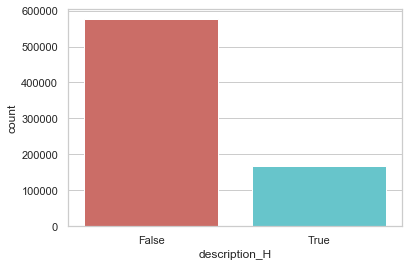

<Figure size 432x288 with 0 Axes>

In [88]:
sns.countplot(x='description_H', data=baseData, palette='hls')
plt.show()
plt.savefig('count_plot')

In [89]:
count_no_hits = len(baseData[baseData['description_H']==0])
count_hits = len(baseData[baseData['description_H']==1])
pct_of_no_hits = count_no_hits/(count_no_hits+count_hits)
print("percentage of no hits is", pct_of_no_hits*100)
pct_of_hits = count_hits/(count_no_hits+count_hits)
print("percentage of hits", pct_of_hits*100)

percentage of no hits is 77.46852906137136
percentage of hits 22.531470938628644


In [152]:
hitsMeans = baseData.groupby('description_H').describe()
hitsMeans.head()

year                                                 \
                  count         mean       std     min     25%     50%   
description_H                                                            
False          576135.0  2017.506390  1.117649  2016.0  2017.0  2018.0   
True           167567.0  2017.494256  1.120909  2016.0  2016.0  2017.0   

                                   Date                               \
                  75%     max     count          mean            std   
description_H                                                          
False          2019.0  2019.0  576135.0  2.017573e+08  111712.546926   
True           2019.0  2019.0  167567.0  2.017561e+08  112040.279525   

                                                                   \
                       min          25%          50%          75%   
description_H                                                       
False          201604030.0  201704040.0  201803310.0  201903280.0   
True           201604030.0  201610010.0  201709290.0  201903280.0   

                           GameIndex.x                                         \
                       max       count       mean        std  min   25%   50%   
description_H                                                                   
False          201909290.0    576135.0  81.379336  46.810964  1.0  41.0  81.0   
True           201909290.0    167567.0  81.730186  46.288635  1.0  42.0  82.0   

                            GameIndex.y                                   \
                 75%    max       count       mean        std  min   25%   
description_H                                                              
False          122.0  163.0    576135.0  81.345676  46.831043  1.0  41.0   
True           122.0  163.0    167567.0  81.692052  46.304306  1.0  42.0   

                                  PlayIndex                                   \
                50%    75%    max     count       mean        std  min   25%   
description_H                                                                  
False          81.0  122.0  163.0  576135.0  60.197910  37.395052  1.0  28.0   
True           82.0  121.0  163.0  167567.0  59.102496  36.949806  1.0  28.0   

                                 description_pa                                \
                50%   75%    max          count mean  std  min  25%  50%  75%   
description_H                                                                   
False          58.0  90.0  257.0       576135.0  1.0  0.0  1.0  1.0  1.0  1.0   
True           57.0  88.0  258.0       167567.0  1.0  0.0  1.0  1.0  1.0  1.0   

                      Runs_H                                                \
               max     count      mean       std  min  25%  50%  75%   max   
description_H                                                                
False          1.0  576135.0  4.656580  3.207952  0.0  2.0  4.0  6.0  25.0   
True           1.0  167567.0  5.165068  3.409536  0.0  3.0  5.0  7.0  25.0   

                 Runs_A                                                \
                  count      mean       std  min  25%  50%  75%   max   
description_H                                                           
False          576135.0  4.638911  3.250685  0.0  2.0  4.0  6.0  24.0   
True           167567.0  5.116151  3.429401  0.0  3.0  5.0  7.0  24.0   

                   Rank                                               \
                  count      mean       std  min  25%  50%  75%  max   
description_H                                                          
False          576135.0  2.940771  1.415004  1.0  2.0  3.0  4.0  5.0   
True           167567.0  2.948534  1.415833  1.0  2.0  3.0  4.0  5.0   

              Attendance                                               \
                   count          mean           std     min      25%   
description_H                                                           
False     

In [74]:
hitsMeans.to_csv('./hitmeans.csv')

In [144]:
bseData['BABIP'] = answe

9999.0

In [76]:
col_ranges

9.016055546737197

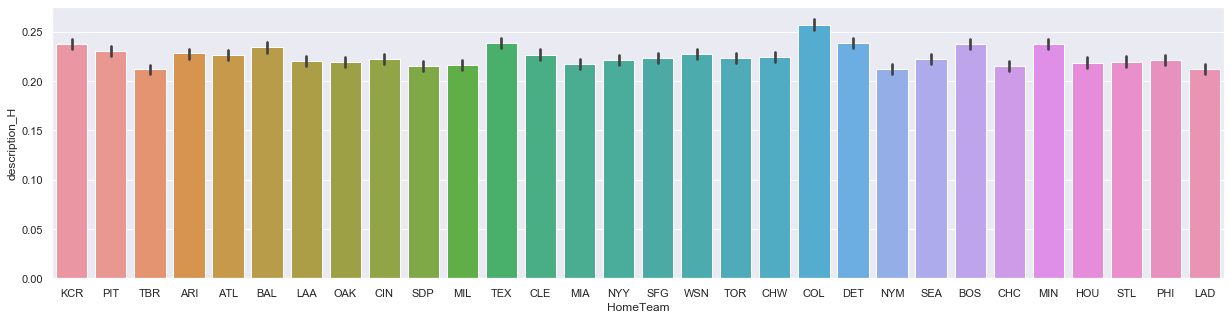

In [162]:
baseData.groupby('HomeTeam').sum()
%matplotlib inline

plt.figure(figsize=(21,5))

hitsteams_g = sns.barplot(x="HomeTeam", y="description_H", data=baseData)

In [155]:
batterGrouping = baseData.groupby(['batter_fname','batter_lname', 'HittingTeam', 'year']).sum()['description_H'].reset_index()




In [156]:
batterGrouping = batterGrouping.sort_values('description_H', ascending=False)
# plt.figure(figsize=(21,5))

# hitsteams_g = sns.barplot(x="HomeTeam", y="description_H", data=baseData)

In [157]:
batterGrouping.head(30)

,batter_fname,batter_lname,HittingTeam,year,description_H
2161,jose,altuve,HOU,2016,216.0
3024,mookie,betts,BOS,2016,214.0
722,charlie,blackmon,COL,2017,213.0
4013,whit,merrifield,KCR,2019,206.0
2162,jose,altuve,HOU,2017,204.0
1871,jean,segura,ARI,2016,203.0
1106,dee,gordon,MIA,2017,201.0
1249,dustin,pedroia,BOS,2016,201.0
3260,rafael,devers,BOS,2019,201.0
1336,ender,inciarte,ATL,2017,201.0


In [187]:
pitchingGroup = baseData.groupby(['pitcher_fname','pitcher_lname', 'PitchingTeam', 'year']).sum()[['description_H','allowed_hits']].reset_index()
pitchingGroup = pitchingGroup.sort_values('description_H', ascending=False)



In [183]:
# surrendered total hits ~= (pitching_IP * (pitching_H9 / 9))
pitchingGroup['allowed_hits'] = pitchingGroup['pitching_IP'] * (pitchingGroup['pitching_H9']/9)


In [188]:
pitchingGroup.head()

,pitcher_fname,pitcher_lname,PitchingTeam,year,description_H,allowed_hits
1267,glenn,sparkman,TOR,2017,0.750000,9.0
1377,jace,peterson,BAL,2018,0.750000,6.0
276,austen,williams,WSN,2019,0.714286,1.5
956,deolis,guerra,MIL,2019,0.666667,1.2
2300,matt,koch,ARI,2017,0.666667,NaN
